# Combined meta-study heart DE: covid versus healthy

Stephen Fleming

20210204

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

from sc_utils import limma_voom_DE, gsea_from_DE, calculate_bkg_prob, \
    all_volcano_plots, volcano_plot, plot_pathway_heatmap, plot_pathway_bars

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc.__version__

'1.6.1'

## The data

In [4]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 210232 × 29071
    obs: 'barcodes', 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'method', 'sample', 'doublet', 'max_umis', 'disease'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

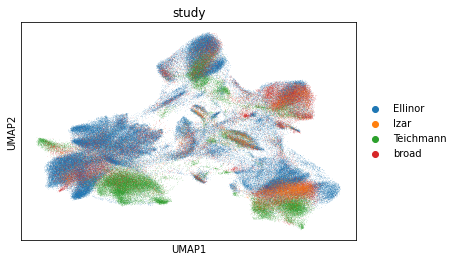

In [6]:
sc.pl.umap(adata, color='study')

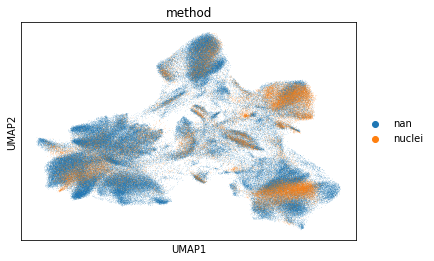

In [7]:
sc.pl.umap(adata, color='method')

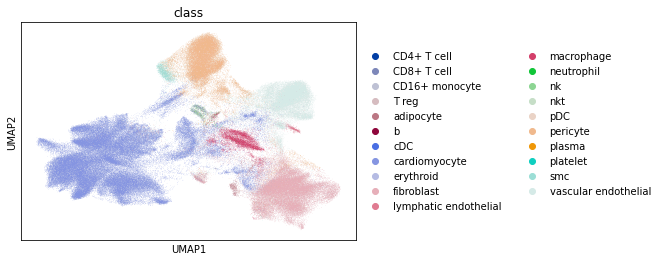

In [8]:
sc.pl.umap(adata, color='class')

In [9]:
adata.obs.head()

barcodes  n_genes   Channel  n_counts  percent_mito  \
0  H0015_LV-GTTACGAAGGACAACC     5519  H0015_LV   26162.0      0.000153   
1  H0015_LV-GGTGAAGGTGAATTGA     5973  H0015_LV   25617.0      0.000703   
2  H0015_LV-TTACGTTTCCTCACCA     4762  H0015_LV   23182.0      0.000129   
3  H0015_LV-CAGCACGAGCTTTCCC     5295  H0015_LV   21473.0      0.000093   
4  H0015_LV-TATTGCTCACAGTATC     5907  H0015_LV   19439.0      0.002058   

      scale leiden_labels          class  probability    class_2  \
0  3.823215             3  cardiomyocyte     0.951244  adipocyte   
1  3.904572             3  cardiomyocyte     0.957080  adipocyte   
2  4.314250             3  cardiomyocyte     0.944129  adipocyte   
3  4.658313             8  cardiomyocyte     0.951436        smc   
4  5.147740             5  cardiomyocyte     0.820317        smc   

   probability_2    study method sample doublet  max_umis  disease  
0       0.009252  Ellinor    nan    nan     nan       NaN  healthy  
1       0.008242  Ellinor    nan    nan     nan       NaN  healthy  
2       0.010991  Ellinor    nan    nan     nan       NaN  healthy  
3       0.011088  Ellinor    nan    nan     nan       NaN  healthy  
4       0.061478  Ellinor    nan    nan     nan       NaN  healthy

In [10]:
adata.obs['method'].value_counts()

nan       169352
nuclei     40880
Name: method, dtype: int64

In [11]:
adata.obs['study'].value_counts()

Ellinor      125873
Teichmann     43479
broad         30017
Izar          10863
Name: study, dtype: int64

In [12]:
pd.crosstab(adata.obs['Channel'], adata.obs['study'])

study            Ellinor   Izar  Teichmann  broad
Channel                                          
H0015_LV           10356      0          0      0
H0020_LV           13138      0          0      0
H0025_LV           12302      0          0      0
H0026_LV_V3         8196      0          0      0
H0035_LV            8107      0          0      0
H0037_LV            8492      0          0      0
HCAHeart7664652        0      0       4516      0
HCAHeart7664653        0      0       4357      0
HCAHeart7664654        0      0       4203      0
HCAHeart7698015        0      0       3913      0
HCAHeart7702873        0      0       4596      0
HCAHeart7757636        0      0        690      0
HCAHeart7829978        0      0       4951      0
HCAHeart7835148        0      0       5971      0
HCAHeart7880860        0      0       1922      0
HCAHeart7888922        0      0       4073      0
HCAHeart7985086        0      0       3933      0
HCAHeart8287124        0      0        354      0
LV_1221_1           3515      0          0      0
LV_1666_1           6411      0          0      0
LV_1666_2           7040      0          0      0
LV_1681_1           7548      0          0      0
LV_1681_2           8853      0          0      0
LV_1702_1           2323      0          0      0
LV_1702_2           1982      0          0      0
LV_1708_1           2878      0          0      0
LV_1708_2           7112      0          0      0
LV_1723_1           8524      0          0      0
LV_1723_2           9096      0          0      0
nan                    0  10863          0  30017

### Correcting some meta-data, and adding some in

In [13]:
import gc
gc.collect()

8467

The H00*_LV studies are from Teichmann

In [14]:
adata.obs['study'][adata.obs['Channel'].str.startswith('H00')] = 'Teichmann'

In [15]:
pd.crosstab(adata.obs['Channel'], adata.obs['study'])

study            Ellinor   Izar  Teichmann  broad
Channel                                          
H0015_LV               0      0      10356      0
H0020_LV               0      0      13138      0
H0025_LV               0      0      12302      0
H0026_LV_V3            0      0       8196      0
H0035_LV               0      0       8107      0
H0037_LV               0      0       8492      0
HCAHeart7664652        0      0       4516      0
HCAHeart7664653        0      0       4357      0
HCAHeart7664654        0      0       4203      0
HCAHeart7698015        0      0       3913      0
HCAHeart7702873        0      0       4596      0
HCAHeart7757636        0      0        690      0
HCAHeart7829978        0      0       4951      0
HCAHeart7835148        0      0       5971      0
HCAHeart7880860        0      0       1922      0
HCAHeart7888922        0      0       4073      0
HCAHeart7985086        0      0       3933      0
HCAHeart8287124        0      0        354      0
LV_1221_1           3515      0          0      0
LV_1666_1           6411      0          0      0
LV_1666_2           7040      0          0      0
LV_1681_1           7548      0          0      0
LV_1681_2           8853      0          0      0
LV_1702_1           2323      0          0      0
LV_1702_2           1982      0          0      0
LV_1708_1           2878      0          0      0
LV_1708_2           7112      0          0      0
LV_1723_1           8524      0          0      0
LV_1723_2           9096      0          0      0
nan                    0  10863          0  30017

Can also add in information from Teichmann's supplementary table 22.

In [17]:
df_teichmann = pd.read_csv('/home/jupyter-user/analysis/meta/Teichmann_Nature_Supplementary_Table_22.csv')

In [18]:
df_teichmann

Sanger ID  Source Targeted number of cells Donor Region  Gender  \
0    HCAHeart7606896   Cells                    10000     1     AX  Female   
1    HCAHeart7656534   Cells                     5000     3     LV    Male   
2    HCAHeart7656535   Cells                     5000     3     RV    Male   
3    HCAHeart7656536   Cells                     5000     3     LA    Male   
4    HCAHeart7656537   Cells                     5000     3     SP    Male   
..               ...     ...                      ...   ...    ...     ...   
145    H0037_LA_corr  Nuclei                    3,000    H4     LA    Male   
146         H0037_RV  Nuclei                    8,000    H4     RV    Male   
147     H0037_septum  Nuclei                    8,000    H4     SP    Male   
148         H0037_LA  Nuclei                    3,000    H4     LA    Male   
149         H0037_RA  Nuclei                    4,000    H4     RA    Male   

       Age Type 10X version  
0    50-55  DBD          V2  
1    55-60  DBD          V2  
2    55-60  DBD          V2  
3    55-60  DBD          V2  
4    55-60  DBD          V2  
..     ...  ...         ...  
145  55-60  DBD          V3  
146  55-60  DBD          V3  
147  55-60  DBD          V3  
148  55-60  DBD          V3  
149  55-60  DBD          V3  

[150 rows x 9 columns]

In [19]:
teichmann_metadata = pd.DataFrame(data={'sample': df_teichmann['Sanger ID'], 
                                        'method': df_teichmann['Source'].str.lower(),
                                        'individual': 'T' + df_teichmann['Donor'].astype(str),
                                        'tissue': df_teichmann['Region'].str.upper(),
                                        'sex': df_teichmann['Gender'].str.lower(),
                                        'version10x': df_teichmann['10X version']})
teichmann_metadata

sample  method individual tissue     sex version10x
0    HCAHeart7606896   cells         T1     AX  female         V2
1    HCAHeart7656534   cells         T3     LV    male         V2
2    HCAHeart7656535   cells         T3     RV    male         V2
3    HCAHeart7656536   cells         T3     LA    male         V2
4    HCAHeart7656537   cells         T3     SP    male         V2
..               ...     ...        ...    ...     ...        ...
145    H0037_LA_corr  nuclei        TH4     LA    male         V3
146         H0037_RV  nuclei        TH4     RV    male         V3
147     H0037_septum  nuclei        TH4     SP    male         V3
148         H0037_LA  nuclei        TH4     LA    male         V3
149         H0037_RA  nuclei        TH4     RA    male         V3

[150 rows x 6 columns]

We seem to be missing "sample" / "Channel" information for the Broad and Izar samples.

In [20]:
pd.crosstab(adata.obs['sample'], adata.obs['study'])

study                Ellinor  Izar  Teichmann  broad
sample                                              
02-P005175-S041-R01        0     0          0  10257
02-P118946-S043-R01        0     0          0   5832
02-P166169-S026-R01        0     0          0     33
02-P166169-S117-R01        0     0          0    186
02-P240970-S048-R01        0     0          0   3347
02-P248880-S011-R01        0     0          0   1300
02-P334354-S012-R01        0     0          0     39
02-P348762-S011-R01        0     0          0   3538
04-P006354-S031-R01        0     0          0   1670
04-P054921-S072-R01        0     0          0   1431
04-P079042-S071-R01        0     0          0   2384
12-P485759-S012-R01        0   677          0      0
12-P617758-S012-R01        0  2957          0      0
12-P852049-S011-R01        0  1620          0      0
12-P890292-S009-R01        0  1391          0      0
13-P999993-S001-R01        0  2006          0      0
13-P999994-S002-R01        0  1108          0      0
13-P999998-S001-R01        0   286          0      0
13-P999999-S001-R01        0   818          0      0
nan                    65282     0     104070      0

Okay the information is in "sample".  I'll put the Teichmann and Ellinor data in "sample" too, since I like that nomenclature.

In [21]:
adata.obs['sample'] = adata.obs['sample'].astype(str)
adata.obs['Channel'] = adata.obs['Channel'].astype(str)

adata.obs['sample'][adata.obs['sample'] == 'nan'] = adata.obs['Channel'][adata.obs['sample'] == 'nan']

adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['Channel'] = adata.obs['Channel'].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
pd.crosstab(adata.obs['sample'], adata.obs['study'])

study                Ellinor  Izar  Teichmann  broad
sample                                              
02-P005175-S041-R01        0     0          0  10257
02-P118946-S043-R01        0     0          0   5832
02-P166169-S026-R01        0     0          0     33
02-P166169-S117-R01        0     0          0    186
02-P240970-S048-R01        0     0          0   3347
02-P248880-S011-R01        0     0          0   1300
02-P334354-S012-R01        0     0          0     39
02-P348762-S011-R01        0     0          0   3538
04-P006354-S031-R01        0     0          0   1670
04-P054921-S072-R01        0     0          0   1431
04-P079042-S071-R01        0     0          0   2384
12-P485759-S012-R01        0   677          0      0
12-P617758-S012-R01        0  2957          0      0
12-P852049-S011-R01        0  1620          0      0
12-P890292-S009-R01        0  1391          0      0
13-P999993-S001-R01        0  2006          0      0
13-P999994-S002-R01        0  1108          0      0
13-P999998-S001-R01        0   286          0      0
13-P999999-S001-R01        0   818          0      0
H0015_LV                   0     0      10356      0
H0020_LV                   0     0      13138      0
H0025_LV                   0     0      12302      0
H0026_LV_V3                0     0       8196      0
H0035_LV                   0     0       8107      0
H0037_LV                   0     0       8492      0
HCAHeart7664652            0     0       4516      0
HCAHeart7664653            0     0       4357      0
HCAHeart7664654            0     0       4203      0
HCAHeart7698015            0     0       3913      0
HCAHeart7702873            0     0       4596      0
HCAHeart7757636            0     0        690      0
HCAHeart7829978            0     0       4951      0
HCAHeart7835148            0     0       5971      0
HCAHeart7880860            0     0       1922      0
HCAHeart7888922            0     0       4073      0
HCAHeart7985086            0     0       3933      0
HCAHeart8287124            0     0        354      0
LV_1221_1               3515     0          0      0
LV_1666_1               6411     0          0      0
LV_1666_2               7040     0          0      0
LV_1681_1               7548     0          0      0
LV_1681_2               8853     0          0      0
LV_1702_1               2323     0          0      0
LV_1702_2               1982     0          0      0
LV_1708_1               2878     0          0      0
LV_1708_2               7112     0          0      0
LV_1723_1               8524     0          0      0
LV_1723_2               9096     0          0      0

This looks good.

Add the Teichmann metadata.

In [23]:
if 'individual' not in adata.obs.keys():

    adata.obs = pd.merge(left=adata.obs, right=teichmann_metadata, how='left', on='sample').set_index('barcodes')
    
else:
    print('You have already run this merge... do not do it twice')

In [24]:
adata.obs.head()

n_genes   Channel  n_counts  percent_mito  \
barcodes                                                               
H0015_LV-GTTACGAAGGACAACC     5519  H0015_LV   26162.0      0.000153   
H0015_LV-GGTGAAGGTGAATTGA     5973  H0015_LV   25617.0      0.000703   
H0015_LV-TTACGTTTCCTCACCA     4762  H0015_LV   23182.0      0.000129   
H0015_LV-CAGCACGAGCTTTCCC     5295  H0015_LV   21473.0      0.000093   
H0015_LV-TATTGCTCACAGTATC     5907  H0015_LV   19439.0      0.002058   

                              scale leiden_labels          class  probability  \
barcodes                                                                        
H0015_LV-GTTACGAAGGACAACC  3.823215             3  cardiomyocyte     0.951244   
H0015_LV-GGTGAAGGTGAATTGA  3.904572             3  cardiomyocyte     0.957080   
H0015_LV-TTACGTTTCCTCACCA  4.314250             3  cardiomyocyte     0.944129   
H0015_LV-CAGCACGAGCTTTCCC  4.658313             8  cardiomyocyte     0.951436   
H0015_LV-TATTGCTCACAGTATC  5.147740             5  cardiomyocyte     0.820317   

                             class_2  probability_2  ... method_x    sample  \
barcodes                                             ...                      
H0015_LV-GTTACGAAGGACAACC  adipocyte       0.009252  ...      nan  H0015_LV   
H0015_LV-GGTGAAGGTGAATTGA  adipocyte       0.008242  ...      nan  H0015_LV   
H0015_LV-TTACGTTTCCTCACCA  adipocyte       0.010991  ...      nan  H0015_LV   
H0015_LV-CAGCACGAGCTTTCCC        smc       0.011088  ...      nan  H0015_LV   
H0015_LV-TATTGCTCACAGTATC        smc       0.061478  ...      nan  H0015_LV   

                          doublet max_umis  disease method_y individual  \
barcodes                                                                  
H0015_LV-GTTACGAAGGACAACC     nan      NaN  healthy   nuclei        TH5   
H0015_LV-GGTGAAGGTGAATTGA     nan      NaN  healthy   nuclei        TH5   
H0015_LV-TTACGTTTCCTCACCA     nan      NaN  healthy   nuclei        TH5   
H0015_LV-CAGCACGAGCTTTCCC     nan      NaN  healthy   nuclei        TH5   
H0015_LV-TATTGCTCACAGTATC     nan      NaN  healthy   nuclei        TH5   

                          tissue     sex version10x  
barcodes                                             
H0015_LV-GTTACGAAGGACAACC     LV  female         V3  
H0015_LV-GGTGAAGGTGAATTGA     LV  female         V3  
H0015_LV-TTACGTTTCCTCACCA     LV  female         V3  
H0015_LV-CAGCACGAGCTTTCCC     LV  female         V3  
H0015_LV-TATTGCTCACAGTATC     LV  female         V3  

[5 rows x 21 columns]

Specify "individual" for the Ellinor and Broad and Izar data.

In [26]:
adata.obs['individual'][adata.obs['study'] == 'Ellinor'] = \
    adata.obs['sample'][adata.obs['study'] == 'Ellinor'].apply(lambda s: 'E' + s.split('_')[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
adata.obs['study'].unique()

[Teichmann, Ellinor, broad, Izar]
Categories (4, object): [Teichmann, Ellinor, broad, Izar]

In [45]:
# Broad / Izar metadata

broad_metadata = pd.DataFrame(data={
    'donor': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 
              'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24',
              'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32'],
    'broad_id': ['02-P005175', '02-P118946', '02-P166169', '02-P240970', '02-P248880', 
                 '02-P334354', '02-P348762', '04-P006354', '04-P024506', '04-P054921', 
                 '04-P079042', '04-P103142', '12-P230638', '12-P485759', '12-P617758', 
                 '12-P852049', '12-P890292', '04-P373577', '04-P433472', '04-P478538', 
                 '04-P541935', '04-P718490', '04-P939373', '04-P978210',
                 '13-P999991', '13-P999992', '13-P999993', '13-P999994', '13-P999996', 
                 '13-P999997', '13-P999998', '13-P999999'],
    'sex': ['male' if (x == 0) else 'female' for x in 
            [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,  # Broad
             0, 1, 0, 1, 1, 0, 0, 0,  # Izar
            ]],
})

broad_metadata['individual'] = broad_metadata['broad_id'].apply(lambda s: s.split('-')[-1])
broad_metadata

donor    broad_id     sex individual
0     D1  02-P005175  female    P005175
1     D2  02-P118946    male    P118946
2     D3  02-P166169    male    P166169
3     D4  02-P240970    male    P240970
4     D5  02-P248880  female    P248880
5     D6  02-P334354    male    P334354
6     D7  02-P348762    male    P348762
7     D8  04-P006354    male    P006354
8     D9  04-P024506  female    P024506
9    D10  04-P054921    male    P054921
10   D11  04-P079042    male    P079042
11   D12  04-P103142    male    P103142
12   D13  12-P230638    male    P230638
13   D14  12-P485759  female    P485759
14   D15  12-P617758  female    P617758
15   D16  12-P852049  female    P852049
16   D17  12-P890292    male    P890292
17   D18  04-P373577  female    P373577
18   D19  04-P433472    male    P433472
19   D20  04-P478538  female    P478538
20   D21  04-P541935    male    P541935
21   D22  04-P718490    male    P718490
22   D23  04-P939373  female    P939373
23   D24  04-P978210    male    P978210
24   D25  13-P999991    male    P999991
25   D26  13-P999992  female    P999992
26   D27  13-P999993    male    P999993
27   D28  13-P999994  female    P999994
28   D29  13-P999996  female    P999996
29   D30  13-P999997    male    P999997
30   D31  13-P999998    male    P999998
31   D32  13-P999999    male    P999999

In [46]:
# Broad donor names

lookup = dict(zip(broad_metadata['individual'], broad_metadata['donor']))

adata.obs['individual'][adata.obs['study'].isin(['broad', 'Izar'])] = \
    adata.obs['sample'][adata.obs['study'].isin(['broad', 'Izar'])].apply(lambda s: lookup[s.split('-')[1]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [47]:
adata.obs['individual'].unique()

array(['TH5', 'TH6', 'TH3', 'TH2', 'TH7', 'TH4', 'T1', 'T2', 'T3', 'T4',
       'T5', 'T6', 'T7', 'T11', 'E1221', 'E1666', 'E1681', 'E1702',
       'E1708', 'E1723', 'D3', 'D5', 'D1', 'D2', 'D4', 'D6', 'D7', 'D10',
       'D11', 'D8', 'D14', 'D15', 'D16', 'D17', 'D32', 'D31', 'D28',
       'D27'], dtype=object)

In [80]:
# Broad sex data

lookup = dict(zip(broad_metadata['donor'], broad_metadata['sex']))

adata.obs['sex'][adata.obs['study'].isin(['broad', 'Izar'])] = \
    adata.obs['individual'][adata.obs['study'].isin(['broad', 'Izar'])].apply(lambda s: lookup[s])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
# Broad tissues are all LV and chemistry is all V3

adata.obs['tissue'][adata.obs['study'].isin(['broad', 'Izar'])] = 'LV'
adata.obs['version10x'][adata.obs['study'].isin(['broad', 'Izar'])] = 'V3'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Ellinor metadata.

In [48]:
# Tucker et al. Circulation 2020, Supplement Figure 1B

ellinor_metadata = pd.DataFrame(data={'individual': ['E1702', 'E1666', 'E1681', 
                                                     'E1221', 'E1600', 'E1723', 'E1708'],
                                      'sex': ['male', 'male', 'male',
                                              'female', 'female', 'female', 'female']})
ellinor_metadata

individual     sex
0      E1702    male
1      E1666    male
2      E1681    male
3      E1221  female
4      E1600  female
5      E1723  female
6      E1708  female

In [50]:
pd.options.display.max_columns = None

In [51]:
adata.obs.head()

n_genes   Channel  n_counts  percent_mito  \
barcodes                                                               
H0015_LV-GTTACGAAGGACAACC     5519  H0015_LV   26162.0      0.000153   
H0015_LV-GGTGAAGGTGAATTGA     5973  H0015_LV   25617.0      0.000703   
H0015_LV-TTACGTTTCCTCACCA     4762  H0015_LV   23182.0      0.000129   
H0015_LV-CAGCACGAGCTTTCCC     5295  H0015_LV   21473.0      0.000093   
H0015_LV-TATTGCTCACAGTATC     5907  H0015_LV   19439.0      0.002058   

                              scale leiden_labels          class  probability  \
barcodes                                                                        
H0015_LV-GTTACGAAGGACAACC  3.823215             3  cardiomyocyte     0.951244   
H0015_LV-GGTGAAGGTGAATTGA  3.904572             3  cardiomyocyte     0.957080   
H0015_LV-TTACGTTTCCTCACCA  4.314250             3  cardiomyocyte     0.944129   
H0015_LV-CAGCACGAGCTTTCCC  4.658313             8  cardiomyocyte     0.951436   
H0015_LV-TATTGCTCACAGTATC  5.147740             5  cardiomyocyte     0.820317   

                             class_2  probability_2      study method_x  \
barcodes                                                                  
H0015_LV-GTTACGAAGGACAACC  adipocyte       0.009252  Teichmann      nan   
H0015_LV-GGTGAAGGTGAATTGA  adipocyte       0.008242  Teichmann      nan   
H0015_LV-TTACGTTTCCTCACCA  adipocyte       0.010991  Teichmann      nan   
H0015_LV-CAGCACGAGCTTTCCC        smc       0.011088  Teichmann      nan   
H0015_LV-TATTGCTCACAGTATC        smc       0.061478  Teichmann      nan   

                             sample doublet  max_umis  disease method_y  \
barcodes                                                                  
H0015_LV-GTTACGAAGGACAACC  H0015_LV     nan       NaN  healthy   nuclei   
H0015_LV-GGTGAAGGTGAATTGA  H0015_LV     nan       NaN  healthy   nuclei   
H0015_LV-TTACGTTTCCTCACCA  H0015_LV     nan       NaN  healthy   nuclei   
H0015_LV-CAGCACGAGCTTTCCC  H0015_LV     nan       NaN  healthy   nuclei   
H0015_LV-TATTGCTCACAGTATC  H0015_LV     nan       NaN  healthy   nuclei   

                          individual tissue     sex version10x  
barcodes                                                        
H0015_LV-GTTACGAAGGACAACC        TH5     LV  female         V3  
H0015_LV-GGTGAAGGTGAATTGA        TH5     LV  female         V3  
H0015_LV-TTACGTTTCCTCACCA        TH5     LV  female         V3  
H0015_LV-CAGCACGAGCTTTCCC        TH5     LV  female         V3  
H0015_LV-TATTGCTCACAGTATC        TH5     LV  female         V3

In [77]:
# add in some ellinor constants

adata.obs['tissue'][adata.obs['study'] == 'Ellinor'] = 'LV'
adata.obs['version10x'][adata.obs['study'] == 'Ellinor'] = 'V2'
adata.obs['method'][adata.obs['study'] == 'Ellinor'] = 'nuclei'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [54]:
# ellinor sex data

lookup_ellinor = dict(zip(ellinor_metadata['individual'], ellinor_metadata['sex']))

adata.obs['sex'][adata.obs['study'] == 'Ellinor'] = \
    adata.obs['individual'][adata.obs['study'] == 'Ellinor'].apply(lambda s: lookup_ellinor[s])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [81]:
pd.crosstab(adata.obs['individual'], adata.obs['sex'])

sex         female   male
individual               
D1           10257      0
D10              0   1431
D11              0   2384
D14            677      0
D15           2957      0
D16           1620      0
D17              0   1391
D2               0   5832
D27              0   2006
D28           1108      0
D3               0    219
D31              0    286
D32              0    818
D4               0   3347
D5            1300      0
D6               0     39
D7               0   3538
D8               0   1670
E1221         3515      0
E1666            0  13451
E1681            0  16401
E1702            0   4305
E1708         9990      0
E1723        17620      0
T1            8429      0
T11            354      0
T2               0   8953
T3               0   8826
T4            4951      0
T5            5971      0
T6               0   1922
T7               0   4073
TH2              0   8196
TH3              0  12302
TH4              0   8492
TH5          10356      0
TH6          13138      0
TH7           8107      0

Fix up a few things.

In [61]:
adata.obs['method_x'] = adata.obs['method_x'].astype(str)
adata.obs['method_x'] = adata.obs['method_x'].apply(lambda s: s if (s != 'nan') else np.nan)

adata.obs['method'] = adata.obs['method_x'].combine_first(adata.obs['method_y'])

del adata.obs['method_x']
del adata.obs['method_y']

In [93]:
adata.obs['method'].unique()

array(['nuclei'], dtype=object)

In [94]:
adata.obs['tissue'].unique()

array(['LV'], dtype=object)

In [95]:
adata.obs['version10x'].unique()

array(['V3', 'V2'], dtype=object)

In [96]:
pd.crosstab(adata.obs['individual'], adata.obs['version10x'])

version10x     V2     V3
individual              
D1              0  10257
D10             0   1431
D11             0   2384
D14             0    677
D15             0   2957
D16             0   1620
D17             0   1391
D2              0   5832
D27             0   2006
D28             0   1108
D3              0    219
D31             0    286
D32             0    818
D4              0   3347
D5              0   1300
D6              0     39
D7              0   3538
D8              0   1670
E1221        3515      0
E1666       13451      0
E1681       16401      0
E1702        4305      0
E1708        9990      0
E1723       17620      0
T1           8429      0
T11             0    354
T2           8953      0
T3           8826      0
T4           4951      0
T5           5971      0
T6           1922      0
T7           4073      0
TH2             0   8196
TH3             0  12302
TH4             0   8492
TH5             0  10356
TH6             0  13138
TH7             0   8107

Looks okay

In [97]:
adata.obs

n_genes   Channel  n_counts  \
barcodes                                                            
H0015_LV-GTTACGAAGGACAACC                5519  H0015_LV   26162.0   
H0015_LV-GGTGAAGGTGAATTGA                5973  H0015_LV   25617.0   
H0015_LV-TTACGTTTCCTCACCA                4762  H0015_LV   23182.0   
H0015_LV-CAGCACGAGCTTTCCC                5295  H0015_LV   21473.0   
H0015_LV-TATTGCTCACAGTATC                5907  H0015_LV   19439.0   
...                                       ...       ...       ...   
13-P999993-S001-R01-CGTTGGGTCCACGTCT      334       nan     402.0   
13-P999993-S001-R01-GCCGTGAGTCAAGCCC      352       nan     400.0   
13-P999993-S001-R01-CCAATGAAGCAGCCTC      329       nan     404.0   
13-P999993-S001-R01-CATCGGGTCGCAACAT      336       nan     400.0   
13-P999993-S001-R01-GTCGCGACAAAGCTCT      330       nan     402.0   

                                      percent_mito     scale leiden_labels  \
barcodes                                                                     
H0015_LV-GTTACGAAGGACAACC                 0.000153  3.823215             3   
H0015_LV-GGTGAAGGTGAATTGA                 0.000703  3.904572             3   
H0015_LV-TTACGTTTCCTCACCA                 0.000129  4.314250             3   
H0015_LV-CAGCACGAGCTTTCCC                 0.000093  4.658313             8   
H0015_LV-TATTGCTCACAGTATC                 0.002058  5.147740             5   
...                                            ...       ...           ...   
13-P999993-S001-R01-CGTTGGGTCCACGTCT      0.000000       NaN           nan   
13-P999993-S001-R01-GCCGTGAGTCAAGCCC      0.000000       NaN           nan   
13-P999993-S001-R01-CCAATGAAGCAGCCTC      0.000000       NaN           nan   
13-P999993-S001-R01-CATCGGGTCGCAACAT      0.000000       NaN           nan   
13-P999993-S001-R01-GTCGCGACAAAGCTCT      0.000000       NaN           nan   

                                              class  probability  \
barcodes                                                           
H0015_LV-GTTACGAAGGACAACC             cardiomyocyte     0.951244   
H0015_LV-GGTGAAGGTGAATTGA             cardiomyocyte     0.957080   
H0015_LV-TTACGTTTCCTCACCA             cardiomyocyte     0.944129   
H0015_LV-CAGCACGAGCTTTCCC             cardiomyocyte     0.951436   
H0015_LV-TATTGCTCACAGTATC             cardiomyocyte     0.820317   
...                                             ...          ...   
13-P999993-S001-R01-CGTTGGGTCCACGTCT     fibroblast     0.264010   
13-P999993-S001-R01-GCCGTGAGTCAAGCCC     fibroblast     0.527335   
13-P999993-S001-R01-CCAATGAAGCAGCCTC     fibroblast     0.285618   
13-P999993-S001-R01-CATCGGGTCGCAACAT     fibroblast     0.246377   
13-P999993-S001-R01-GTCGCGACAAAGCTCT     fibroblast     0.400187   

                                            class_2  probability_2      study  \
barcodes                                                                        
H0015_LV-GTTACGAAGGACAACC                 adipocyte       0.009252  Teichmann   
H0015_LV-GGTGAAGGTGAATTGA                 adipocyte       0.008242  Teichmann   
H0015_LV-TTACGTTTCCTCACCA                 adipocyte       0.010991  Teichmann   
H0015_LV-CAGCACGAGCTTTCCC                       smc       0.011088  Teichmann   
H0015_LV-TATTGCTCACAGTATC                       smc       0.061478  Teichmann   
...                                             ...            ...        ...   
13-P999993-S001-R01-CGTTGGGTCCACGTCT            smc       0.079790       Izar   
13-P999993-S001-R01-GCCGTGAGTCAAGCCC  cardiomyocyte       0.066843       Izar   
13-P999993-S001-R01-CCAATGAAGCAGCCTC  cardiomyocyte       0.096524       Izar   
13-P999993-S001-R01-CATCGGGTCGCAACAT       pericyte       0.107405       Izar   
13-P999993-S001-R01-GTCGCGACAAAGCTCT            smc       0.066697       Izar   

                                                   sample doublet  max_umis  \
barcodes                                                                      
H0015_LV-GTTACGAAGGACAACC   

In [98]:
adata.obs['doublet'].value_counts()

nan      169352
False     40880
Name: doublet, dtype: int64

In [20]:
adata.obs['disease'].value_counts()

healthy     169352
COVID-19     40880
Name: disease, dtype: int64

In [21]:
adata.obs['disease'] = adata.obs['disease'].apply(lambda s: s.replace('-', ''))

In [22]:
adata.obs['disease'].value_counts()

healthy    169352
COVID19     40880
Name: disease, dtype: int64

In [23]:
adata.write('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF.h5ad')

... storing 'cluster' as categorical


## DE testing

In [33]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 210232 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'hvg', 'method_colors', 'neighbors', 'pca', 'study_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

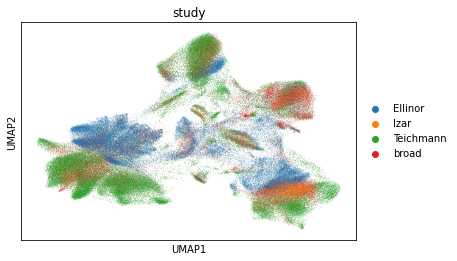

In [6]:
sc.pl.umap(adata, color='study')

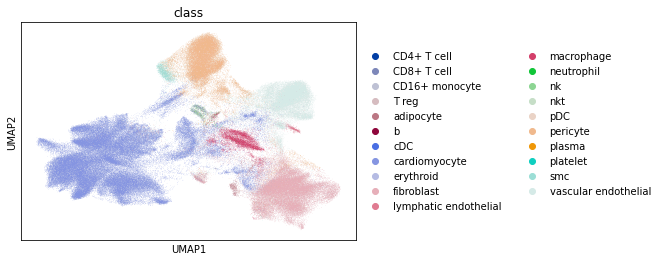

In [7]:
sc.pl.umap(adata, color='class')

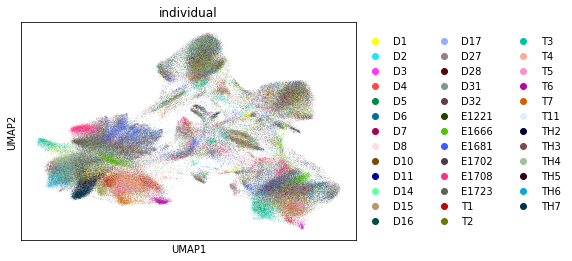

In [8]:
sc.pl.umap(adata, color='individual')

There really appear to be a lot of doublets.

I will simplify the cell types a bit by grouping similar ones... these are the automatically generated cell type annotations.

In [10]:
adata.obs['class'].value_counts()

cardiomyocyte            104182
fibroblast                39142
pericyte                  31001
vascular endothelial      22438
macrophage                 6986
smc                        2455
adipocyte                  1452
nk                          754
lymphatic endothelial       692
CD8+ T cell                 558
T reg                       141
CD16+ monocyte               78
erythroid                    72
plasma                       71
b                            64
nkt                          51
neutrophil                   48
platelet                     18
CD4+ T cell                  12
cDC                           9
pDC                           8
Name: class, dtype: int64

In [12]:
def simplify_clusters(k):
    """Simplify the cluster naming mainly by grouping immune cells"""
    
    if k == 'smc':
        return 'vsmc'
    elif k in ['nk', 'CD8+ T cell', 'T reg', 'CD16+ monocyte', 'erythroid', 'plasma', 
               'b', 'nkt', 'neutrophil', 'platelet', 'CD4+ T cell', 'cDC', 'pDC']:
        return 'immune'
    else:
        return k

adata.obs['cluster'] = adata.obs['class'].apply(simplify_clusters)

In [13]:
adata.obs['cluster'].value_counts()

cardiomyocyte            104182
fibroblast                39142
pericyte                  31001
vascular endothelial      22438
macrophage                 6986
vsmc                       2455
immune                     1884
adipocyte                  1452
lymphatic endothelial       692
Name: cluster, dtype: int64

This is a pseudobulk limma+voom technique.

I will sum over cells that have the same `individual` and `cluster`.

The model will be `~ 0 + disease + study + version10x + sex`

In [14]:
adata.obs['individual_cluster'] = (adata.obs['individual'].astype(str) 
                                   + ':' + adata.obs['cluster'].astype(str))
adata.obs['individual_cluster'] = adata.obs['individual_cluster'].astype('category')

In [18]:
adata.obs['individual_cluster'].value_counts().head()

E1723:cardiomyocyte    11018
E1681:cardiomyocyte    10963
TH6:cardiomyocyte       8786
E1708:cardiomyocyte     6764
TH5:cardiomyocyte       6328
Name: individual_cluster, dtype: int64

Working on cluster group "cardiomyocyte" ========================================

total cells in group = 104182

cells per "disease":
healthy    92175
COVID19    12007
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1723:cardiomyocyte    11018
E1681:cardiomyocyte    10963
TH6:cardiomyocyte       8786
E1708:cardiomyocyte     6764
TH5:cardiomyocyte       6328
T1:cardiomyocyte        5755
TH3:cardiomyocyte       5350
D1:cardiomyocyte        5198
E1666:cardiomyocyte     4539
TH7:cardiomyocyte       4465
TH4:cardiomyocyte       3756
E1702:cardiomyocyte     3460
T5:cardiomyocyte        3363
TH2:cardiomyocyte       3240
T4:cardiomyocyte        2889
T2:cardiomyocyte        2852
E1221:cardiomyocyte     2665
T3:cardiomyocyte        2489
T7:cardiomyocyte        2121
D2:cardiomyocyte        1405
T6:cardiomyocyte        1208
D17:cardiomyocyte        838
D7:cardiomyocyte         802
D4:cardiomyocyte         772
D8:cardiomyocyte         657
D10:cardiomyocyte        597
D15:cardiomyocy

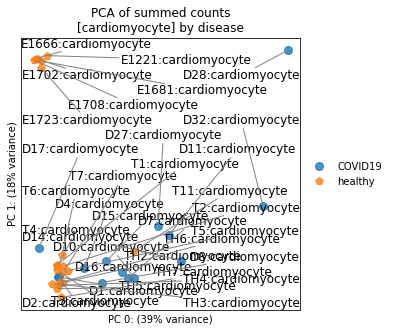

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [20758, 34]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [34, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


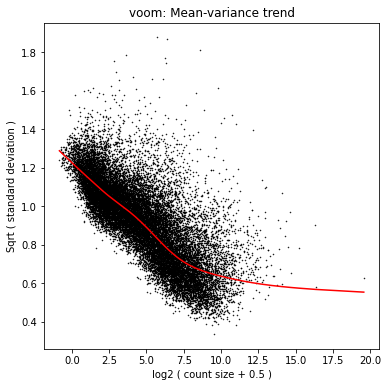

Contrast COVID19 vs. healthy
number of cells in COVID19 = 12007
number of cells in healthy = 92175


Saved grouping ['cardiomyocyte'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_cardiomyocyte_DE.tsv

Working on cluster group "fibroblast" ========================================

total cells in group = 39142

cells per "disease":
healthy    28613
COVID19    10529
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1666:fibroblast    4154
E1681:fibroblast    3373
T3:fibroblast       3088
E1723:fibroblast    2973
T2:fibroblast       2480
TH3:fibroblast      2253
D1:fibroblast       1526
T5:fibroblast       1429
E1708:fibroblast    1411
D2:fibroblast       1237
TH6:fibroblast      1236
D27:fibroblast      1200
T1:fibroblast       1093
D7:fibroblast       1020
D11:fibroblast       926
D15:fibroblast       824
D28:fibroblast       785
T7:fibroblast        698
T4:fibroblast        669
TH2:fibroblast       663
D5:fibroblast        589
TH7:fibroblast       578
TH5:fibroblast       571
D4:fibroblast        551
TH4:fibroblast       522
E1221:fibroblast     513
E1702:fibro

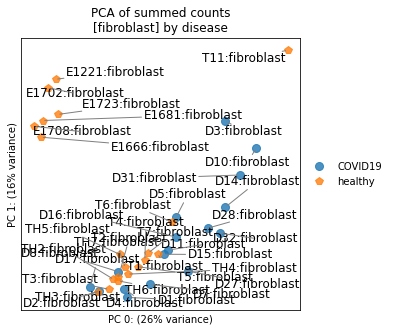

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [16111, 37]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [37, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


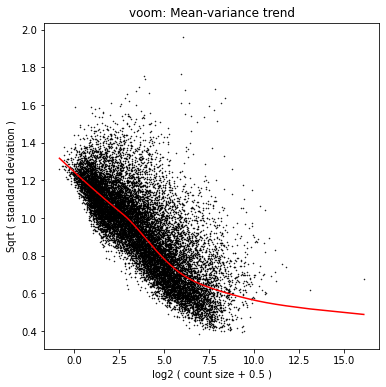

Contrast COVID19 vs. healthy
number of cells in COVID19 = 10529
number of cells in healthy = 28613


Saved grouping ['fibroblast'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_fibroblast_DE.tsv

Working on cluster group "pericyte" ========================================

total cells in group = 31001

cells per "disease":
healthy    26728
COVID19     4273
Name: disease, dtype: int64
 
cells per "individual_cluster":
TH4:pericyte      3282
TH3:pericyte      3112
T2:pericyte       2492
TH2:pericyte      2464
TH5:pericyte      2229
TH6:pericyte      2085
TH7:pericyte      1985
E1666:pericyte    1707
E1723:pericyte    1386
T3:pericyte       1281
D2:pericyte       1255
D1:pericyte       1134
T1:pericyte       1082
E1681:pericyte     917
T4:pericyte        892
T5:pericyte        560
E1708:pericyte     505
T7:pericyte        448
D4:pericyte        398
D7:pericyte        281
D15:pericyte       248
D5:pericyte        162
D27:pericyte       139
D11:pericyte       128
D16:pericyte       123
D32:pericyte       102
E1702:pericyte      92
T6:pericyte         81
D28:pericyte        79
E1

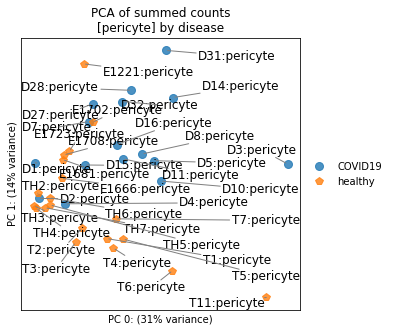

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [12990, 36]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [36, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


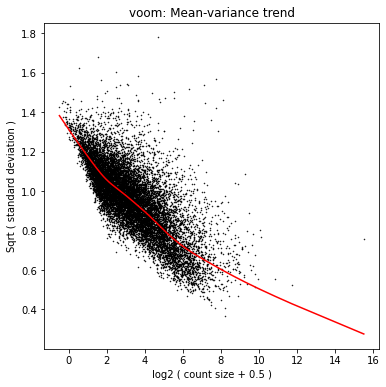

Contrast COVID19 vs. healthy
number of cells in COVID19 = 4273
number of cells in healthy = 26728


Saved grouping ['pericyte'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_pericyte_DE.tsv

Working on cluster group "vsmc" ========================================

total cells in group = 2455

cells per "disease":
healthy    1704
COVID19     751
Name: disease, dtype: int64
 
cells per "individual_cluster":
TH2:vsmc      266
D2:vsmc       246
D4:vsmc       237
TH5:vsmc      228
E1681:vsmc    211
TH6:vsmc      152
TH4:vsmc      142
TH3:vsmc      139
TH7:vsmc      134
D1:vsmc       125
T3:vsmc       116
E1723:vsmc     83
E1708:vsmc     61
T2:vsmc        59
D17:vsmc       43
E1221:vsmc     29
E1666:vsmc     28
D15:vsmc       18
D7:vsmc        17
T4:vsmc        15
D11:vsmc       14
T5:vsmc        13
D27:vsmc       12
E1702:vsmc     12
D3:vsmc        12
T1:vsmc        10
D16:vsmc        9
D5:vsmc         5
T7:vsmc         5
D32:vsmc        4
D10:vsmc        3
D28:vsmc        2
D8:vsmc         2
D31:vsmc        1
D14:vsmc        1
T11:vsmc        1
Name: individual_cluster, dtype:

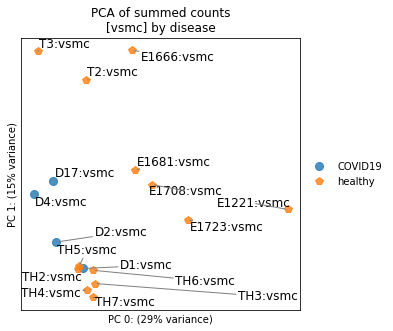

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [9602, 17]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [17, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


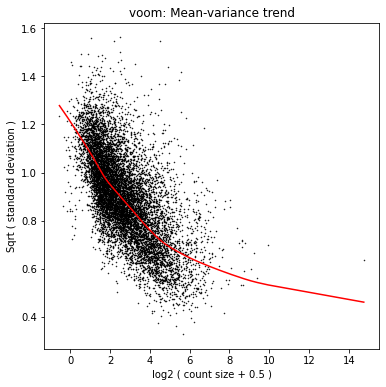

Contrast COVID19 vs. healthy
number of cells in COVID19 = 751
number of cells in healthy = 1704


Saved grouping ['vsmc'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_vsmc_DE.tsv

Working on cluster group "lymphatic endothelial" ========================================

total cells in group = 692

cells per "disease":
healthy    484
COVID19    208
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1723:lymphatic endothelial    308
D11:lymphatic endothelial       45
E1708:lymphatic endothelial     37
D14:lymphatic endothelial       25
T2:lymphatic endothelial        23
D5:lymphatic endothelial        22
D27:lymphatic endothelial       21
T5:lymphatic endothelial        21
T3:lymphatic endothelial        21
D4:lymphatic endothelial        20
D16:lymphatic endothelial       17
D10:lymphatic endothelial       15
E1681:lymphatic endothelial     15
D7:lymphatic endothelial        13
D17:lymphatic endothelial       12
E1666:lymphatic endothelial      9
E1221:lymphatic endothelial      8
TH6:lymphatic endothelial        7
TH2:lymphatic endothelial        6
E1702:lym

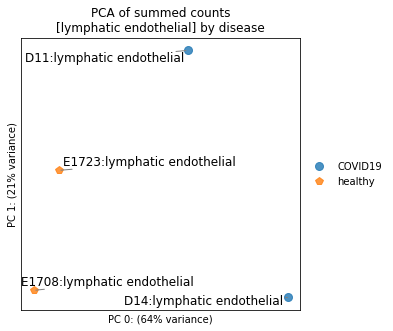

R[write to console]: After trimming genes, summed counts matrix: [6559, 4]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [4, 6]

R[write to console]: WARNING: experimental design is degenerate, since there are fewer rows than columns+1 in the design matrix.
https://support.bioconductor.org/p/59168/ 
Aborting this test!




Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...
Working on cluster group "immune" ========================================

total cells in group = 1884

cells per "disease":
healthy    1281
COVID19     603
Name: disease, dtype: int64
 
cells per "individual_cluster":
TH5:immune      316
TH6:immune      157
D15:immune      141
T3:immune       119
E1723:immune    108
TH7:immune      102
TH2:immune       96
T1:immune        63
TH3:immune       62
TH4:immune       59
D16:immune       53
D2:immune        51
D4:immune        51
D27:immune       48
T6:immune        45
D32:immune       45
T2:immune        42
E1666:immune     39
D7:immune        37
D5:immune        36
D17:immune       32
T7:immune        30
D10:immune       26
D8:immune        24
T5:immune        23
D11:immune       23
D28:immune       19
D14:immune       13
T4:immune        12
T11:immune        3
E1708:immune      3
D1:immune         2
E1681:immune      2
D31:immune        1
D3:immu

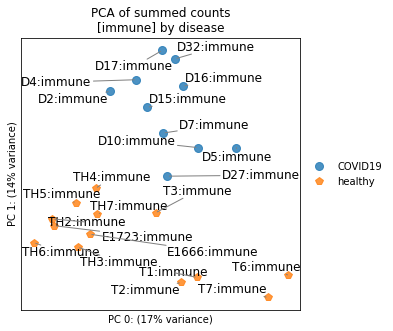

R[write to console]: After trimming genes, summed counts matrix: [5500, 23]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [23, 7]



Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


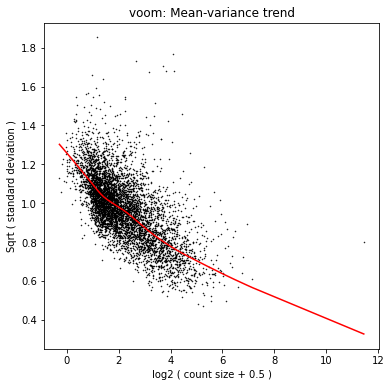

Contrast COVID19 vs. healthy
number of cells in COVID19 = 603
number of cells in healthy = 1281


Saved grouping ['immune'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_immune_DE.tsv

Working on cluster group "vascular endothelial" ========================================

total cells in group = 22438

cells per "disease":
healthy    11626
COVID19    10812
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1666:vascular endothelial    2320
D1:vascular endothelial       2002
D2:vascular endothelial       1454
D7:vascular endothelial       1274
TH3:vascular endothelial      1157
TH2:vascular endothelial      1156
D4:vascular endothelial       1149
D11:vascular endothelial      1070
T3:vascular endothelial        833
D15:vascular endothelial       826
D8:vascular endothelial        806
E1723:vascular endothelial     634
E1681:vascular endothelial     619
D10:vascular endothelial       558
T7:vascular endothelial        557
D16:vascular endothelial       553
TH4:vascular endothelial       551
TH7:vascular endothelial       534
TH5:vascular endothelial       508


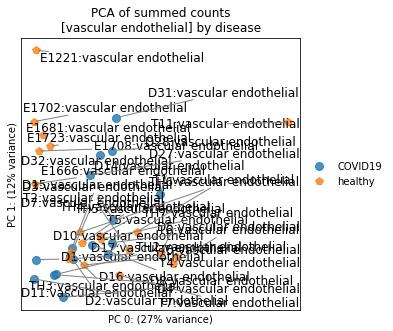

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [13073, 37]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [37, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


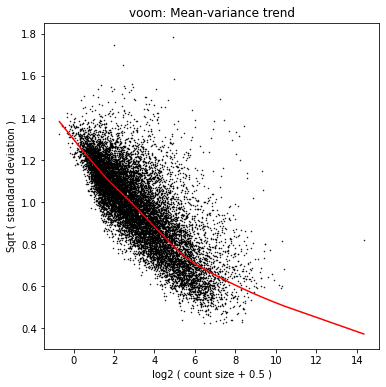

Contrast COVID19 vs. healthy
number of cells in COVID19 = 10812
number of cells in healthy = 11626


Saved grouping ['vascular endothelial'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_vascular endothelial_DE.tsv

Working on cluster group "macrophage" ========================================

total cells in group = 6986

cells per "disease":
healthy    5411
COVID19    1575
Name: disease, dtype: int64
 
cells per "individual_cluster":
T3:macrophage       856
E1723:macrophage    793
E1666:macrophage    624
T2:macrophage       475
E1708:macrophage    329
D15:macrophage      315
E1681:macrophage    288
TH7:macrophage      268
TH2:macrophage      268
D1:macrophage       261
T5:macrophage       255
T7:macrophage       208
D27:macrophage      193
TH3:macrophage      181
D2:macrophage       173
TH4:macrophage      157
TH6:macrophage      144
D4:macrophage       143
TH5:macrophage      142
T4:macrophage       131
T1:macrophage       108
D7:macrophage        93
D16:macrophage       80
D28:macrophage       79
E1221:macrophage     78
T6:macrophage        75
D32:macrophage       55
D1

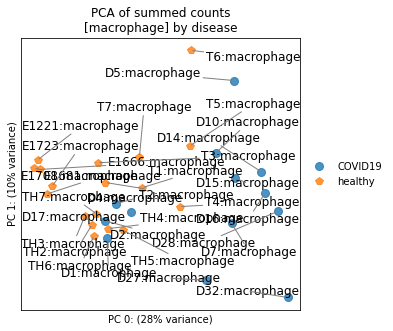

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [9601, 31]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [31, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


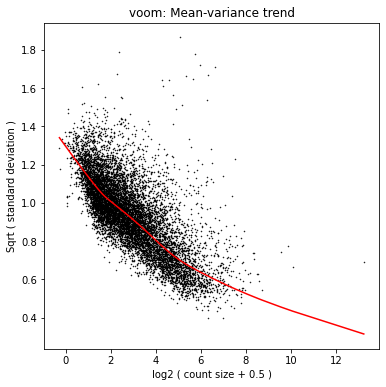

Contrast COVID19 vs. healthy
number of cells in COVID19 = 1575
number of cells in healthy = 5411


Saved grouping ['macrophage'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_macrophage_DE.tsv

Working on cluster group "adipocyte" ========================================

total cells in group = 1452

cells per "disease":
healthy    1330
COVID19     122
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1708:adipocyte    474
E1723:adipocyte    317
TH6:adipocyte       75
E1221:adipocyte     64
T5:adipocyte        58
T2:adipocyte        46
TH3:adipocyte       45
D17:adipocyte       41
TH7:adipocyte       39
TH2:adipocyte       37
TH5:adipocyte       32
E1666:adipocyte     31
D4:adipocyte        26
T3:adipocyte        23
TH4:adipocyte       21
E1702:adipocyte     21
T4:adipocyte        16
T1:adipocyte        16
E1681:adipocyte     13
D2:adipocyte         9
D28:adipocyte        7
D1:adipocyte         6
D14:adipocyte        6
D27:adipocyte        5
D10:adipocyte        5
D3:adipocyte         4
D8:adipocyte         3
D31:adipocyte        2
D15:adipocyte        2
D11:

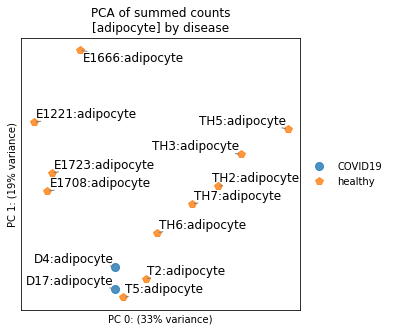

R[write to console]: After trimming genes, summed counts matrix: [9314, 13]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [13, 7]



Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


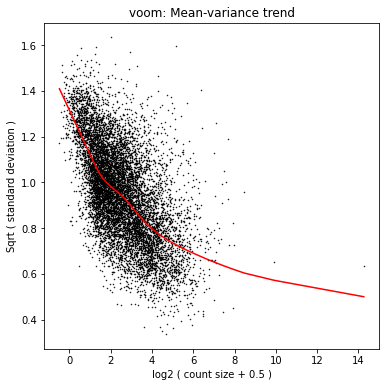

Contrast COVID19 vs. healthy
number of cells in COVID19 = 122
number of cells in healthy = 1330


Saved grouping ['adipocyte'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_adipocyte_DE.tsv

Background RNA probabilities have not been calculated since calculate_background_estimate=False. If you want to try to calculate bkg.prob on your own, it is recommended to try:

df = calculate_bkg_prob(full_adata_with_all_cells_included,
                        testing_key=testing_key,
                        df=df,  # this is from limma_voom_DE()
                        separate_groupings_column=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        separate_groupings_key=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        bcs_included=adata.obs.index)



In [32]:
# use count data
adata.X = adata.layers['counts']

# run method
df = limma_voom_DE(
    adata,
    summation_key='individual_cluster',
    separate_groupings_key='cluster',
    testing_key='disease',
    model='~ 0 + disease + study + version10x + sex',
    model_keys=['disease', 'study', 'version10x', 'sex'],
    one_versus_all_contrasts=False,
    additional_contrasts=['COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy'],
    min_cells_per_test_group=25,
    duplicate_correlation_key=None,
#     separate_groupings='',
    working_directory='/home/jupyter-user/analysis/meta/DE/tmp',
    low_expression_mean_threshold=2.0,
    voom_function='voomWithQualityWeights',
    voom_lowess_span=0.5,
    calculate_background_estimate=False,
#     gene_id_key='gene_id',
    create_PCA_plot=True,
    label_PCA_plot=True,
    verbose=True,
)

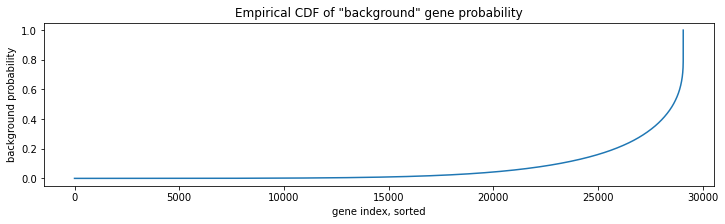

Gene most probable to be background RNA is 
highly_variable                    False
means                            6.30846
dispersions                       5.1729
dispersions_norm                       1
highly_variable_nbatches               0
highly_variable_intersection       False
gene_bkg_prob                   0.999994
Name: MALAT1, dtype: object


Unique conditions under which bkg.prob will be computed:
['cardiomyocyte:::COVID19_healthy' 'fibroblast:::COVID19_healthy'
 'pericyte:::COVID19_healthy' 'vsmc:::COVID19_healthy'
 'immune:::COVID19_healthy' 'vascular endothelial:::COVID19_healthy'
 'macrophage:::COVID19_healthy' 'adipocyte:::COVID19_healthy']
Working on grouping ['cardiomyocyte']
Working on test conditions that include ['COVID19', 'healthy']
104182 cells
Working on grouping ['fibroblast']
Working on test conditions that include ['COVID19', 'healthy']
39142 cells
Working on grouping ['pericyte']
Working on test conditions that include ['COVID19', 'healthy']
31001 cel

In [33]:
df = calculate_bkg_prob(adata,
                        testing_key='disease',
                        df=df,
                        separate_groupings_column='cluster',
                        separate_groupings_key='cluster',
                        bcs_included=adata.obs.index)

In [34]:
df

gene        cluster test.group comparison     logFC   AveExpr  \
0          PLCG2  cardiomyocyte    COVID19    healthy  4.927837  4.127685   
1        NDUFAF4  cardiomyocyte    COVID19    healthy -3.054964  3.344968   
2        FAM173A  cardiomyocyte    COVID19    healthy -3.537947  0.724291   
3         EXOSC8  cardiomyocyte    COVID19    healthy -2.792687  2.691533   
4           COQ6  cardiomyocyte    COVID19    healthy -2.290361  2.576831   
...          ...            ...        ...        ...       ...       ...   
96944       DGKB      adipocyte    COVID19    healthy -0.001838  2.518371   
96945  RPL34-AS1      adipocyte    COVID19    healthy  0.000437  2.704176   
96946      CDIPT      adipocyte    COVID19    healthy  0.000532  2.678282   
96947    DCUN1D2      adipocyte    COVID19    healthy  0.000343  3.571545   
96948       PTX3      adipocyte    COVID19    healthy -0.000444  2.665001   

               t       P.Value     adj.P.Val          B  ...  \
0      15.128184  1.282908e-16  2.663060e-12  27.762225  ...   
1     -12.678636  2.105392e-14  2.185186e-10  22.524909  ...   
2     -12.067144  8.347113e-14  5.775645e-10  21.047245  ...   
3     -11.635289  2.268605e-13  1.177293e-09  20.274164  ...   
4     -11.045097  9.234320e-13  3.833720e-09  18.961168  ...   
...          ...           ...           ...        ...  ...   
96944  -0.001281  9.989912e-01  9.994204e-01  -5.551826  ...   
96945   0.000455  9.996414e-01  9.997739e-01  -5.641862  ...   
96946   0.000455  9.996415e-01  9.997739e-01  -5.600184  ...   
96947   0.000383  9.996984e-01  9.997739e-01  -5.769344  ...   
96948  -0.000287  9.997739e-01  9.997739e-01  -5.491831  ...   

       comparison.frac.expr>0  test.group.frac.expr>1  comparison.frac.expr>1  \
0                    0.030475                0.296660                0.001909   
1                    0.147101                0.003082                0.023445   
2                    0.078156                0.000666                0.008874   
3                    0.110008                0.001249                0.012932   
4                    0.083819                0.001499                0.008115   
...                       ...                     ...                     ...   
96944                0.070677                0.016393                0.017293   
96945                0.031579                0.016393                0.001504   
96946                0.054887                0.008197                0.004511   
96947                0.100752                0.073770                0.015789   
96948                0.034586                0.000000                0.012782   

       bkg.prob  PPV.expr>0  PPV.expr>1  frac.cells.in.group.expr>0  \
0      0.190681    0.367607    0.367901                    0.088096   
1      0.019709    0.811074    0.913000                    0.134169   
2      0.012424    0.765969    0.898364                    0.070694   
3      0.032213    0.674891    0.795796                    0.100017   
4      0.014911    0.758911    0.873289                    0.077259   
...         ...         ...         ...                         ...   
96944  0.044143    0.563126    0.592360                    0.068871   
96945  0.054002    0.412589    0.282911                    0.033747   
96946  0.015213    0.617128    0.760095                    0.053719   
96947  0.162483    0.416798    0.355722                    0.108127   
96948  0.005900    0.772801    0.784278                    0.032369   

       frac.cells.out.group.expr>0  frac.cells.in.group.expr>1  \
0                         0.151541                    0.035880   
1                         0.031242                    0.021098   
2                         0.021589                    0.007928   
3                         0.048170                    0.011585   
4                         0.024533                    0.007353   
...                            ...                         ...   
96944                     0.05

In [35]:
df.columns

Index(['gene', 'cluster', 'test.group', 'comparison', 'logFC', 'AveExpr', 't',
       'P.Value', 'adj.P.Val', 'B', 'test.group.cell.mean.counts',
       'comparison.cell.mean.counts', 'test.group.frac.expr>0',
       'comparison.frac.expr>0', 'test.group.frac.expr>1',
       'comparison.frac.expr>1', 'bkg.prob', 'PPV.expr>0', 'PPV.expr>1',
       'frac.cells.in.group.expr>0', 'frac.cells.out.group.expr>0',
       'frac.cells.in.group.expr>1', 'frac.cells.out.group.expr>1'],
      dtype='object')

In [39]:
df.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210204.csv')

In [38]:
df[['gene', 'cluster', 'test.group', 'comparison', 'logFC', 'AveExpr', 't',
       'P.Value', 'adj.P.Val', 'B', 'test.group.cell.mean.counts',
       'comparison.cell.mean.counts', 'test.group.frac.expr>0',
       'comparison.frac.expr>0', 'test.group.frac.expr>1',
       'comparison.frac.expr>1', 'bkg.prob']][df['adj.P.Val'] <= 0.05]\
.sort_values(by=['cluster', 'logFC'], ascending=[True, False])\
.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210204_summary.csv')

## Run DE regardless of cell type... sum all cells from an individual donor

This is a sanity check.

Working on the entire dataset at once ========================================

total cells in group = 210232

cells per "disease":
healthy    169352
COVID19     40880
Name: disease, dtype: int64
 
cells per "individual":
E1723    17620
E1681    16401
E1666    13451
TH6      13138
TH3      12302
TH5      10356
D1       10257
E1708     9990
T2        8953
T3        8826
TH4       8492
T1        8429
TH2       8196
TH7       8107
T5        5971
D2        5832
T4        4951
E1702     4305
T7        4073
D7        3538
E1221     3515
D4        3347
D15       2957
D11       2384
D27       2006
T6        1922
D8        1670
D16       1620
D10       1431
D17       1391
D5        1300
D28       1108
D32        818
D14        677
T11        354
D31        286
D3         219
D6          39
Name: individual, dtype: int64
 
Summing adata.X per "individual": 38 unique groups
......................................
The following groupings yield fewer than 25 cells:
[]
Done summing counts.



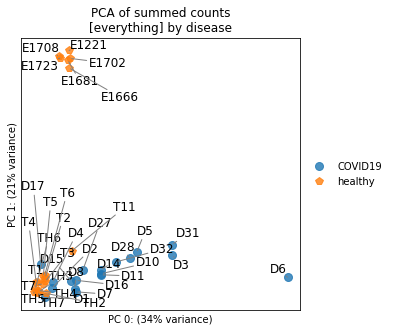

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [22224, 38]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [38, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


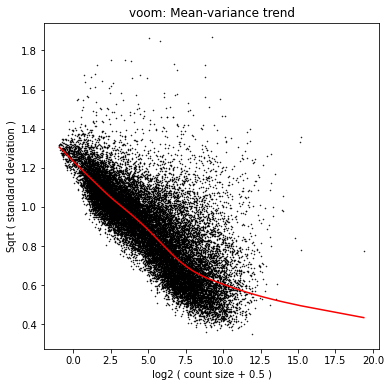

Contrast COVID19 vs. healthy
number of cells in COVID19 = 40880
number of cells in healthy = 169352


Saved grouping ['everything'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_everything_DE.tsv

Background RNA probabilities have not been calculated since calculate_background_estimate=False. If you want to try to calculate bkg.prob on your own, it is recommended to try:

df = calculate_bkg_prob(full_adata_with_all_cells_included,
                        testing_key=testing_key,
                        df=df,  # this is from limma_voom_DE()
                        separate_groupings_column=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        separate_groupings_key=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        bcs_included=adata.obs.index)



In [43]:
# use count data
adata.X = adata.layers['counts']

# run method
df_overall = limma_voom_DE(
    adata,
    summation_key='individual',
    separate_groupings_key=None,
    testing_key='disease',
    model='~ 0 + disease + study + version10x + sex',
    model_keys=['disease', 'study', 'version10x', 'sex'],
    one_versus_all_contrasts=False,
    additional_contrasts=['COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy'],
    min_cells_per_test_group=25,
    duplicate_correlation_key=None,
#     separate_groupings='',
    working_directory='/home/jupyter-user/analysis/meta/DE/tmp',
    low_expression_mean_threshold=2.0,
    voom_function='voomWithQualityWeights',
    voom_lowess_span=0.5,
    calculate_background_estimate=False,
#     gene_id_key='gene_id',
    create_PCA_plot=True,
    label_PCA_plot=True,
    verbose=True,
)

In [45]:
df_overall[((df_overall['test.group.cell.mean.counts'] > 0.05)
             | (df_overall['comparison.cell.mean.counts'] > 0.05))
           & (df_overall['adj.P.Val'] < 0.01)]\
.sort_values(by='logFC', ascending=False).head(20)

gene clusters.included test.group comparison     logFC   AveExpr  \
5221         HBB        everything    COVID19    healthy  7.330582 -0.420049   
4568        HBA2        everything    COVID19    healthy  6.738555 -1.448967   
3          VEGFC        everything    COVID19    healthy  4.933867  3.691615   
0          PLCG2        everything    COVID19    healthy  4.810055  4.907561   
357         RPS3        everything    COVID19    healthy  4.513418  3.573213   
136       RPL13A        everything    COVID19    healthy  4.387007  4.025772   
1296  AC007952.4        everything    COVID19    healthy  4.352802 -0.291197   
94         RPS19        everything    COVID19    healthy  4.350207  3.994473   
1186       RPS11        everything    COVID19    healthy  4.193641  2.875998   
187       RPL37A        everything    COVID19    healthy  4.189562  3.891623   
5018        PTX3        everything    COVID19    healthy  4.105238  0.814183   
240       IFITM2        everything    COVID19    healthy  3.980482  3.464438   
286       PCAT19        everything    COVID19    healthy  3.933079  2.533850   
1993        EGR1        everything    COVID19    healthy  3.920781  3.077086   
2802       THBS1        everything    COVID19    healthy  3.857349  4.693123   
175         EEF2        everything    COVID19    healthy  3.840812  4.199270   
364       ADGRL4        everything    COVID19    healthy  3.830828  4.359827   
895       IGFBP3        everything    COVID19    healthy  3.770148  3.024009   
468       KCTD12        everything    COVID19    healthy  3.768343  2.326411   
462        RPS20        everything    COVID19    healthy  3.736612  2.640513   

              t       P.Value     adj.P.Val          B  \
5221   4.158788  1.951001e-04  8.303149e-04   0.638560   
4568   4.428937  8.790929e-05  4.275982e-04   1.415886   
3     14.400966  7.862883e-17  4.368618e-13  28.176512   
0     18.653040  1.585683e-20  3.524023e-16  36.544161   
357    8.659192  2.400784e-10  1.490364e-08  13.592210   
136    9.904536  6.773208e-12  1.096980e-09  17.087859   
1296   6.591414  9.920110e-08  1.699804e-06   7.771956   
94    10.243040  2.667801e-12  6.240970e-10  18.002013   
1186   6.779645  6.335103e-08  1.184622e-06   8.164489   
187    9.483829  2.138496e-11  2.527975e-09  15.955297   
5018   4.235994  1.550613e-04  6.866075e-04   0.731611   
240    9.191691  4.914094e-11  4.531569e-09  15.125716   
286    8.883278  1.029605e-10  7.972802e-09  14.422837   
1993   5.959254  8.443824e-07  9.411010e-06   5.561226   
2802   5.352877  5.418012e-06  4.295751e-05   3.568289   
175    9.607146  1.455575e-11  1.837994e-09  16.323615   
364    8.641282  2.547438e-10  1.551076e-08  13.476000   
895    7.250641  1.509831e-08  3.744919e-07   9.504765   
468    8.208429  7.352293e-10  3.477669e-08  12.504680   
462    8.217650  6.897095e-10  3.310606e-08  12.567587   

      test.group.cell.mean.counts  comparison.cell.mean.counts  \
5221                     0.284958                     0.002421   
4568                     0.070083                     0.000998   
3                        0.322071                     0.019072   
0                        1.122352                     0.036450   
357                      0.123015                     0.054293   
136                      0.132287                     0.093787   
1296                     0.052714                     0.002179   
94                       0.164360                     0.062471   
1186                     0.062866                     0.045549   
187                      0.147869                     0.075772   
5018                     0.071330                     0.008060   
240                      0.120545                     0.045413   
286                      0.094959                     0.011514   
1993                     0.136961                     0.023690   
2802                     1.018604                     0.104650   
175                      0.166902                     0.

In [55]:
sc.pp.normalize_total(adata)

... storing 'cluster_disease' as categorical


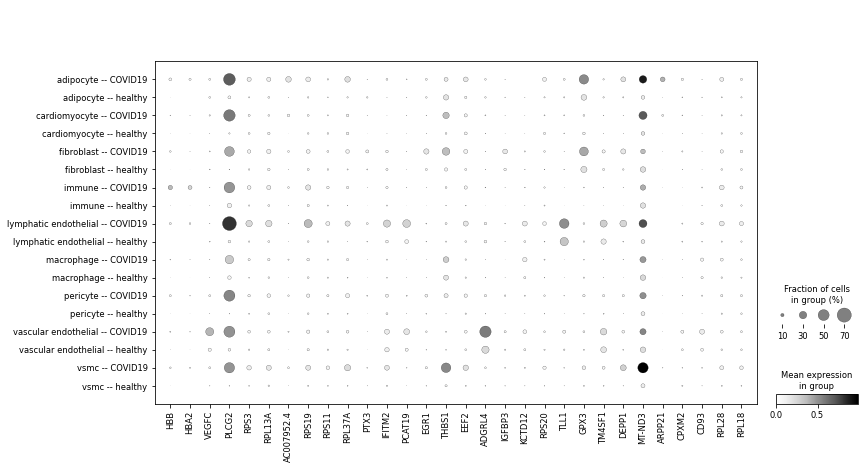

In [56]:
genes = df_overall[((df_overall['test.group.cell.mean.counts'] > 0.05)
                     | (df_overall['comparison.cell.mean.counts'] > 0.05))
                   & (df_overall['adj.P.Val'] < 0.01)]\
        .sort_values(by='logFC', ascending=False).head(30)['gene'].tolist()

adata.obs['cluster_disease'] = (adata.obs['cluster'].astype(str) 
                                + ' -- ' + adata.obs['disease'].astype(str))

sc.pl.dotplot(adata,
              groupby='cluster_disease',
              var_names=genes,
#               standard_scale='var',
              log=True,
              color_map='Greys',
              smallest_dot=15)

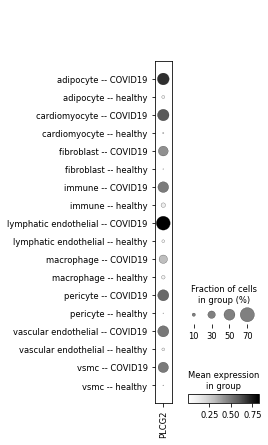

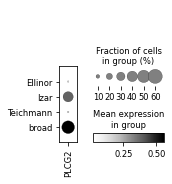

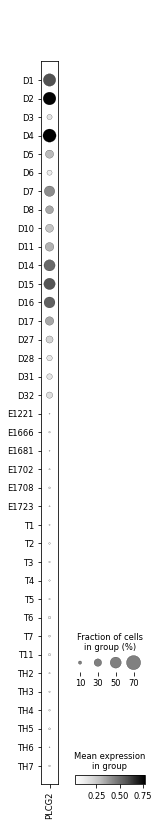

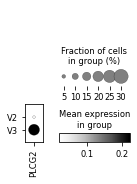

In [64]:
for group in ['cluster_disease', 'study', 'individual', 'version10x']:

    sc.pl.dotplot(adata,
                  groupby=group,
                  var_names=['PLCG2'],
    #               standard_scale='var',
                  log=True,
                  color_map='Greys',
                  smallest_dot=15)

PLCG2 is totally out of control in COVID19.

In [57]:
adata.var_names[adata.var_names.str.startswith('HSP')]

Index(['HSP90AA1', 'HSP90AB1', 'HSP90B1', 'HSPA12A', 'HSPA12B', 'HSPA13',
       'HSPA14_ENSG00000187522', 'HSPA1A', 'HSPA1B', 'HSPA1L', 'HSPA2',
       'HSPA4', 'HSPA4L', 'HSPA5', 'HSPA6', 'HSPA8', 'HSPA9', 'HSPB1',
       'HSPB11', 'HSPB2', 'HSPB2-C11orf52', 'HSPB3', 'HSPB6', 'HSPB7', 'HSPB8',
       'HSPB9', 'HSPBAP1', 'HSPBP1', 'HSPD1', 'HSPE1', 'HSPE1-MOB4', 'HSPG2',
       'HSPH1'],
      dtype='object', name='featurekey')

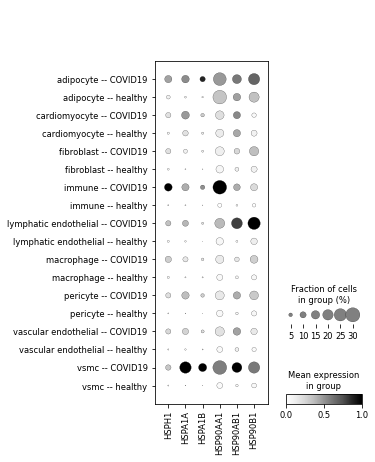

In [58]:
# the heat shock proteins seem to appear

genes = ['HSPH1', 'HSPA1A', 'HSPA1B', 'HSP90AA1', 'HSP90AB1', 'HSP90B1']

sc.pl.dotplot(adata,
              groupby='cluster_disease',
              var_names=genes,
              standard_scale='var',
#               log=True,
              color_map='Greys',
              smallest_dot=15)

## Exploration

In [ ]:
df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210204.csv')

## Extended Data Figure 11g, 11h, 11i

In [ ]:
for k in df['cluster'].unique():
    
    volcano_plot(df[((df['test.group.cell.mean.counts'] > 0.05)
                      | (df['comparison.cell.mean.counts'] > 0.05))], 
                 FDR=0.01, 
                 cluster_column_label='cluster',
                 cluster_value=k,
                 test_group_value='COVID19',
                 comparison_value='healthy',
                 num=6,
                 title=f'COVID19 vs. healthy\n{k}: FDR 0.01',
                 show=False,
                 figsize=(4, 5),
                 xlim=(-9, 9),
                 fontsize=10,
                 )
    plt.ylim(top=17)
    plt.tight_layout()
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_{k}_volcano.pdf')
    plt.show()

In [ ]:
# umaps

sc.set_figure_params(vector_friendly=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sc.pl.embedding(adata[adata.obs['disease'] == 'COVID19'], 
                basis='umap', ax=plt.gca(), show=False)
plt.subplot(1, 2, 2)
sc.pl.embedding(adata[adata.obs['disease'] == 'healthy'], 
                basis='umap', ax=plt.gca(), show=False)
plt.show()

for g in ['PLCG2', 'HIVEP2', 'AFDN']:
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sc.pl.embedding(adata[adata.obs['disease'] == 'COVID19'], 
                    basis='umap', color=g, color_map='Oranges', size=10, alpha=0.5,
                    vmax=10, ax=plt.gca(), show=False)
    plt.title(f'{g}: COVID19 data')
    plt.subplot(1, 2, 2)
    sc.pl.embedding(adata[adata.obs['disease'] == 'healthy'], 
                    basis='umap', color=g, color_map='Oranges', size=10, alpha=0.5,
                    vmax=10, ax=plt.gca(), show=False)
    plt.title(f'{g}: healthy data')
    
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_{g}_umaps.pdf')
    
    plt.show()

In [ ]:
plt.figure(figsize=(7, 5))
sc.pl.embedding(adata, 
                basis='umap', color='cluster', color_map='Oranges', size=1, alpha=0.5,
                vmax=10, ax=plt.gca(), show=False)
plt.title(f'Cell types')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_meta_cluster_umap.pdf')

plt.show()

plt.figure(figsize=(7, 5))
sc.pl.embedding(adata, 
                basis='umap', color='study', color_map='Oranges', size=1, alpha=0.5,
                vmax=10, ax=plt.gca(), show=False)
plt.title(f'Cell types')

plt.tight_layout()
plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_meta_study_umap.pdf')

plt.show()

In [ ]:
all_volcano_plots(df[((df['test.group.cell.mean.counts'] > 0.05)
                      | (df['comparison.cell.mean.counts'] > 0.05))], 
                  FDR=0.01, 
                  cluster_column_name='cluster',
                  num=8)

## GSEA

In [3]:
df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210204.csv')

In [4]:
gsea_df = gsea_from_DE(
    df,
    gmt_files=['/home/jupyter-user/analysis/meta/c5.go.bp.v7.2.symbols.gmt',
               '/home/jupyter-user/analysis/meta/c5.go.mf.v7.2.symbols.gmt'],
#                '/home/jupyter-user/analysis/meta/c7.all.v7.2.symbols.gmt',
#                '/home/jupyter-user/analysis/meta/c8.all.v7.2.symbols.gmt'],
    bkg_prob_cutoff=0.4,
    separate_groupings_column='cluster',
    gene_key='gene',
    ranking_key='t',
)

Within "cardiomyocyte", working on COVID19 vs. healthy..
Within "fibroblast", working on COVID19 vs. healthy..
Within "pericyte", working on COVID19 vs. healthy..
Within "vsmc", working on COVID19 vs. healthy..
Within "immune", working on COVID19 vs. healthy..
Within "vascular endothelial", working on COVID19 vs. healthy..
Within "macrophage", working on COVID19 vs. healthy..
Within "adipocyte", working on COVID19 vs. healthy..


In [5]:
# gsea_df.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_GSEA_20210204.csv')

In [3]:
gsea_df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_GSEA_20210204.csv')

In [4]:
gsea_df.head()

Unnamed: 0        cluster test.group comparison  \
0           0  cardiomyocyte    COVID19    healthy   
1           1  cardiomyocyte    COVID19    healthy   
2           2  cardiomyocyte    COVID19    healthy   
3           3  cardiomyocyte    COVID19    healthy   
4           4  cardiomyocyte    COVID19    healthy   

                                             pathway      pval      padj  \
0  GO_REGULATION_OF_B_CELL_RECEPTOR_SIGNALING_PAT...  0.000007  0.000439   
1                          GO_CELLULAR_EXTRAVASATION  0.000003  0.000318   
2  GO_CELL_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHE...  0.000003  0.000318   
3               GO_B_CELL_RECEPTOR_SIGNALING_PATHWAY  0.000003  0.000318   
4                             GO_LEUKOCYTE_MIGRATION  0.000004  0.000318   

         ES       NES  nMoreExtreme  size  \
0  0.667580  2.327015           2.0    23   
1  0.536307  2.318657           0.0    54   
2  0.425428  2.303514           0.0   185   
3  0.534787  2.292972           0.0    52   
4  0.387970  2.260656           0.0   330   

                                         leadingEdge  
0  PAX5|SLC39A10|LYN|PRKCH|CD22|RUNX1|ELF1|CD300A...  
1  IL1R1|SIRPA|AZU1|PIK3CD|GCNT1|FER|BCR|PLVAP|PE...  
2  IL1RAP|TENM4|GPC4|TGFB2|EFNA5|MAG|PTPRT|ITGA5|...  
3  PLCG2|PAX5|KLHL6|SLC39A10|LYN|PIK3CD|PRKCH|CD7...  
4  THBS1|IL1R1|OXSR1|MSN|TGFB2|ADAM10|VEGFC|MAG|H...

In [5]:
gsea_df[(gsea_df['cluster'] == 'cardiomyocyte') 
        & (gsea_df['padj'] < 0.01) 
        & (gsea_df['NES'] < 0)].sort_values(by='NES', ascending=True).head()

Unnamed: 0        cluster test.group comparison  \
7338        7338  cardiomyocyte    COVID19    healthy   
7337        7337  cardiomyocyte    COVID19    healthy   
7336        7336  cardiomyocyte    COVID19    healthy   
7335        7335  cardiomyocyte    COVID19    healthy   
7334        7334  cardiomyocyte    COVID19    healthy   

                                         pathway      pval     padj        ES  \
7338            GO_MITOCHONDRIAL_GENE_EXPRESSION  0.000001  0.00027 -0.652708   
7337                GO_MITOCHONDRIAL_TRANSLATION  0.000002  0.00027 -0.669416   
7336  GO_MITOCHONDRIAL_TRANSLATIONAL_TERMINATION  0.000002  0.00027 -0.709238   
7335                GO_TRANSLATIONAL_TERMINATION  0.000002  0.00027 -0.665253   
7334                 GO_TRANSLATIONAL_ELONGATION  0.000002  0.00027 -0.612155   

           NES  nMoreExtreme  size  \
7338 -3.166818           0.0   154   
7337 -3.155928           0.0   127   
7336 -3.127362           0.0    85   
7335 -3.018263           0.0   100   
7334 -2.882487           0.0   126   

                                            leadingEdge  
7338  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|TACO...  
7337  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|TACO...  
7336  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|MRPL...  
7335  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|MRPL...  
7334  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|MRPL...

In [6]:
gsea_df[(gsea_df['cluster'] == 'cardiomyocyte') 
        & (gsea_df['padj'] < 0.01) 
        & (gsea_df['NES'] > 0)].sort_values(by='NES', ascending=False).head()

Unnamed: 0        cluster test.group comparison  \
0           0  cardiomyocyte    COVID19    healthy   
1           1  cardiomyocyte    COVID19    healthy   
2           2  cardiomyocyte    COVID19    healthy   
3           3  cardiomyocyte    COVID19    healthy   
4           4  cardiomyocyte    COVID19    healthy   

                                             pathway      pval      padj  \
0  GO_REGULATION_OF_B_CELL_RECEPTOR_SIGNALING_PAT...  0.000007  0.000439   
1                          GO_CELLULAR_EXTRAVASATION  0.000003  0.000318   
2  GO_CELL_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHE...  0.000003  0.000318   
3               GO_B_CELL_RECEPTOR_SIGNALING_PATHWAY  0.000003  0.000318   
4                             GO_LEUKOCYTE_MIGRATION  0.000004  0.000318   

         ES       NES  nMoreExtreme  size  \
0  0.667580  2.327015           2.0    23   
1  0.536307  2.318657           0.0    54   
2  0.425428  2.303514           0.0   185   
3  0.534787  2.292972           0.0    52   
4  0.387970  2.260656           0.0   330   

                                         leadingEdge  
0  PAX5|SLC39A10|LYN|PRKCH|CD22|RUNX1|ELF1|CD300A...  
1  IL1R1|SIRPA|AZU1|PIK3CD|GCNT1|FER|BCR|PLVAP|PE...  
2  IL1RAP|TENM4|GPC4|TGFB2|EFNA5|MAG|PTPRT|ITGA5|...  
3  PLCG2|PAX5|KLHL6|SLC39A10|LYN|PIK3CD|PRKCH|CD7...  
4  THBS1|IL1R1|OXSR1|MSN|TGFB2|ADAM10|VEGFC|MAG|H...

In [9]:
gsea_df[(gsea_df['pathway'] == 'GO_VIRAL_GENE_EXPRESSION')
        & (gsea_df['padj'] <= 0.01)].sort_values(by='NES', ascending=False)

Unnamed: 0               cluster test.group comparison  \
35985           6                immune    COVID19    healthy   
62551           4             adipocyte    COVID19    healthy   
27057          15                  vsmc    COVID19    healthy   
18049          33              pericyte    COVID19    healthy   
44648          55  vascular endothelial    COVID19    healthy   

                        pathway      pval      padj        ES       NES  \
35985  GO_VIRAL_GENE_EXPRESSION  0.000002  0.000340  0.640856  2.847057   
62551  GO_VIRAL_GENE_EXPRESSION  0.000002  0.001080  0.476725  2.263784   
27057  GO_VIRAL_GENE_EXPRESSION  0.000002  0.000265  0.467205  2.181839   
18049  GO_VIRAL_GENE_EXPRESSION  0.000005  0.000711  0.416497  2.132503   
44648  GO_VIRAL_GENE_EXPRESSION  0.000007  0.001516  0.379241  1.894239   

       nMoreExtreme  size                                        leadingEdge  
35985           0.0   133  RPS15|RPL27|RPL37A|RPL28|RPS9|RPL27A|RPL7A|RPS...  
62551           0.0   147  RPL28|RPS19|RPS24|RPL37A|RPL13A|RPS9|RPS2|RPS1...  
27057           0.0   160  RPL37A|RPS19|RPS15A|IFITM3|RPL13A|RPL13|RPS9|R...  
18049           0.0   178  RPL37A|RPS19|RPS15A|RPL13|RPS9|RPL13A|RPL18A|R...  
44648           1.0   178  RPL37A|NUCKS1|RPL18|RPS9|RPS24|RPL37|RPL13A|RP...

In [15]:
pd.Series('|'.join(gsea_df[(gsea_df['pathway'] == 'GO_VIRAL_GENE_EXPRESSION')
        & (gsea_df['padj'] <= 0.01)].sort_values(by='NES', ascending=False)['leadingEdge']\
    .values.tolist()).split('|')).value_counts().head(50)

RPL23A    5
RPL41     5
RPS24     5
RPL28     5
RPL14     5
RPL37     5
RPL3      5
RPS6      5
RPL11     5
RPL7A     5
RPL34     5
RPS15     5
RPL13A    5
RPS16     5
RPS19     5
RPL8      5
RPL27A    5
RPL18     5
RPS4X     5
RPL15     5
RPLP1     5
RPL37A    5
CHD1      5
RPL7      5
RPS9      5
RPS3      5
RPL19     5
RPS25     5
RPL13     5
RPS5      4
RPS12     4
RPL10A    4
RPS23     4
EIF3A     4
MID2      4
NUCKS1    4
EIF3L     4
RPS15A    4
RPS18     4
RPL23     4
RPL27     4
RPS11     4
RPL38     4
RPL35     4
RPL21     4
IFITM3    4
RPSA      4
RPL29     4
RPS20     4
RPLP2     3
dtype: int64

Maybe interesting, maybe not... this could be ribosomal transcripts from cytoplasmic contamination?

In [ ]:
for cluster in gsea_df['cluster'].unique():
    
    print(cluster, '===============================')

#     plot_pathway_heatmap(
#         gsea_df[gsea_df['cluster'] == cluster],
#         fdr=0.01,
#         max_per_group=30,
#     #     sort_by=['NES'],
#     #     test_group_order: Union[List[str], NoneType] = None,
#     #     test_group_mapping: Union[Dict[str, str], NoneType] = None,
#         p_value_style='both',
#         size_legend_values=[1, 2, 4, 6],
#         colorbar_aspect=10,
#         fontsize=10,
#         vmin=-2.5,
#         vmax=2.5,
#         show=False,
#     )
#     plt.show()
    
    plot_pathway_bars(
        gsea_df[gsea_df['cluster'] == cluster], 
        fdr=0.01,
        n_pathways=15,
        enriched_only=False,
        labels_on_top=True,
        figsize=(12, 4),
        fontsize=16,
        asterisk_size=8,
#         pathway_name_fcn=lambda s: s,
        show=False,
    )
    
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_{cluster}_gsea_bar.pdf',
                      bbox_inches='tight')
    
    plt.show()

## Additional cell QC first

In [17]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF.h5ad')

In [18]:
adata

AnnData object with n_obs × n_vars = 210232 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method', 'individual_class', 'cluster', 'individual_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'hvg', 'individual_colors', 'method_colors', 'neighbors', 'pca', 'study_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [19]:
adata.obs['doublet'].value_counts()

nan      169352
False     40880
Name: doublet, dtype: int64

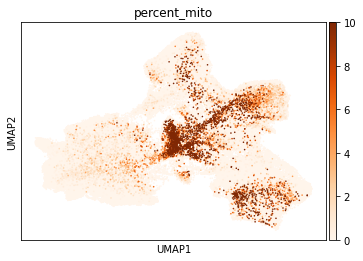

In [22]:
sc.pl.embedding(adata, basis='umap', color='percent_mito', 
                color_map='Oranges', size=10, vmax=10)

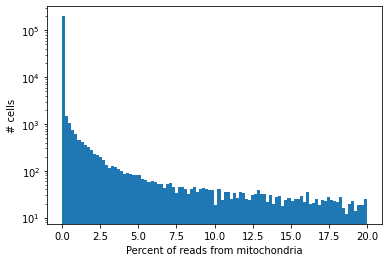

In [24]:
plt.hist(adata.obs['percent_mito'].values, bins=100)
plt.ylabel('# cells')
plt.xlabel('Percent of reads from mitochondria')
plt.yscale('log')
plt.show()

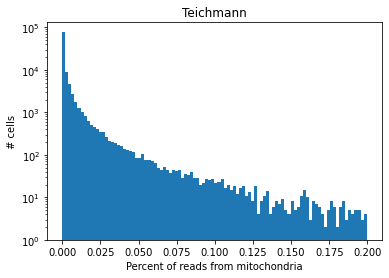

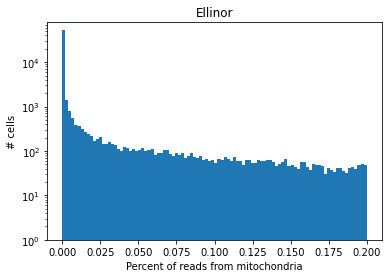

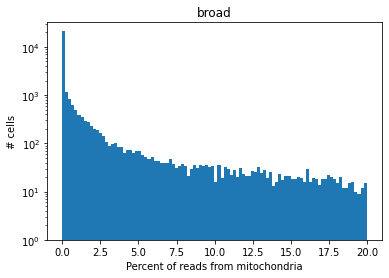

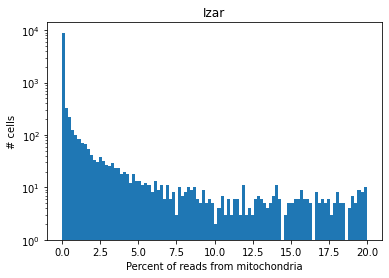

In [26]:
for study in adata.obs['study'].unique():
    
    plt.hist(adata.obs['percent_mito'].values[adata.obs['study'] == study], bins=100)
    plt.ylabel('# cells')
    plt.xlabel('Percent of reads from mitochondria')
    plt.yscale('log')
    plt.ylim(bottom=1)
    plt.title(study)
    plt.show()

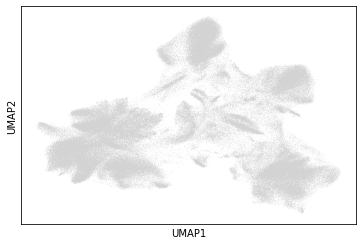

In [27]:
sc.pl.umap(adata)

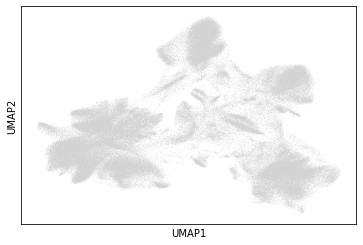

In [29]:
sc.pl.umap(adata[adata.obs['percent_mito'] < 5])

In [30]:
adata

AnnData object with n_obs × n_vars = 210232 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method', 'individual_class', 'cluster', 'individual_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'hvg', 'individual_colors', 'method_colors', 'neighbors', 'pca', 'study_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

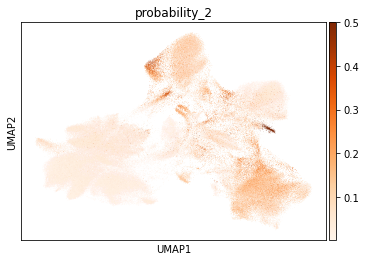

In [32]:
sc.pl.embedding(adata, basis='umap', color='probability_2', color_map='Oranges', vmax=0.5)

In [45]:
adata.var_names[adata.var_names.str.startswith('HB')]

Index(['HBA1', 'HBA2', 'HBB', 'HBD', 'HBEGF', 'HBM', 'HBP1', 'HBQ1', 'HBS1L',
       'HBZ'],
      dtype='object', name='featurekey')

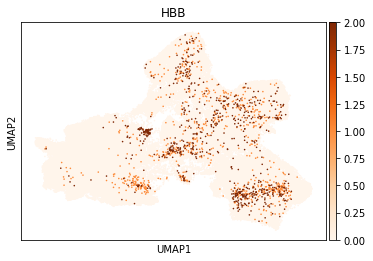

In [49]:
sc.pl.embedding(adata, basis='umap', color='HBB', color_map='Oranges', size=10, vmax=2)

## Comparison with a different DE method from Graham Heimberg

In [3]:
PSEUDOBULK = True

In [4]:
pd.options.display.max_columns = None

In [5]:
df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210204.csv')

In [6]:
df['cluster'].unique()

array(['cardiomyocyte', 'fibroblast', 'pericyte', 'vsmc', 'immune',
       'vascular endothelial', 'macrophage', 'adipocyte'], dtype=object)

In [7]:
import glob

if PSEUDOBULK:
    graham_files = glob.glob('/home/jupyter-user/analysis/meta/DE/pseudobulked/*.csv')
else:
    graham_files = glob.glob('/home/jupyter-user/analysis/meta/DE/graham_cell/*.csv')
    
    
graham_files

['/home/jupyter-user/analysis/meta/DE/pseudobulked/smc.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/nk.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/fibroblast.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/macrophage.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/pericyte.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/cardiomyocyte.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/adipocyte.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/lymphEC.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulked/endothelial.csv']

In [8]:
dfs = []

for file in graham_files:
    df_tmp = pd.read_csv(file)
    cluster = file.split('/')[-1].split('.')[0]
    
    if cluster == 'lymphEC':
        continue
    
    df_tmp.insert(1, column='cluster', value=cluster
                  .replace('endothelial', 'vascular endothelial')
                  .replace('nk', 'immune')
                  .replace('smc', 'vsmc'))
    dfs.append(df_tmp)
    
df_graham = pd.concat(dfs, axis=0)
df_graham = df_graham.rename(columns={'Unnamed: 0': 'gene'})
df_graham = df_graham.rename(columns={'featurekey': 'gene'})

In [9]:
df_graham

gene               cluster  constant_log2fc  COVID19_log2fc  \
0           A1BG                  vsmc         0.006593       -0.007482   
1       A1BG-AS1                  vsmc         0.128303       -0.468050   
2            A2M                  vsmc         0.060073       -0.308951   
3      A2ML1-AS1                  vsmc         0.108210       -0.431573   
4         A4GALT                  vsmc         0.096185       -0.346266   
...          ...                   ...              ...             ...   
18884       ZXDC  vascular endothelial         0.007895       -0.064458   
18885     ZYG11A  vascular endothelial        -0.081190        0.200080   
18886     ZYG11B  vascular endothelial         0.024926       -0.074848   
18887        ZYX  vascular endothelial         0.039701       -0.104125   
18888      ZZEF1  vascular endothelial        -0.016297        0.085958   

       Ellinor_log2fc  Izar_log2fc  Teichmann_log2fc  broad_log2fc  \
0            0.022541     0.277542         -0.008466     -0.285024   
1            0.263298    -0.283752          0.333056     -0.184298   
2            0.525251    -0.363795         -0.156227      0.054844   
3            0.420840    -0.232148          0.118943     -0.199425   
4            0.178042    -0.196898          0.264409     -0.149368   
...               ...          ...               ...           ...   
18884        0.554028    -0.054697         -0.481676     -0.009761   
18885       -0.243351    -0.396187         -0.037919      0.596267   
18886        0.054912     0.034496          0.044862     -0.109344   
18887       -0.358659    -0.003209          0.502485     -0.100916   
18888        0.176369     0.270324         -0.278625     -0.184366   

       constant_pval  COVID19_pval  Ellinor_pvalue  Izar_pvalue  \
0           0.959002      0.962615        0.923086     0.306791   
1           0.262739      0.001989        0.207832     0.239134   
2           0.608018      0.039380        0.017728     0.144769   
3           0.348499      0.004348        0.049866     0.338802   
4           0.430607      0.027010        0.422959     0.442674   
...              ...           ...             ...          ...   
18884       0.944487      0.649242        0.012702     0.823356   
18885       0.470342      0.157994        0.253240     0.107555   
18886       0.839393      0.626326        0.812731     0.896687   
18887       0.732434      0.473695        0.106686     0.989786   
18888       0.892042      0.567113        0.437445     0.300626   

       Teichmann_pvalue  broad_pvalue    sig  adjusted  neg_log_pval_adjusted  
0              0.973694      0.280275  False       1.0          -0.000000e+00  
1              0.148843      0.428680  False       1.0           3.061605e-11  
2              0.505785      0.818331  False       1.0          -0.000000e+00  
3              0.605190      0.396867  False       1.0          -0.000000e+00  
4              0.280993      0.548111  False       1.0          -0.000000e+00  
...                 ...           ...    ...       ...                    ...  
18884          0.033379      0.965620  False       1.0          -0.000000e+00  
18885          0.861608      0.010638  False       1.0          -0.000000e+00  
18886          0.850860      0.656534  False       1.0          -0.000000e+00  
18887          0.030294      0.663625  False       1.0          -0.000000e+00  
18888          0.235809      0.443691  False       1.0          -0.000000e+00  

[126586 rows x 17 columns]

In [10]:
df_graham[df_graham['gene'] == 'PLCG2']

gene               cluster  constant_log2fc  COVID19_log2fc  \
7578   PLCG2                  vsmc        -0.176706        0.632188   
3614   PLCG2                immune        -0.223871        0.665068   
15087  PLCG2            fibroblast        -0.210440        0.736025   
9742   PLCG2            macrophage        -0.154557        0.562105   
13622  PLCG2              pericyte        -0.199566        0.737944   
18192  PLCG2         cardiomyocyte        -0.183133        0.774326   
6006   PLCG2             adipocyte        -0.131251        0.452812   
13059  PLCG2  vascular endothelial        -0.223541        0.731996   

       Ellinor_log2fc  Izar_log2fc  Teichmann_log2fc  broad_log2fc  \
7578        -0.369961     0.169815         -0.438933      0.462373   
3614        -0.275359     0.088592         -0.613581      0.576476   
15087       -0.460210     0.334541         -0.486255      0.401485   
9742        -0.321675     0.360448         -0.394988      0.201657   
13622       -0.513518     0.158739         -0.423992      0.579205   
18192       -0.496705     0.454698         -0.460753      0.319627   
6006        -0.328345     0.042401         -0.255718      0.410410   
13059       -0.398488     0.086376         -0.557050      0.645621   

       constant_pval  COVID19_pval  Ellinor_pvalue  Izar_pvalue  \
7578        0.071776  5.424705e-06        0.039759     0.401985   
3614        0.019809  1.049903e-06        0.133040     0.637446   
15087       0.008657  1.810798e-09        0.002661     0.048870   
9742        0.136140  7.441727e-05        0.095587     0.104125   
13622       0.009942  1.190972e-09        0.000649     0.327652   
18192       0.017198  6.115347e-10        0.000902     0.007540   
6006        0.233871  1.844496e-03        0.110908     0.855575   
13059       0.002635  2.193580e-10        0.004226     0.569403   

       Teichmann_pvalue  broad_pvalue    sig  adjusted  neg_log_pval_adjusted  
7578           0.027243      0.022857  False  0.062291           1.205576e+00  
3614           0.001180      0.002469   True  0.006188           2.208463e+00  
15087          0.002106      0.011841   True  0.000038           4.415475e+00  
9742           0.055546      0.331141  False  0.662842           1.785903e-01  
13622          0.005023      0.000464   True  0.000023           4.634292e+00  
18192          0.002449      0.048033   True  0.000015           4.819201e+00  
6006           0.238972      0.068582  False  1.000000           1.146113e-08  
13059          0.000185      0.000037   True  0.000004           5.383122e+00

In [11]:
df.columns

Index(['Unnamed: 0', 'gene', 'cluster', 'test.group', 'comparison', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B',
       'test.group.cell.mean.counts', 'comparison.cell.mean.counts',
       'test.group.frac.expr>0', 'comparison.frac.expr>0',
       'test.group.frac.expr>1', 'comparison.frac.expr>1', 'bkg.prob',
       'PPV.expr>0', 'PPV.expr>1', 'frac.cells.in.group.expr>0',
       'frac.cells.out.group.expr>0', 'frac.cells.in.group.expr>1',
       'frac.cells.out.group.expr>1'],
      dtype='object')

In [12]:
# add graham's numerics to mine

df_graham_redux = df_graham[['gene', 'cluster', 'COVID19_log2fc', 'COVID19_pval', 'adjusted']]
df_graham_redux['conservative_pseudobulk_COVID19_log2fc'] = df_graham_redux['COVID19_log2fc']
df_graham_redux['conservative_pseudobulk_COVID19_pval'] = df_graham_redux['COVID19_pval']
df_graham_redux['conservative_pseudobulk_COVID19_adjusted_pval'] = df_graham_redux['adjusted']

df_graham_redux = df_graham_redux[['gene', 'cluster', 
                                   'conservative_pseudobulk_COVID19_log2fc',
                                   'conservative_pseudobulk_COVID19_pval', 
                                   'conservative_pseudobulk_COVID19_adjusted_pval']]

df_redux = df[['gene', 'cluster', 'test.group', 'comparison', 'logFC',
               't', 'P.Value', 'adj.P.Val',
               'test.group.cell.mean.counts', 'comparison.cell.mean.counts',
               'test.group.frac.expr>0', 'comparison.frac.expr>0',
               'test.group.frac.expr>1', 'comparison.frac.expr>1', 'bkg.prob']]

df_merged = pd.merge(left=df_redux, right=df_graham_redux, how='left', on=['gene', 'cluster'])
df_merged

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

gene        cluster test.group comparison     logFC          t  \
0          PLCG2  cardiomyocyte    COVID19    healthy  4.927837  15.128184   
1        NDUFAF4  cardiomyocyte    COVID19    healthy -3.054964 -12.678636   
2        FAM173A  cardiomyocyte    COVID19    healthy -3.537947 -12.067144   
3         EXOSC8  cardiomyocyte    COVID19    healthy -2.792687 -11.635289   
4           COQ6  cardiomyocyte    COVID19    healthy -2.290361 -11.045097   
...          ...            ...        ...        ...       ...        ...   
96944       DGKB      adipocyte    COVID19    healthy -0.001838  -0.001281   
96945  RPL34-AS1      adipocyte    COVID19    healthy  0.000437   0.000455   
96946      CDIPT      adipocyte    COVID19    healthy  0.000532   0.000455   
96947    DCUN1D2      adipocyte    COVID19    healthy  0.000343   0.000383   
96948       PTX3      adipocyte    COVID19    healthy -0.000444  -0.000287   

            P.Value     adj.P.Val  test.group.cell.mean.counts  \
0      1.282908e-16  2.663060e-12                     1.366968   
1      2.105392e-14  2.185186e-10                     0.038561   
2      8.347113e-14  5.775645e-10                     0.014158   
3      2.268605e-13  1.177293e-09                     0.024652   
4      9.234320e-13  3.833720e-09                     0.028733   
...             ...           ...                          ...   
96944  9.989912e-01  9.994204e-01                     0.065574   
96945  9.996414e-01  9.997739e-01                     0.147541   
96946  9.996415e-01  9.997739e-01                     0.049180   
96947  9.996984e-01  9.997739e-01                     0.360656   
96948  9.997739e-01  9.997739e-01                     0.008197   

       comparison.cell.mean.counts  test.group.frac.expr>0  \
0                         0.034075                0.530441   
1                         0.176760                0.034896   
2                         0.088262                0.013409   
3                         0.124624                0.023320   
4                         0.092807                0.026901   
...                            ...                     ...   
96944                     0.091729                0.049180   
96945                     0.033083                0.057377   
96946                     0.059398                0.040984   
96947                     0.118045                0.188525   
96948                     0.066917                0.008197   

       comparison.frac.expr>0  test.group.frac.expr>1  comparison.frac.expr>1  \
0                    0.030475                0.296660                0.001909   
1                    0.147101                0.003082                0.023445   
2                    0.078156                0.000666                0.008874   
3                    0.110008                0.001249                0.012932   
4                    0.083819                0.001499                0.008115   
...                       ...                     ...                     ...   
96944                0.070677                0.016393                0.017293   
96945                0.031579                0.016393                0.001504   
96946                0.054887                0.008197                0.004511   
96947                0.100752                0.073770                0.015789   
96948                0.034586                0.000000                0.012782   

       bkg.prob  conservative_pseudobulk_COVID19_log2fc  \
0      0.190681                                0.774326   
1      0.019709                               -0.698219   
2      0.012424                               -0.477893   
3      0.032213                               -0.711645   
4      0.014911                               -0.592382   
...         ...                                     ...   
96944  0.044143                                0.140271   
96945  0.054002                                0.003279   
96946  0.015213                  

In [13]:
df_merged.sort_values(by=['cluster', 'test.group', 'comparison', 'logFC'], 
                      ascending=[True, True, True, False])\
.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210204_with_graham_results.csv',
                 index=False)

In [14]:
!gsutil cp /home/jupyter-user/analysis/meta/DE/heart_DE_20210204_with_graham_results.csv \
    gs://fc-7e30ec48-0a0c-484f-a784-b6c7f44dd2c7/notebooks/heart_DE_figures/

Copying file:///home/jupyter-user/analysis/meta/DE/heart_DE_20210204_with_graham_results.csv [Content-Type=text/csv]...
- [1 files][ 27.4 MiB/ 27.4 MiB]                                                
Operation completed over 1 objects/27.4 MiB.                                     


In [248]:
df_graham['test.group'] = 'COVID19'
df_graham['comparison'] = 'healthy'
df_graham['adj.P.Val'] = df_graham['adjusted']

if PSEUDOBULK:
    df_graham['P.Value'] = df_graham['COVID19_pval']
    df_graham['logFC'] = df_graham['COVID19_log2fc']
else:
    df_graham['P.Value'] = df_graham['disease_pval']
    df_graham['logFC'] = df_graham['disease_log2fc']

In [249]:
df_graham

gene               cluster  constant_log2fc  COVID19_log2fc  \
0           A1BG                  vsmc         0.006593       -0.007482   
1       A1BG-AS1                  vsmc         0.128303       -0.468050   
2            A2M                  vsmc         0.060073       -0.308951   
3      A2ML1-AS1                  vsmc         0.108210       -0.431573   
4         A4GALT                  vsmc         0.096185       -0.346266   
...          ...                   ...              ...             ...   
18884       ZXDC  vascular endothelial         0.007895       -0.064458   
18885     ZYG11A  vascular endothelial        -0.081190        0.200080   
18886     ZYG11B  vascular endothelial         0.024926       -0.074848   
18887        ZYX  vascular endothelial         0.039701       -0.104125   
18888      ZZEF1  vascular endothelial        -0.016297        0.085958   

       Ellinor_log2fc  Izar_log2fc  Teichmann_log2fc  broad_log2fc  \
0            0.022541     0.277542         -0.008466     -0.285024   
1            0.263298    -0.283752          0.333056     -0.184298   
2            0.525251    -0.363795         -0.156227      0.054844   
3            0.420840    -0.232148          0.118943     -0.199425   
4            0.178042    -0.196898          0.264409     -0.149368   
...               ...          ...               ...           ...   
18884        0.554028    -0.054697         -0.481676     -0.009761   
18885       -0.243351    -0.396187         -0.037919      0.596267   
18886        0.054912     0.034496          0.044862     -0.109344   
18887       -0.358659    -0.003209          0.502485     -0.100916   
18888        0.176369     0.270324         -0.278625     -0.184366   

       constant_pval  COVID19_pval  Ellinor_pvalue  Izar_pvalue  \
0           0.959002      0.962615        0.923086     0.306791   
1           0.262739      0.001989        0.207832     0.239134   
2           0.608018      0.039380        0.017728     0.144769   
3           0.348499      0.004348        0.049866     0.338802   
4           0.430607      0.027010        0.422959     0.442674   
...              ...           ...             ...          ...   
18884       0.944487      0.649242        0.012702     0.823356   
18885       0.470342      0.157994        0.253240     0.107555   
18886       0.839393      0.626326        0.812731     0.896687   
18887       0.732434      0.473695        0.106686     0.989786   
18888       0.892042      0.567113        0.437445     0.300626   

       Teichmann_pvalue  broad_pvalue    sig  adjusted  neg_log_pval_adjusted  \
0              0.973694      0.280275  False       1.0          -0.000000e+00   
1              0.148843      0.428680  False       1.0           3.061605e-11   
2              0.505785      0.818331  False       1.0          -0.000000e+00   
3              0.605190      0.396867  False       1.0          -0.000000e+00   
4              0.280993      0.548111  False       1.0          -0.000000e+00   
...                 ...           ...    ...       ...                    ...   
18884          0.033379      0.965620  False       1.0          -0.000000e+00   
18885          0.861608      0.010638  False       1.0          -0.000000e+00   
18886          0.850860      0.656534  False       1.0          -0.000000e+00   
18887          0.030294      0.663625  False       1.0          -0.000000e+00   
18888          0.235809      0.443691  False       1.0          -0.000000e+00   

      test.group comparison  adj.P.Val   P.Value     logFC  
0        COVID19    healthy        1.0  0.962615 -0.007482  
1        COVID19    healthy        1.0  0.001989 -0.468050  
2        COVID19    healthy        1.0  0.039380 -0.308951  
3        COVID19    healthy        1.0  0.004348 -0.431573  
4        COVID19    healthy        1.0  0.027010 -0.346266  
...          ...        ...        ...       ...       ...  
18884    COVID19    healthy        1.0  0.649242 -0.064458  
1888

In [250]:
df_graham[(df_graham['adj.P.Val'] < 0.01)].sort_values(by='logFC', ascending=False).head(20)

gene               cluster  constant_log2fc  COVID19_log2fc  \
16058      SLC8A1              pericyte        -0.218405        0.841381   
14373         QKI              pericyte        -0.213397        0.828869   
7062       DYRK1A              pericyte        -0.213051        0.826061   
9078       HIVEP2              pericyte        -0.216754        0.824933   
6797          DMD              pericyte        -0.217792        0.823360   
12734      PDLIM5  vascular endothelial        -0.217186        0.820725   
8646       HIVEP2  vascular endothelial        -0.207057        0.815949   
17615      SLC8A1            fibroblast        -0.223666        0.804103   
15391    PPP1R12B            fibroblast        -0.208481        0.800515   
8733       HNRNPU  vascular endothelial        -0.219489        0.799367   
11544       MGAT5              pericyte        -0.198493        0.798872   
13075      PAPOLA              pericyte        -0.211785        0.797044   
1892   AC124312.1  vascular endothelial        -0.208126        0.795356   
19176      ZNF407              pericyte        -0.214512        0.791035   
13915    PPP1R12B              pericyte        -0.208544        0.784147   
13351    PPP1R12B  vascular endothelial        -0.201193        0.781452   
8725        GRB10              pericyte        -0.192203        0.779776   
15679       SNX13  vascular endothelial        -0.214845        0.778302   
14138      PRRC2C              pericyte        -0.209703        0.778149   
13289      PDLIM5              pericyte        -0.199417        0.777694   

       Ellinor_log2fc  Izar_log2fc  Teichmann_log2fc  broad_log2fc  \
16058       -0.387334     0.531245         -0.672451      0.310135   
14373       -0.632972     0.446055         -0.409294      0.382814   
7062        -0.151605     0.673784         -0.887507      0.152277   
9078        -0.422862     0.427288         -0.618825      0.397645   
6797        -0.312597     0.441295         -0.728556      0.382065   
12734       -0.451044     0.719859         -0.586868      0.100867   
8646        -0.394538     0.899117         -0.628468     -0.083169   
17615       -0.479064     0.489828         -0.548705      0.314274   
15391       -0.464152     0.756730         -0.544843      0.043784   
8733        -0.625436     0.490586         -0.393420      0.308781   
11544       -0.337501     0.763677         -0.659864      0.035196   
13075       -0.373431     0.365531         -0.635398      0.431512   
1892        -0.652709     0.669553         -0.350772      0.125803   
19176       -0.038940     0.409739         -0.966608      0.381296   
13915       -0.317737     0.379355         -0.674954      0.404791   
13351       -0.400691     0.799549         -0.581955     -0.018097   
8725        -0.316956     0.794159         -0.655023     -0.014382   
15679       -0.275161     0.567657         -0.717987      0.210646   
14138       -0.341585     0.287557         -0.646268      0.490593   
13289       -0.425353     0.524909         -0.551758      0.252785   

       constant_pval  COVID19_pval  Ellinor_pvalue   Izar_pvalue  \
16058       0.000493  3.414238e-14        0.000927  1.279659e-04   
14373       0.000938  1.618030e-13        0.000002  1.394347e-03   
7062        0.000201  2.645430e-15        0.128708  5.774045e-07   
9078        0.001052  4.110371e-13        0.000719  2.662515e-03   
6797        0.000766  2.031718e-13        0.008202  1.561566e-03   
12734       0.001023  2.470062e-13        0.000354  2.930269e-06   
8646        0.000882  4.467842e-14        0.000785  9.139177e-09   
17615       0.001436  2.882327e-12        0.000368  1.257144e-03   
15391       0.002614  2.773308e-12        0.000493  3.350773e-06   
8733        0.001660  3.059596e-12        0.000009  1.191798e-03   
11544       0.003451  3.290125e-12        0.007604  2.485773e-06   
13075       0.002700  9.647362e-12        0.004638  1.507046e-02   
1892        0.002732  3.664815e-12        0.000004  2.561360e

In [ ]:
modifier = 'pseudobulk' if PSEUDOBULK else 'cell'

for k in df['cluster'].unique():
    
    try:
        volcano_plot(df_graham, 
                     FDR=0.01, 
                     cluster_column_label='cluster',
                     cluster_value=k,
                     test_group_value='COVID19',
                     comparison_value='healthy',
                     num=8,
                     title=f'COVID19 vs. healthy\n{k}: FDR 0.01',
                     show=False
                     )
        plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/graham_{modifier}_heart_{k}_volcano.pdf')
        plt.show()
    except AssertionError:
        pass

In [ ]:
all_volcano_plots(df_graham,
                  FDR=0.01,
                  cluster_column_name='cluster')

In [83]:
df[df['gene'] == 'HIVEP2']

gene               cluster test.group comparison     logFC   AveExpr  \
405    HIVEP2         cardiomyocyte    COVID19    healthy  2.431818  5.919715   
20946  HIVEP2            fibroblast    COVID19    healthy  1.310290  7.280197   
36872  HIVEP2              pericyte    COVID19    healthy  1.444619  6.680927   
50040  HIVEP2                  vsmc    COVID19    healthy  1.816783  6.864103   
60533  HIVEP2                immune    COVID19    healthy  0.863129  7.994340   
65371  HIVEP2  vascular endothelial    COVID19    healthy  1.146334  6.834335   
78299  HIVEP2            macrophage    COVID19    healthy  1.488801  6.239358   
87717  HIVEP2             adipocyte    COVID19    healthy  3.276069  5.073578   

              t       P.Value     adj.P.Val          B  \
405    6.462531  2.226846e-07  1.132576e-05   6.707969   
20946  6.693608  7.816961e-08  6.663442e-06   7.775446   
36872  9.714344  7.034874e-12  2.284575e-08  16.971425   
50040  3.698582  1.168013e-03  6.142973e-02  -0.985966   
60533  2.127718  4.161733e-02  2.131854e-01  -4.573291   
65371  5.124287  8.645093e-06  2.749777e-04   3.220241   
78299  3.882759  4.557060e-04  1.644825e-02  -0.199286   
87717  4.098183  6.207169e-04  6.929974e-02  -0.199948   

       test.group.cell.mean.counts  comparison.cell.mean.counts  \
405                       1.821803                     0.335176   
20946                     0.608406                     0.225347   
36872                     0.794989                     0.205822   
50040                     1.426101                     0.171948   
60533                     0.547264                     0.154567   
65371                     0.458930                     0.120335   
78299                     0.234921                     0.105156   
87717                     1.459016                     0.580450   

       test.group.frac.expr>0  comparison.frac.expr>0  test.group.frac.expr>1  \
405                  0.418089                0.215297                0.217123   
20946                0.325482                0.171146                0.129642   
36872                0.385443                0.167353                0.173648   
50040                0.482024                0.139085                0.270306   
60533                0.278607                0.123341                0.134328   
65371                0.250277                0.098142                0.100259   
78299                0.157460                0.081501                0.048889   
87717                0.409836                0.305263                0.237705   

       comparison.frac.expr>1  bkg.prob  
405                  0.063803  0.174408  
20946                0.037885  0.209691  
36872                0.030679  0.226006  
50040                0.026408  0.177240  
60533                0.023419  0.225985  
65371                0.017977  0.225599  
78299                0.016078  0.291879  
87717                0.130827  0.148951

In [85]:
adata.X = adata.layers['counts'].copy()

sc.pp.normalize_total(adata)

In [87]:
adata.obs['cluster_disease'] = (adata.obs['cluster'].astype(str) 
                                + ' -- ' + adata.obs['disease'].astype(str))

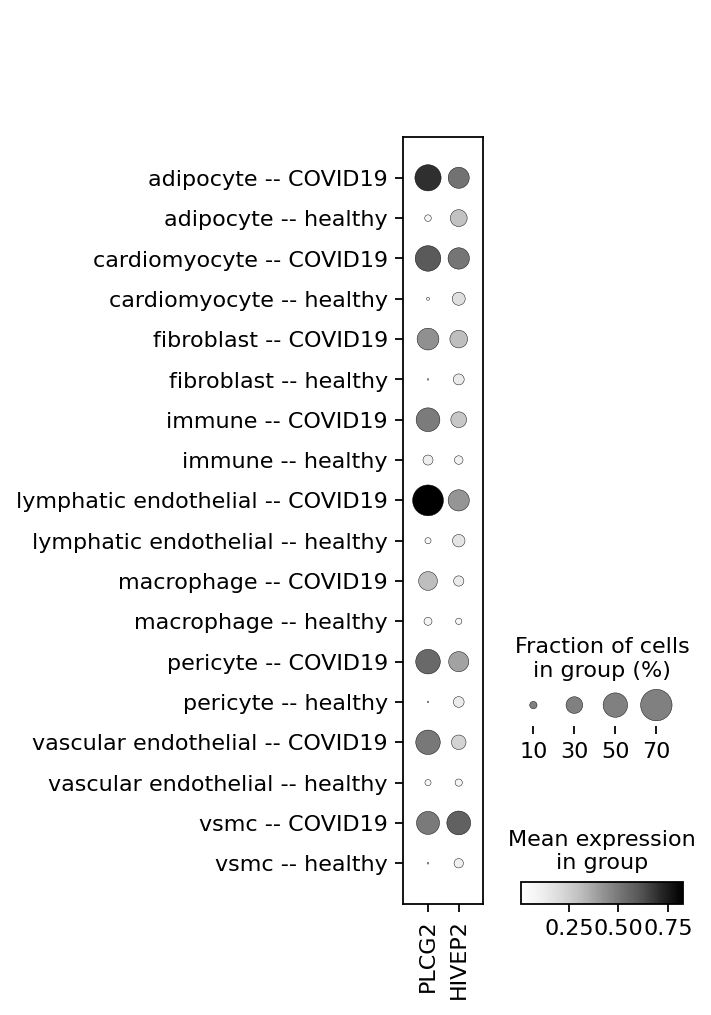

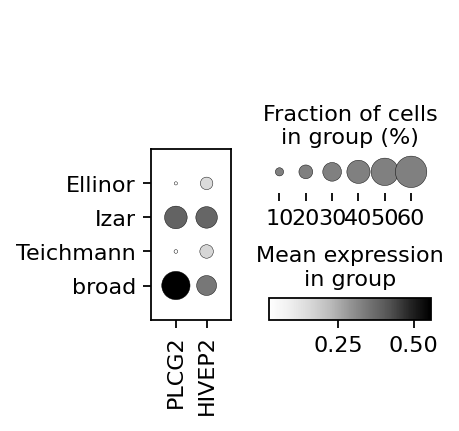

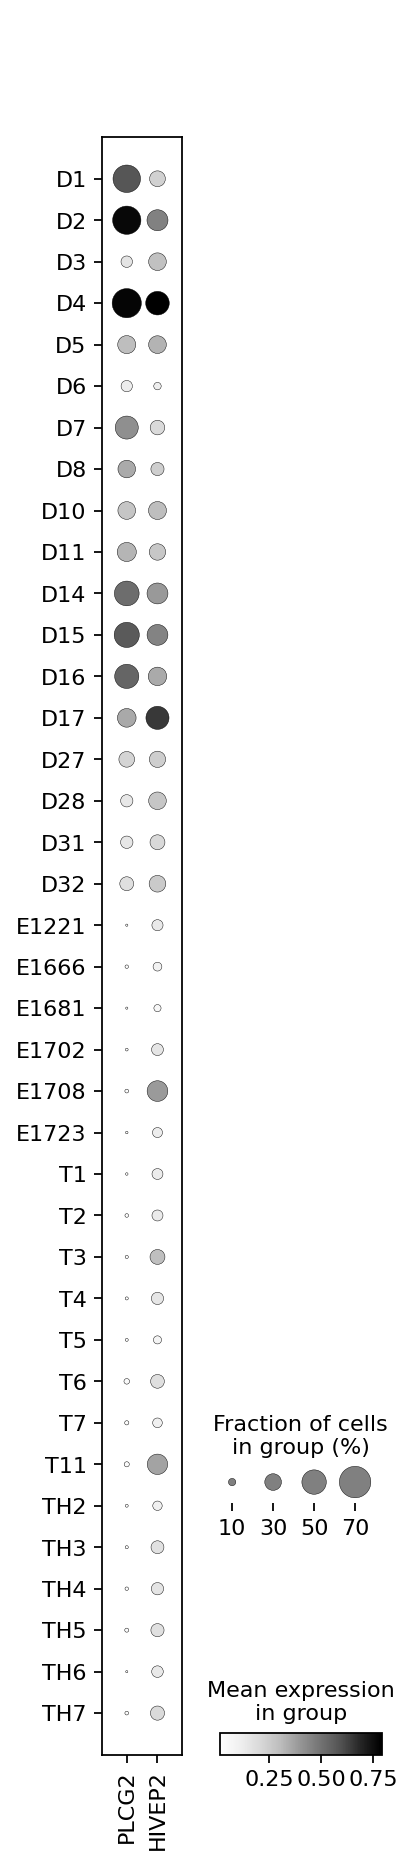

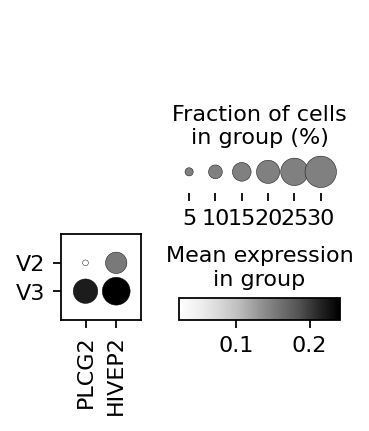

In [225]:
for group in ['cluster_disease', 'study', 'individual', 'version10x']:

    sc.pl.dotplot(adata,
                  groupby=group,
                  var_names=['PLCG2', 'HIVEP2'],
#                   standard_scale='var',
                  log=True,
                  color_map='Greys',
                  smallest_dot=15)

In [62]:
df.columns

Index(['Unnamed: 0', 'gene', 'cluster', 'test.group', 'comparison', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B',
       'test.group.cell.mean.counts', 'comparison.cell.mean.counts',
       'test.group.frac.expr>0', 'comparison.frac.expr>0',
       'test.group.frac.expr>1', 'comparison.frac.expr>1', 'bkg.prob',
       'PPV.expr>0', 'PPV.expr>1', 'frac.cells.in.group.expr>0',
       'frac.cells.out.group.expr>0', 'frac.cells.in.group.expr>1',
       'frac.cells.out.group.expr>1'],
      dtype='object')

In [63]:
df = df[['gene', 'cluster', 'test.group', 'comparison', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B',
       'test.group.cell.mean.counts', 'comparison.cell.mean.counts',
       'test.group.frac.expr>0', 'comparison.frac.expr>0',
       'test.group.frac.expr>1', 'comparison.frac.expr>1', 'bkg.prob']]

In [64]:
df[df['gene'] == 'PLCG2']

gene               cluster test.group comparison     logFC   AveExpr  \
0      PLCG2         cardiomyocyte    COVID19    healthy  4.927837  4.127685   
20768  PLCG2            fibroblast    COVID19    healthy  5.866092  5.256223   
36869  PLCG2              pericyte    COVID19    healthy  5.665190  4.255482   
49860  PLCG2                  vsmc    COVID19    healthy  6.075241  4.517930   
59512  PLCG2                immune    COVID19    healthy  2.356418  8.326761   
64991  PLCG2  vascular endothelial    COVID19    healthy  2.489284  6.764712   
78038  PLCG2            macrophage    COVID19    healthy  1.921805  6.920489   
87777  PLCG2             adipocyte    COVID19    healthy  3.779626  4.118501   

               t       P.Value     adj.P.Val          B  \
0      15.128184  1.282908e-16  2.663060e-12  27.762225   
20768   9.817060  8.862657e-12  1.298057e-08  16.727709   
36869  13.016470  1.236319e-15  1.605978e-11  24.895545   
49860   7.285259  1.913153e-07  7.766618e-04   6.647634   
59512   4.703010  6.632114e-05  6.904059e-03   1.506345   
64991   7.696300  2.570165e-09  1.083863e-06  11.225161   
78038   6.446313  2.327400e-07  3.762767e-04   6.978587   
87777   3.668755  1.692083e-03  1.094814e-01  -1.088606   

       test.group.cell.mean.counts  comparison.cell.mean.counts  \
0                         1.366968                     0.034075   
20768                     0.926165                     0.015028   
36869                     1.240562                     0.013319   
49860                     1.178431                     0.015845   
59512                     1.207294                     0.196721   
64991                     1.040522                     0.093412   
78038                     0.568886                     0.130660   
87777                     2.049180                     0.099248   

       test.group.frac.expr>0  comparison.frac.expr>0  test.group.frac.expr>1  \
0                    0.530441                0.030475                0.296660   
20768                0.429101                0.013665                0.188432   
36869                0.503393                0.011523                0.256260   
49860                0.460719                0.014085                0.227696   
59512                0.480929                0.152225                0.202322   
64991                0.500370                0.078617                0.233814   
78038                0.351111                0.112179                0.113016   
87777                0.549180                0.087218                0.319672   

       comparison.frac.expr>1  bkg.prob  
0                    0.001909  0.190681  
20768                0.000594  0.146679  
36869                0.001197  0.180932  
49860                0.001174  0.129021  
59512                0.031226  0.107015  
64991                0.011010  0.078203  
78038                0.015709  0.148510  
87777                0.011278  0.159342

In [67]:
df[df['gene'] == 'IFNG']

Empty DataFrame
Columns: [gene, cluster, test.group, comparison, logFC, AveExpr, t, P.Value, adj.P.Val, B, test.group.cell.mean.counts, comparison.cell.mean.counts, test.group.frac.expr>0, comparison.frac.expr>0, test.group.frac.expr>1, comparison.frac.expr>1, bkg.prob]
Index: []

In [253]:
if PSEUDOBULK:
    df_combo = pd.merge(left=df, right=df_graham[['gene', 
                                                  'cluster', 
                                                  'COVID19_log2fc', 
                                                  'adjusted']],
                        how='left', on=['gene', 'cluster'])
else:
    df_combo = pd.merge(left=df, right=df_graham[['gene', 
                                              'cluster', 
                                              'disease_log2fc', 
                                              'adjusted']],
                    how='left', on=['gene', 'cluster'])

In [254]:
df_combo

Unnamed: 0       gene        cluster test.group comparison     logFC  \
0               0      PLCG2  cardiomyocyte    COVID19    healthy  4.927837   
1               1    NDUFAF4  cardiomyocyte    COVID19    healthy -3.054964   
2               2    FAM173A  cardiomyocyte    COVID19    healthy -3.537947   
3               3     EXOSC8  cardiomyocyte    COVID19    healthy -2.792687   
4               4       COQ6  cardiomyocyte    COVID19    healthy -2.290361   
...           ...        ...            ...        ...        ...       ...   
96944       96944       DGKB      adipocyte    COVID19    healthy -0.001838   
96945       96945  RPL34-AS1      adipocyte    COVID19    healthy  0.000437   
96946       96946      CDIPT      adipocyte    COVID19    healthy  0.000532   
96947       96947    DCUN1D2      adipocyte    COVID19    healthy  0.000343   
96948       96948       PTX3      adipocyte    COVID19    healthy -0.000444   

        AveExpr          t       P.Value     adj.P.Val          B  \
0      4.127685  15.128184  1.282908e-16  2.663060e-12  27.762225   
1      3.344968 -12.678636  2.105392e-14  2.185186e-10  22.524909   
2      0.724291 -12.067144  8.347113e-14  5.775645e-10  21.047245   
3      2.691533 -11.635289  2.268605e-13  1.177293e-09  20.274164   
4      2.576831 -11.045097  9.234320e-13  3.833720e-09  18.961168   
...         ...        ...           ...           ...        ...   
96944  2.518371  -0.001281  9.989912e-01  9.994204e-01  -5.551826   
96945  2.704176   0.000455  9.996414e-01  9.997739e-01  -5.641862   
96946  2.678282   0.000455  9.996415e-01  9.997739e-01  -5.600184   
96947  3.571545   0.000383  9.996984e-01  9.997739e-01  -5.769344   
96948  2.665001  -0.000287  9.997739e-01  9.997739e-01  -5.491831   

       test.group.cell.mean.counts  comparison.cell.mean.counts  \
0                         1.366968                     0.034075   
1                         0.038561                     0.176760   
2                         0.014158                     0.088262   
3                         0.024652                     0.124624   
4                         0.028733                     0.092807   
...                            ...                          ...   
96944                     0.065574                     0.091729   
96945                     0.147541                     0.033083   
96946                     0.049180                     0.059398   
96947                     0.360656                     0.118045   
96948                     0.008197                     0.066917   

       test.group.frac.expr>0  comparison.frac.expr>0  test.group.frac.expr>1  \
0                    0.530441                0.030475                0.296660   
1                    0.034896                0.147101                0.003082   
2                    0.013409                0.078156                0.000666   
3                    0.023320                0.110008                0.001249   
4                    0.026901                0.083819                0.001499   
...                       ...                     ...                     ...   
96944                0.049180                0.070677                0.016393   
96945                0.057377                0.031579                0.016393   
96946                0.040984                0.054887                0.008197   
96947                0.188525                0.100752                0.073770   
96948                0.008197                0.034586                0.000000   

       comparison.frac.expr>1  bkg.prob  PPV.expr>0  PPV.expr>1  \
0                    0.001909  0.190681    0.367607    0.367901   
1                    0.023445  0.019709    0.811074    0.913000   
2                    0.008874  0.012424    0.765969    0.898364   
3                    0.012932  0.032213    0.674891    0.795796   
4                    0.008115  0.014911    0.758911    0.873289   
...                       ...       ...         .

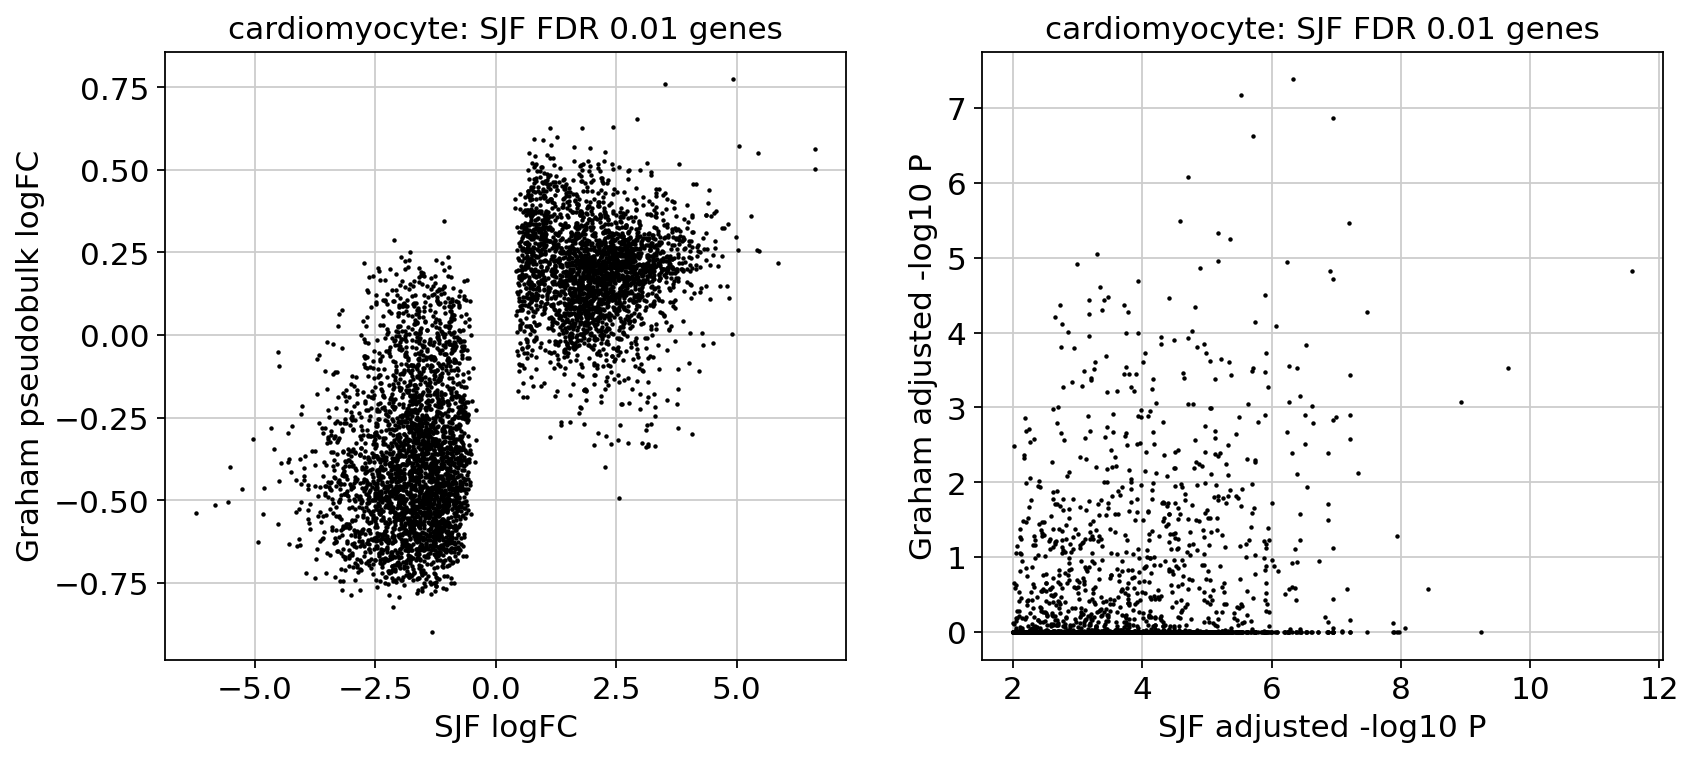

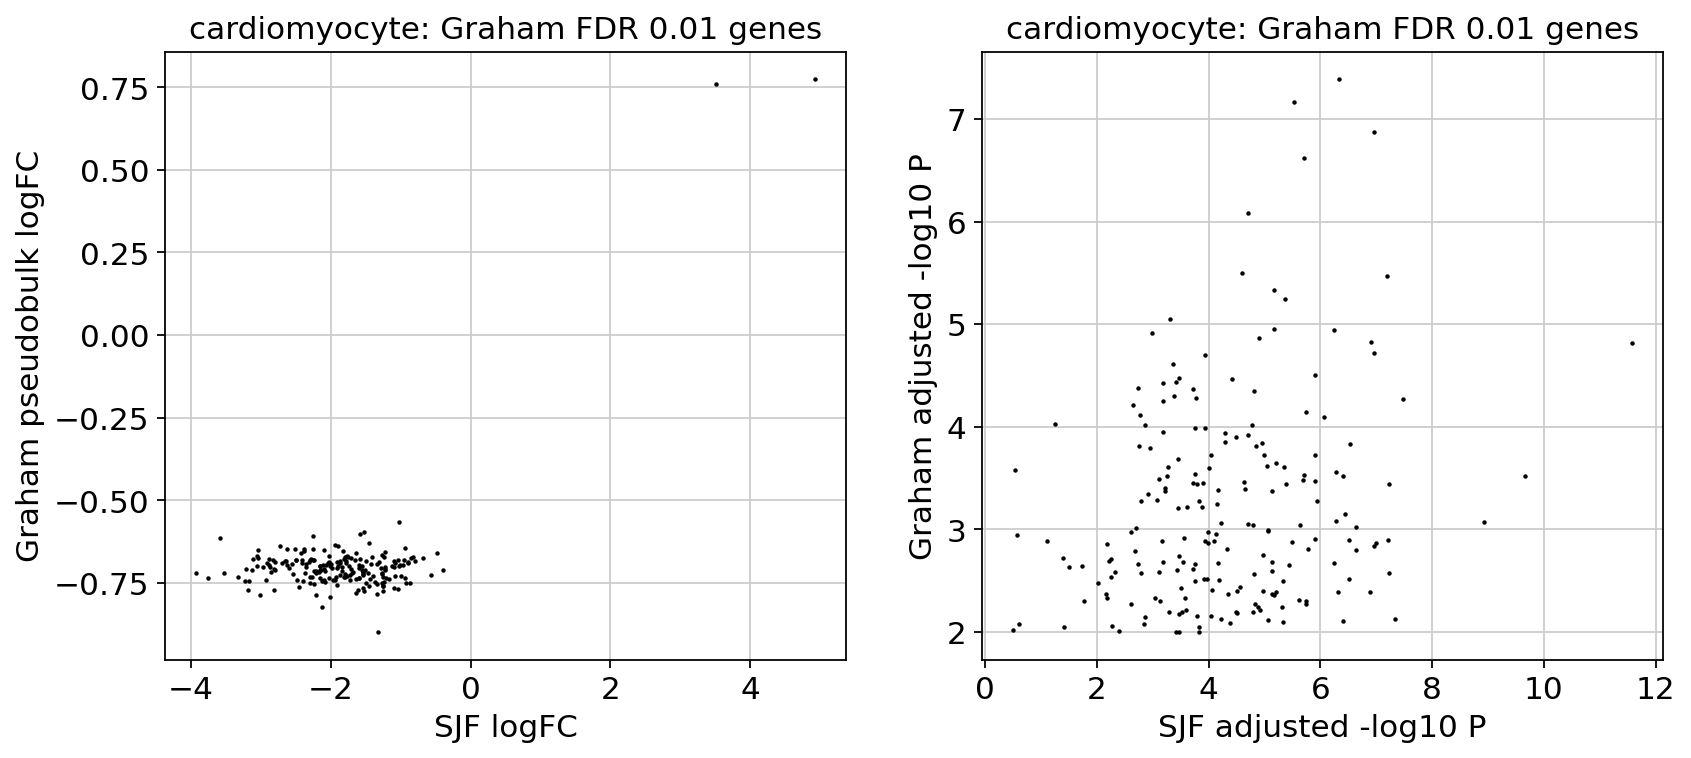

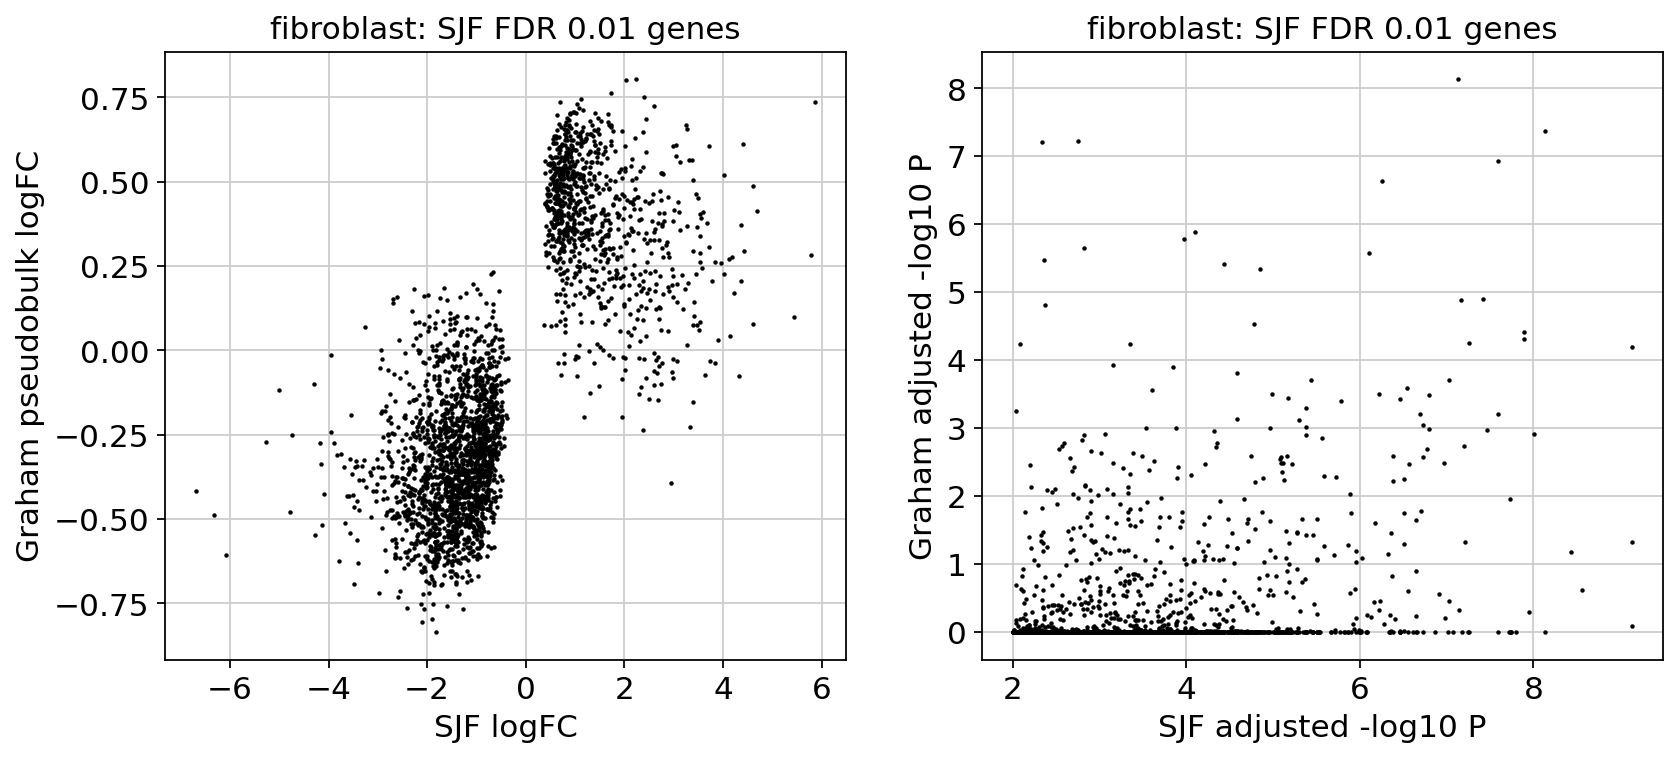

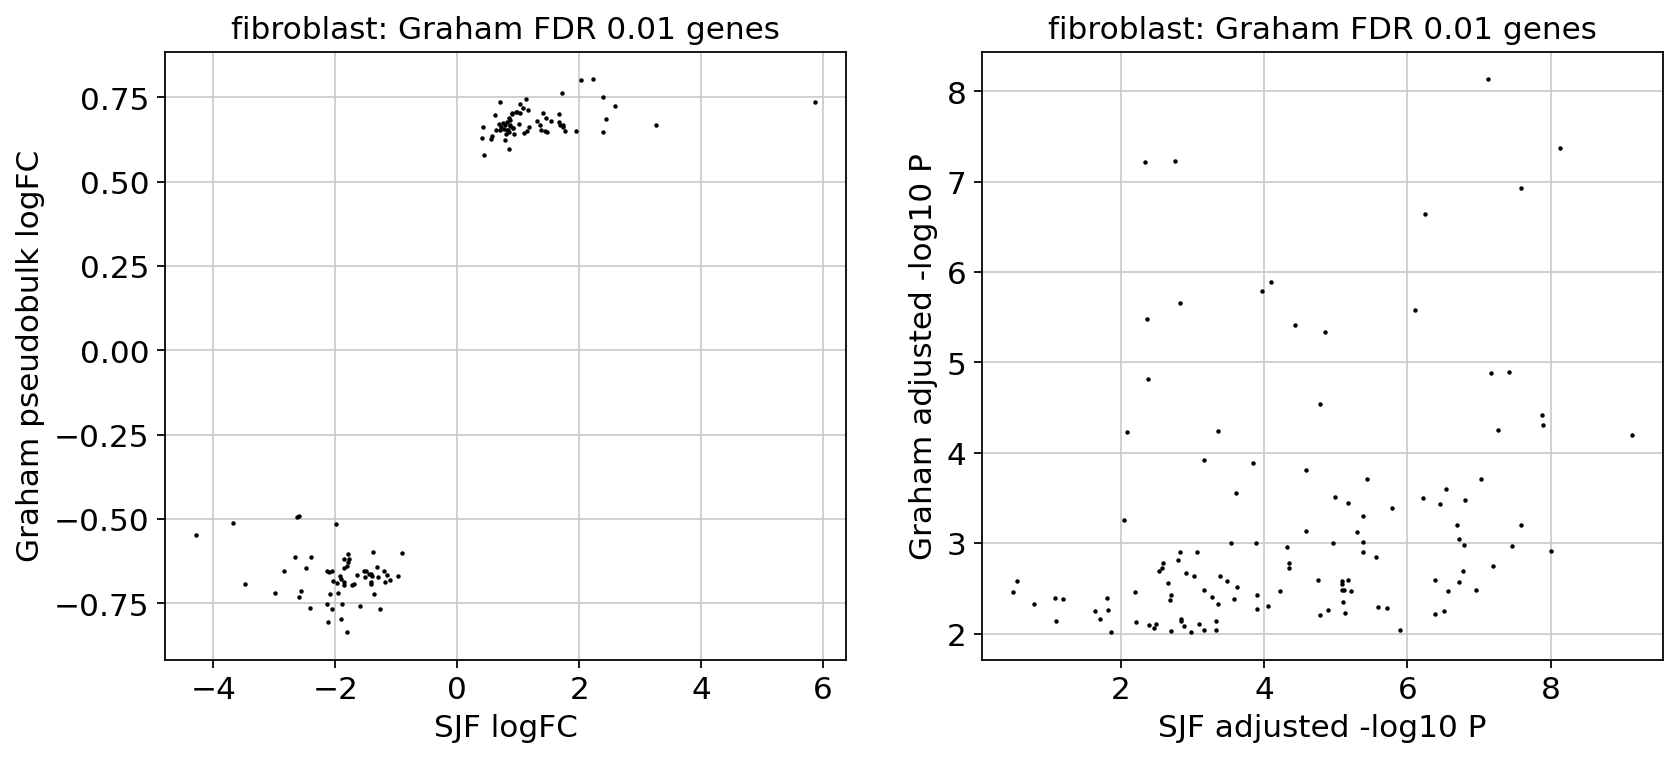

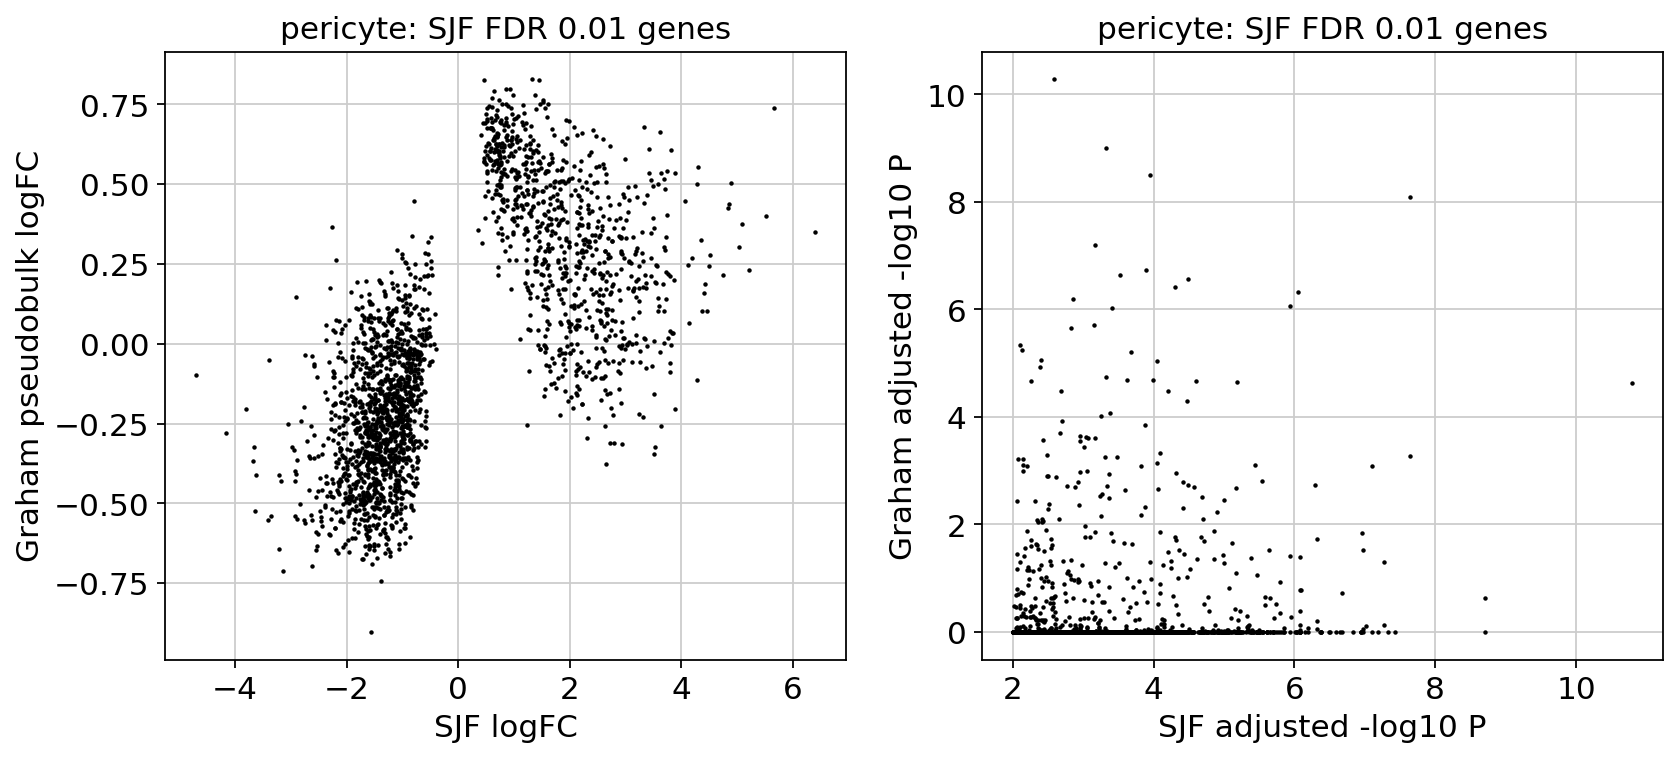

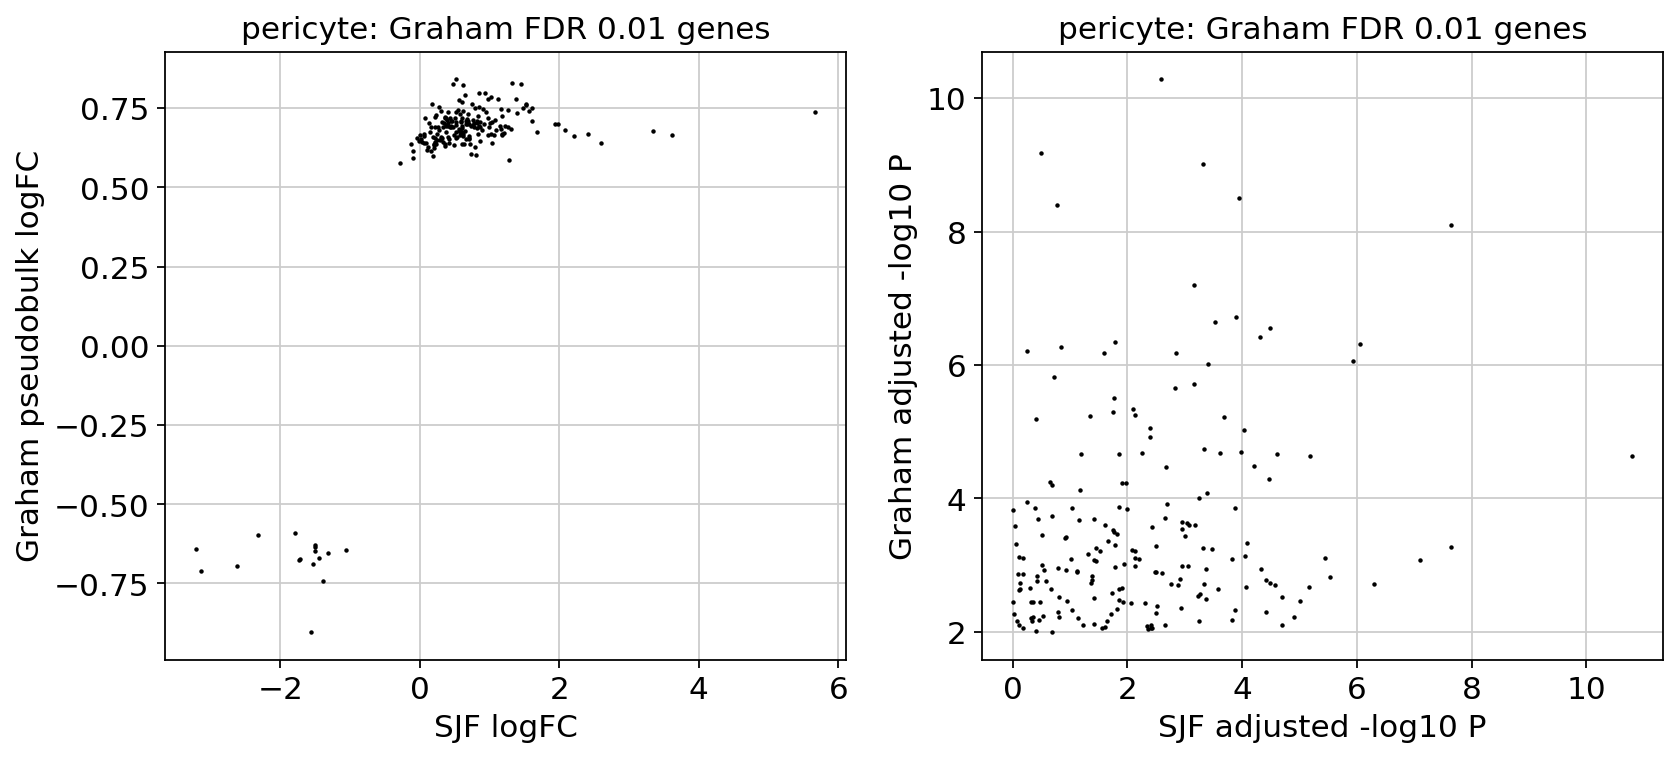

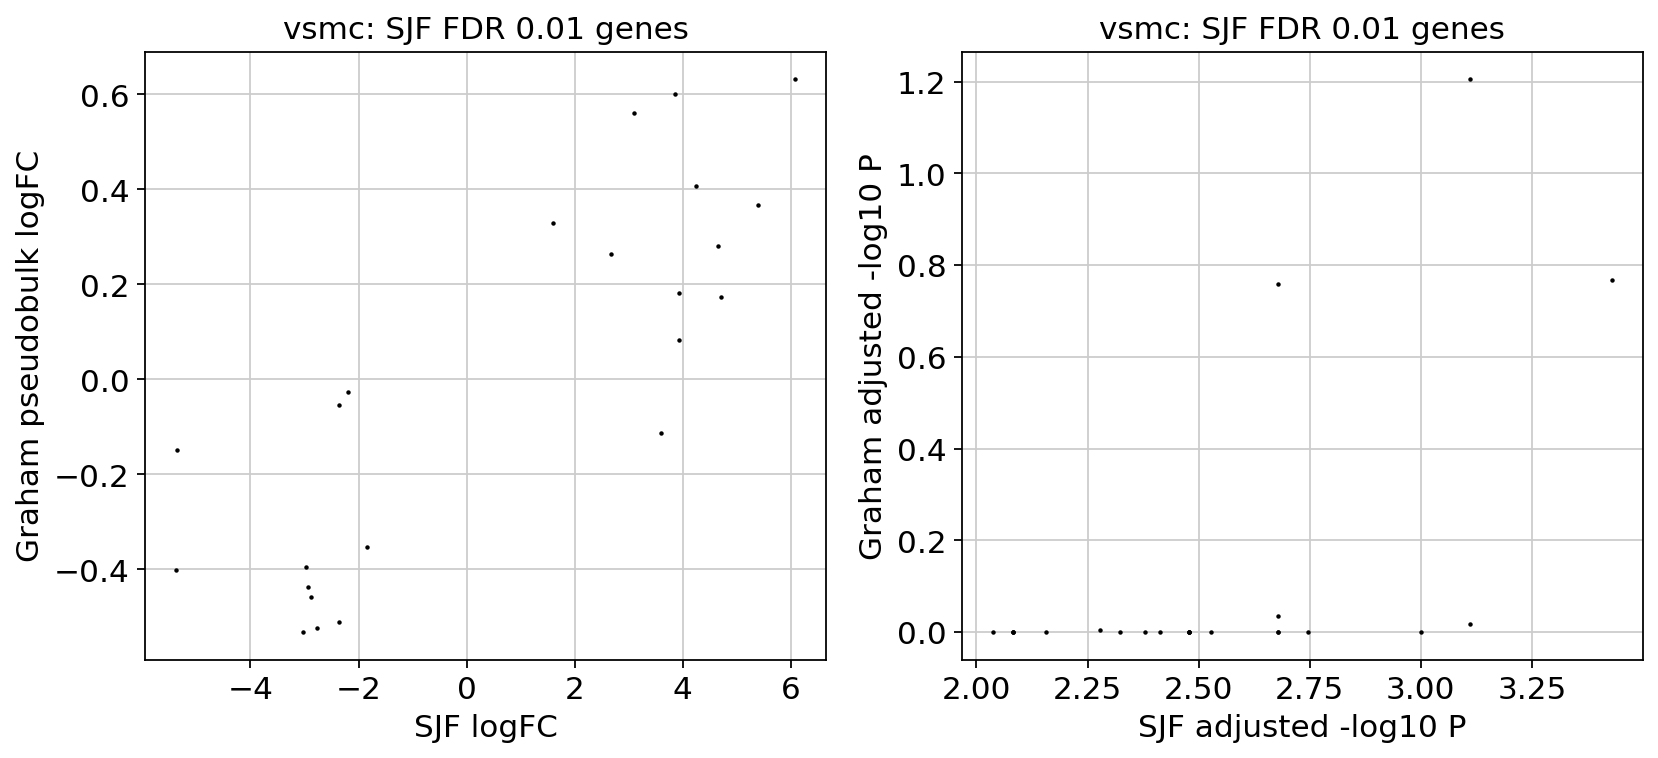

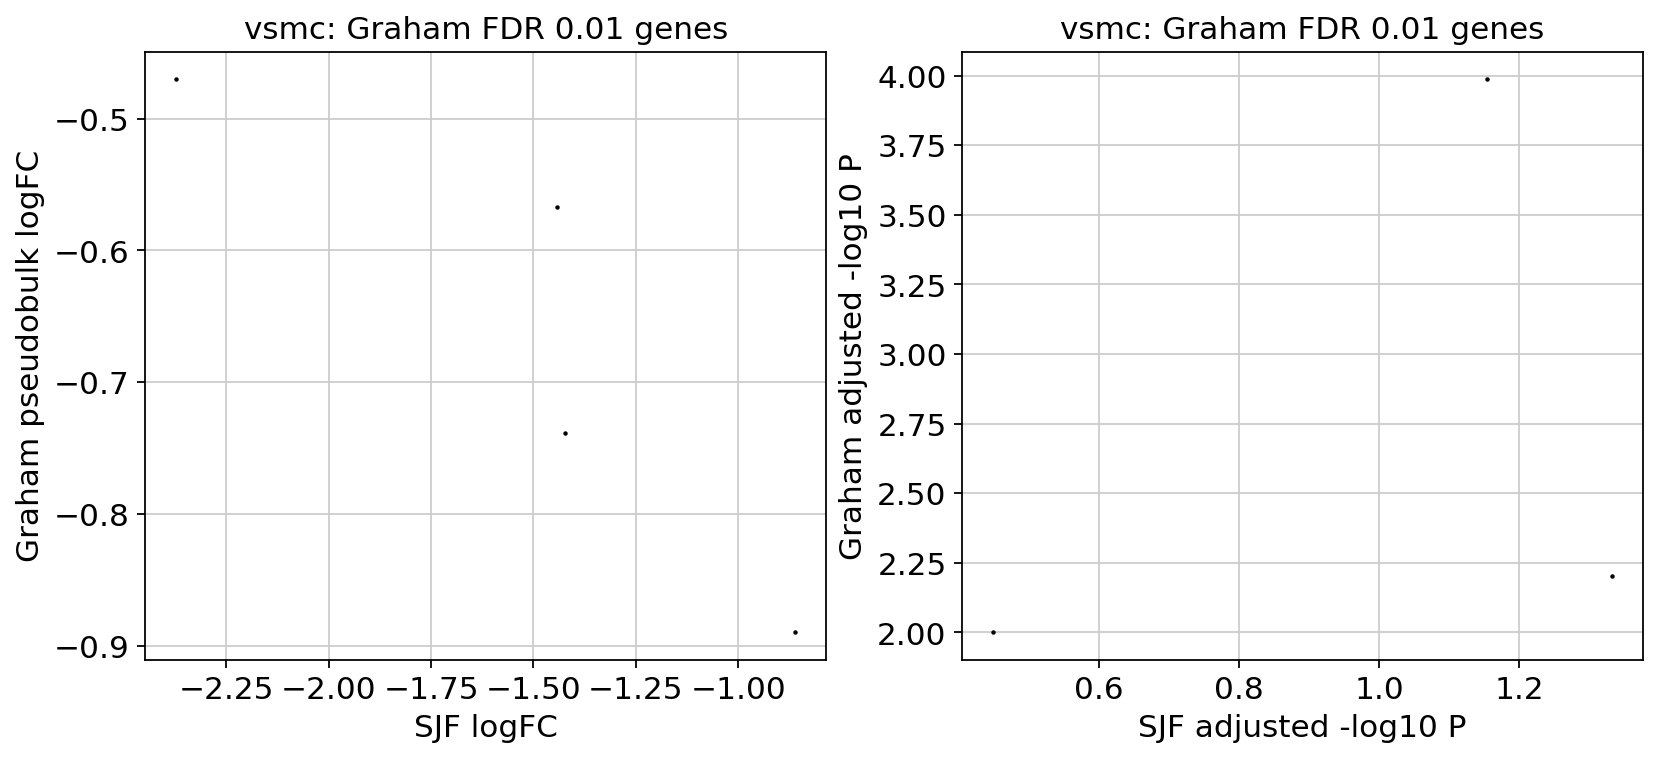

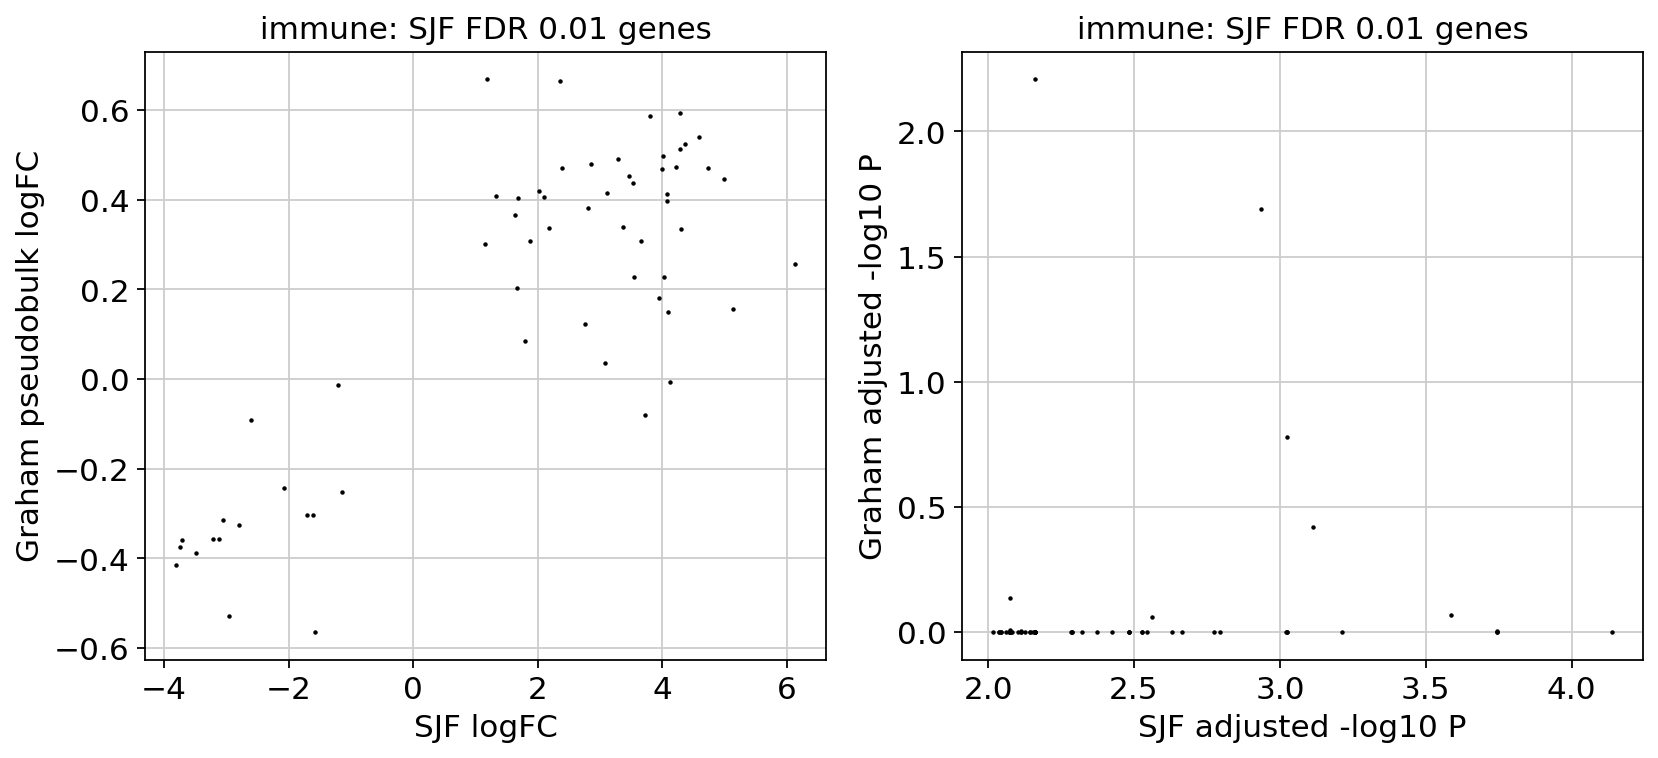

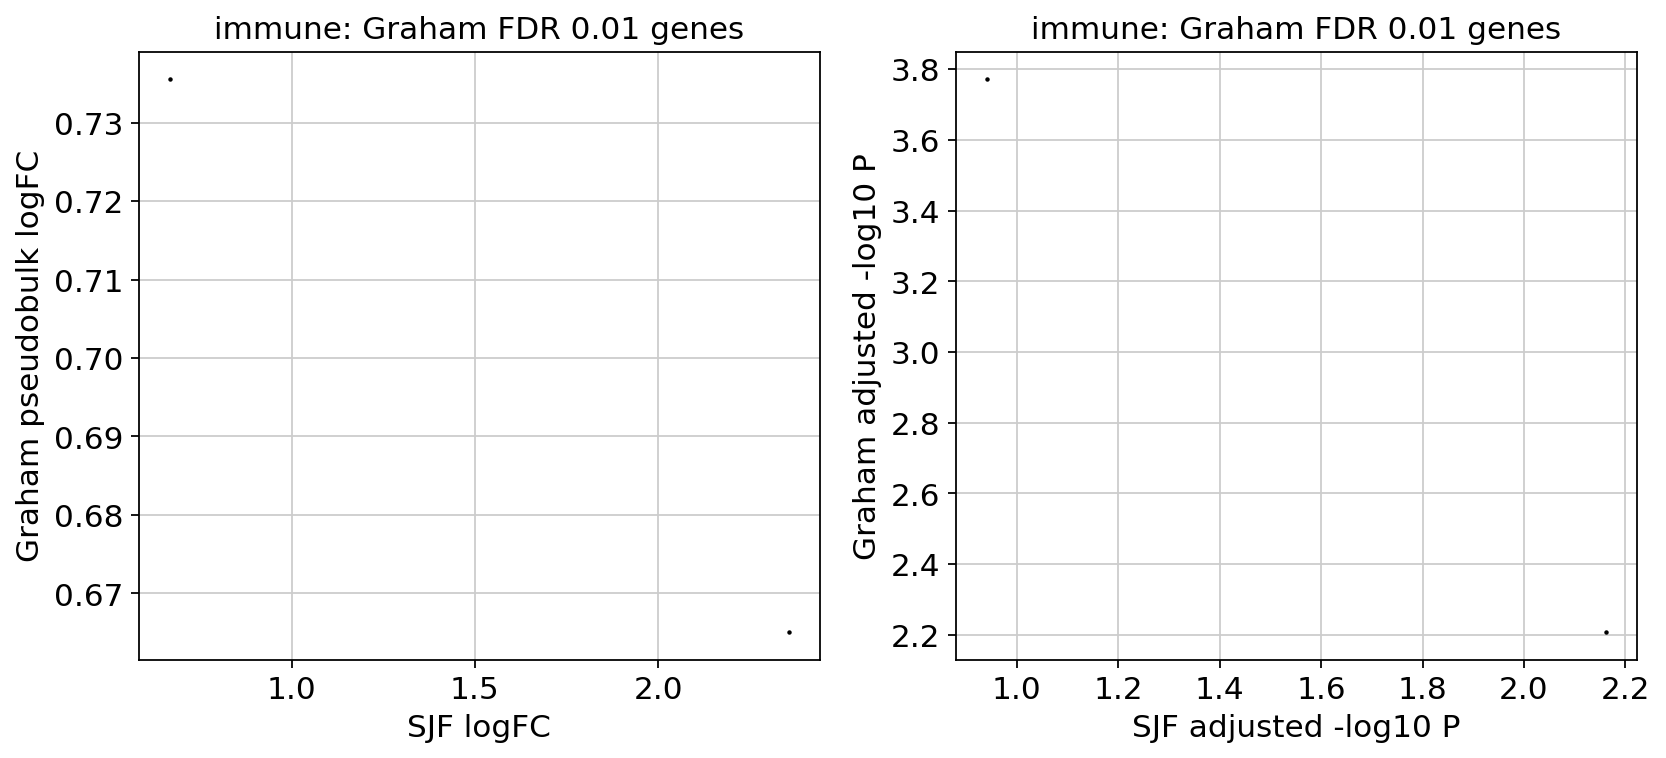

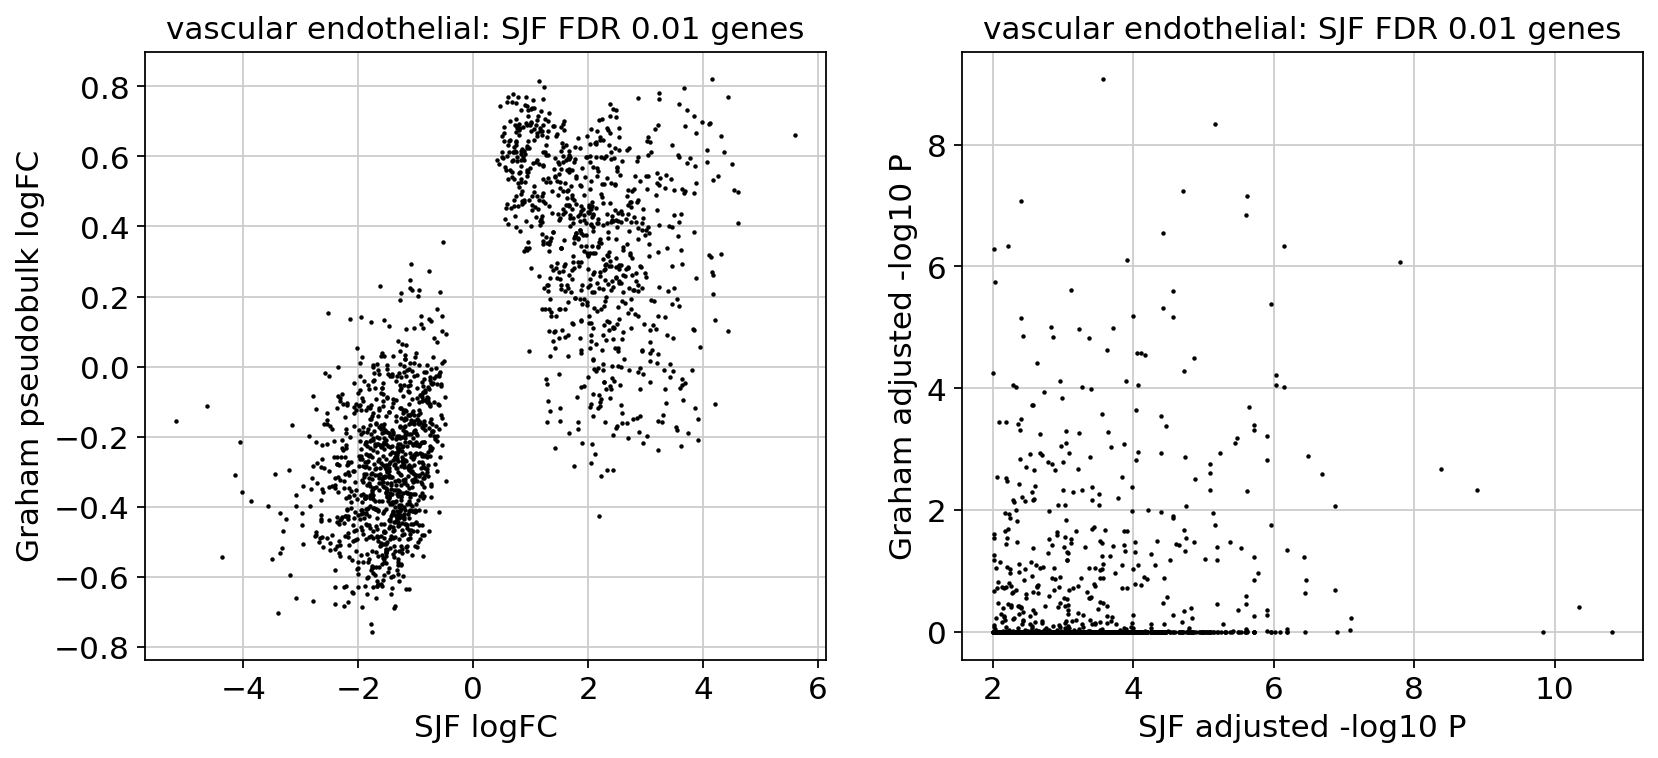

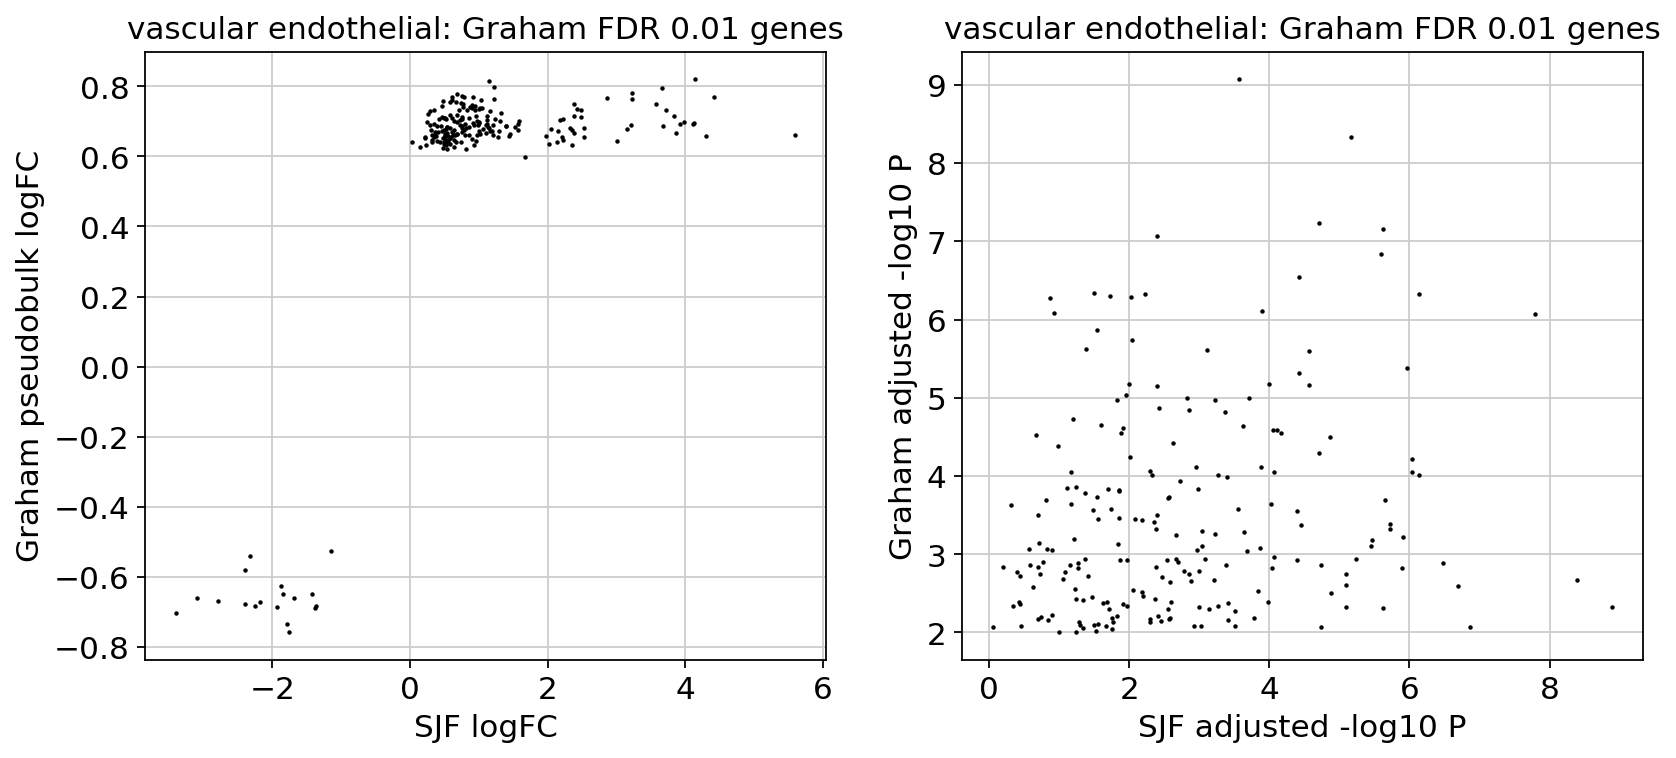

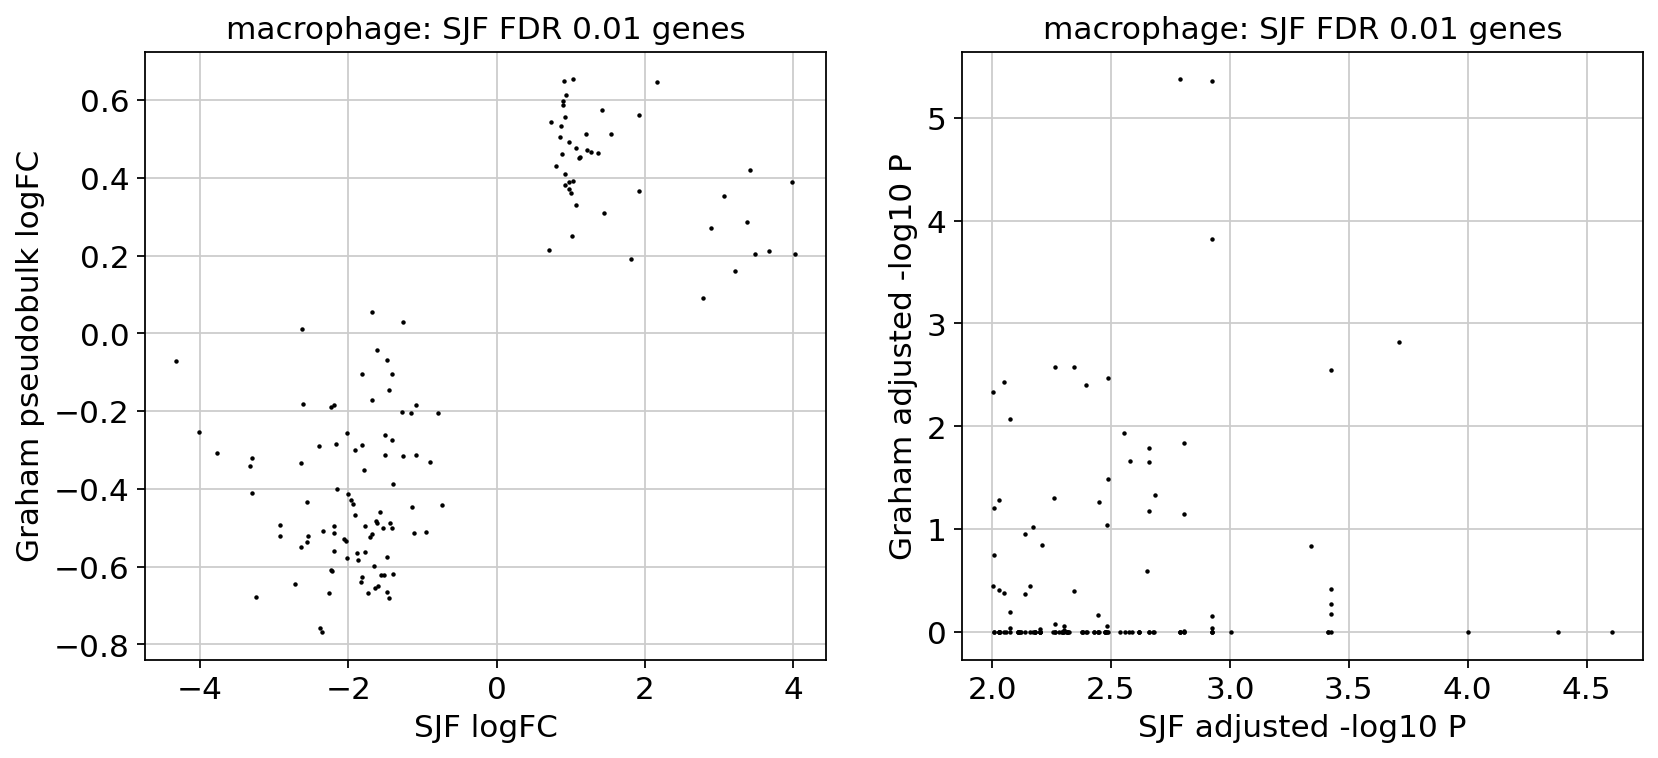

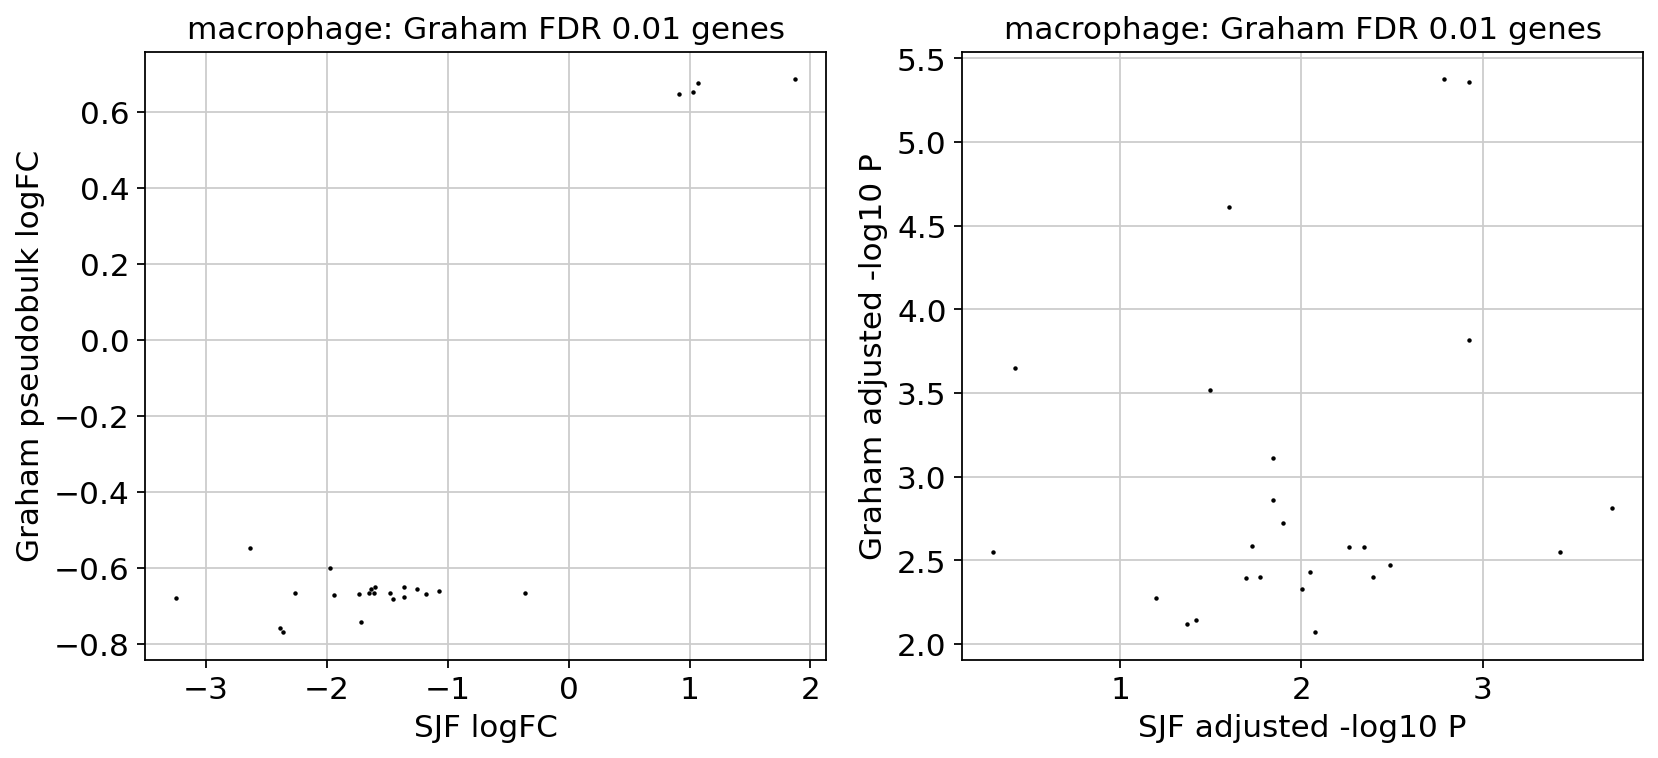

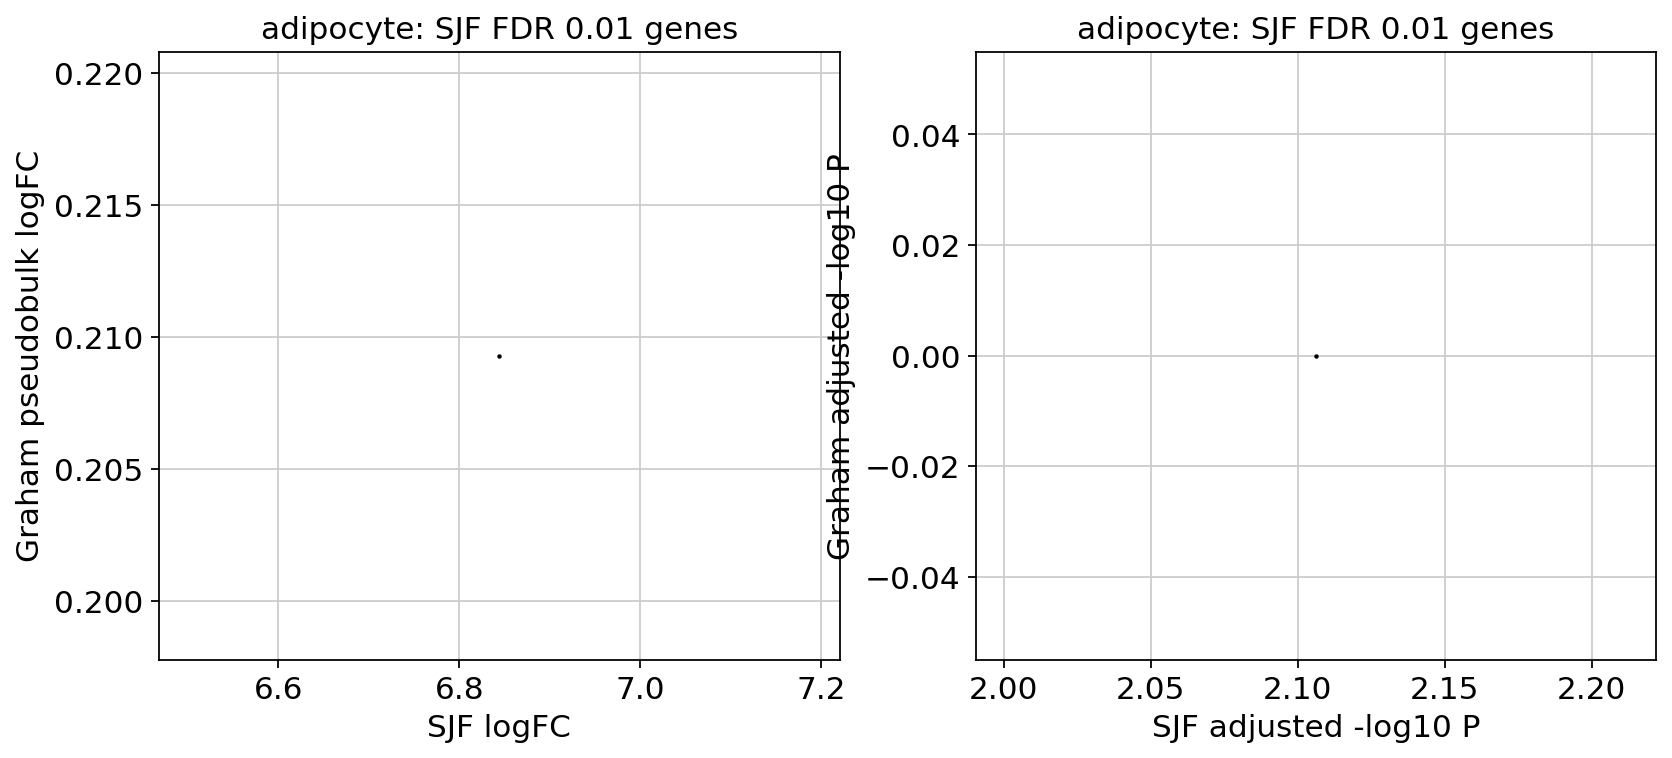

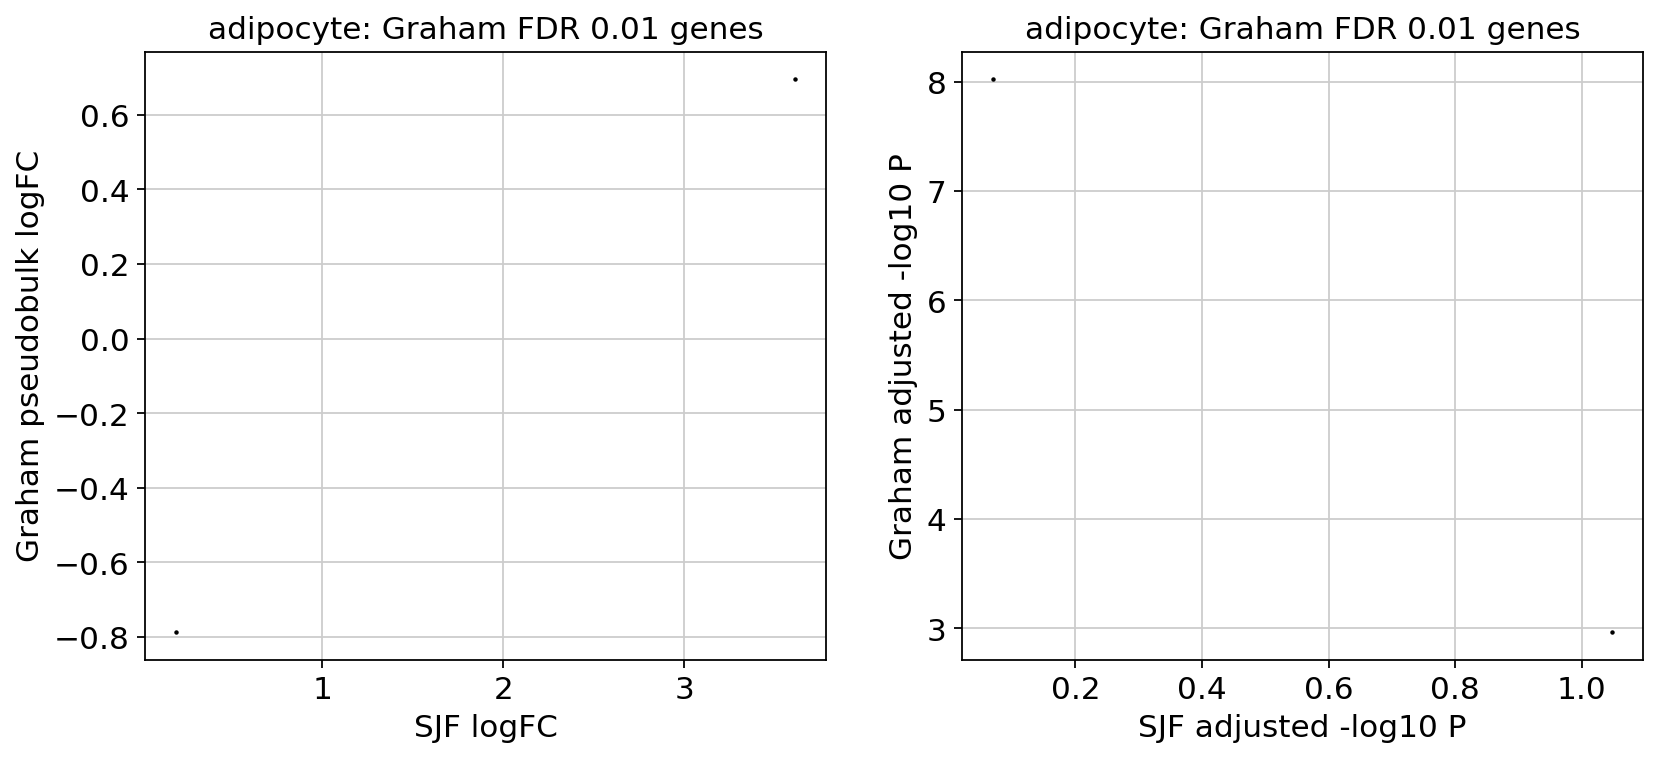

In [255]:
logFC = 'COVID19_log2fc' if PSEUDOBULK else 'disease_log2fc'


for k in df_combo['cluster'].unique():
    
    df_tmp = df_combo[(df_combo['cluster'] == k)
                      & (df_combo['adj.P.Val'] <= 0.01)]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df_tmp['logFC'],
             df_tmp[logFC], '.k', ms=2)
    plt.xlabel('SJF logFC')
    plt.ylabel(f'Graham {"pseudobulk" if PSEUDOBULK else "cell"} logFC')
    plt.title(f'{k}: SJF FDR 0.01 genes')
    
    plt.subplot(1, 2, 2)
    plt.plot(df_tmp['adj.P.Val'].apply(lambda x: -np.log10(x)),
             df_tmp['adjusted'].apply(lambda x: -np.log10(x)), '.k', ms=2)
    plt.xlabel('SJF adjusted -log10 P')
    plt.ylabel('Graham adjusted -log10 P')
    plt.title(f'{k}: SJF FDR 0.01 genes')
    plt.show()
    
    df_tmp = df_combo[(df_combo['cluster'] == k)
                      & (df_combo['adjusted'] <= 0.01)]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df_tmp['logFC'],
             df_tmp[logFC], '.k', ms=2)
    plt.xlabel('SJF logFC')
    plt.ylabel(f'Graham {"pseudobulk" if PSEUDOBULK else "cell"} logFC')
    plt.title(f'{k}: Graham FDR 0.01 genes')
    
    plt.subplot(1, 2, 2)
    plt.plot(df_tmp['adj.P.Val'].apply(lambda x: -np.log10(x)),
             df_tmp['adjusted'].apply(lambda x: -np.log10(x)), '.k', ms=2)
    plt.xlabel('SJF adjusted -log10 P')
    plt.ylabel('Graham adjusted -log10 P')
    plt.title(f'{k}: Graham FDR 0.01 genes')
    
    plt.show()

### Overlap

Take Graham's significant genes and prioritize them based on my tests.

In [91]:
df_combo

gene        cluster test.group comparison     logFC   AveExpr  \
0          PLCG2  cardiomyocyte    COVID19    healthy  4.927837  4.127685   
1        NDUFAF4  cardiomyocyte    COVID19    healthy -3.054964  3.344968   
2        FAM173A  cardiomyocyte    COVID19    healthy -3.537947  0.724291   
3         EXOSC8  cardiomyocyte    COVID19    healthy -2.792687  2.691533   
4           COQ6  cardiomyocyte    COVID19    healthy -2.290361  2.576831   
...          ...            ...        ...        ...       ...       ...   
96944       DGKB      adipocyte    COVID19    healthy -0.001838  2.518371   
96945  RPL34-AS1      adipocyte    COVID19    healthy  0.000437  2.704176   
96946      CDIPT      adipocyte    COVID19    healthy  0.000532  2.678282   
96947    DCUN1D2      adipocyte    COVID19    healthy  0.000343  3.571545   
96948       PTX3      adipocyte    COVID19    healthy -0.000444  2.665001   

               t       P.Value     adj.P.Val          B  \
0      15.128184  1.282908e-16  2.663060e-12  27.762225   
1     -12.678636  2.105392e-14  2.185186e-10  22.524909   
2     -12.067144  8.347113e-14  5.775645e-10  21.047245   
3     -11.635289  2.268605e-13  1.177293e-09  20.274164   
4     -11.045097  9.234320e-13  3.833720e-09  18.961168   
...          ...           ...           ...        ...   
96944  -0.001281  9.989912e-01  9.994204e-01  -5.551826   
96945   0.000455  9.996414e-01  9.997739e-01  -5.641862   
96946   0.000455  9.996415e-01  9.997739e-01  -5.600184   
96947   0.000383  9.996984e-01  9.997739e-01  -5.769344   
96948  -0.000287  9.997739e-01  9.997739e-01  -5.491831   

       test.group.cell.mean.counts  comparison.cell.mean.counts  \
0                         1.366968                     0.034075   
1                         0.038561                     0.176760   
2                         0.014158                     0.088262   
3                         0.024652                     0.124624   
4                         0.028733                     0.092807   
...                            ...                          ...   
96944                     0.065574                     0.091729   
96945                     0.147541                     0.033083   
96946                     0.049180                     0.059398   
96947                     0.360656                     0.118045   
96948                     0.008197                     0.066917   

       test.group.frac.expr>0  comparison.frac.expr>0  test.group.frac.expr>1  \
0                    0.530441                0.030475                0.296660   
1                    0.034896                0.147101                0.003082   
2                    0.013409                0.078156                0.000666   
3                    0.023320                0.110008                0.001249   
4                    0.026901                0.083819                0.001499   
...                       ...                     ...                     ...   
96944                0.049180                0.070677                0.016393   
96945                0.057377                0.031579                0.016393   
96946                0.040984                0.054887                0.008197   
96947                0.188525                0.100752                0.073770   
96948                0.008197                0.034586                0.000000   

       comparison.frac.expr>1  bkg.prob  COVID19_log2fc  adjusted  
0                    0.001909  0.190681        0.774326  0.000015  
1                    0.023445  0.019709       -0.698219  0.000301  
2                    0.008874  0.012424       -0.477893  1.000000  
3                    0.012932  0.032213       -0.711645  0.000851  
4                    0.008115  0.014911       -0.592382  0.265580  
...                       ...       ...             ...       ...  
96944                0.017293  0.044143        0.140271  1.000000  
96945                0.001504  0.054002        0.003279 

In [122]:
df_combo[df_combo['gene'] == 'AFDN']

gene               cluster test.group comparison     logFC   AveExpr  \
1777   AFDN         cardiomyocyte    COVID19    healthy  0.803486  3.281343   
26790  AFDN            fibroblast    COVID19    healthy  0.330228  5.318704   
37542  AFDN              pericyte    COVID19    healthy  1.525873  3.955227   
52853  AFDN                  vsmc    COVID19    healthy  1.027095  4.330484   
61168  AFDN                immune    COVID19    healthy  1.330437  5.042686   
68267  AFDN  vascular endothelial    COVID19    healthy  0.644474  7.421985   
84238  AFDN            macrophage    COVID19    healthy  0.394057  4.077408   
88633  AFDN             adipocyte    COVID19    healthy  2.137705  2.971140   

              t   P.Value  adj.P.Val         B  test.group.cell.mean.counts  \
1777   4.797970  0.000032   0.000370  1.889294                     0.522616   
26790  2.113088  0.041503   0.110832 -4.875833                     0.366802   
37542  4.946642  0.000015   0.000297  2.805071                     0.251345   
52853  1.370620  0.183569   0.588512 -5.038628                     0.295606   
61168  1.672285  0.104776   0.337230 -4.780991                     0.072968   
68267  2.622786  0.012419   0.049094 -4.050270                     1.675369   
84238  0.777560  0.442230   0.684221 -5.818995                     0.075556   
88633  2.206772  0.039965   0.372610 -3.889983                     0.942622   

       comparison.cell.mean.counts  test.group.frac.expr>0  \
1777                      0.175676                0.303739   
26790                     0.112574                0.247317   
37542                     0.041492                0.143225   
52853                     0.051056                0.177097   
61168                     0.026542                0.054726   
68267                     0.343534                0.567333   
84238                     0.027352                0.060317   
88633                     0.034586                0.368852   

       comparison.frac.expr>0  test.group.frac.expr>1  comparison.frac.expr>1  \
1777                 0.137738                0.108853                0.029661   
26790                0.087897                0.074081                0.018104   
37542                0.033710                0.052188                0.005687   
52853                0.043427                0.053262                0.005869   
61168                0.017174                0.009950                0.003903   
68267                0.232926                0.331669                0.074488   
84238                0.024025                0.011429                0.002587   
88633                0.025564                0.221311                0.004511   

       bkg.prob  COVID19_log2fc      adjusted  
1777   0.172176        0.592105  4.917484e-01  
26790  0.182582        0.572854  4.763668e-01  
37542  0.250878        0.762520  2.241263e-07  
52853  0.212948             NaN           NaN  
61168  0.274836        0.145256  1.000000e+00  
68267  0.059437        0.589341  8.469579e-02  
84238  0.274023        0.167519  1.000000e+00  
88633  0.223205        0.316831  1.000000e+00

In [232]:
from IPython.display import display, HTML


gene_list = []

for k in df_combo['cluster'].unique():
    
    df_tmp = (df_combo[(df_combo['cluster'] == k)
                       & (df_combo['adjusted'] <= 0.05)
                       & (df_combo['adj.P.Val'] <= 0.01)
                       & (df_combo['logFC'] > 1)
                       & (df_combo[logFC] > 0.5)
                       & (df_combo['bkg.prob'] < 0.5)
                       & (df_combo['test.group.cell.mean.counts'] > 0.05)]
              .sort_values(by='logFC', ascending=False))
    
    display(HTML(df_tmp.head().to_html()))
    
    gene_list.extend(df_tmp['gene'].values.tolist())
    
gene_list = np.unique(gene_list)

In [233]:
gene_list

array(['AC008742.1', 'AC016831.7', 'ADAMTS1', 'ATP2B4', 'BNC2', 'CAMK2D',
       'CMYA5', 'COL12A1', 'COL19A1', 'COL4A1', 'COL4A2', 'COL6A3',
       'DGKD', 'DMXL2', 'DST', 'EPS8', 'ETS1', 'FBN1', 'FMNL2',
       'FP236383.1', 'FP671120.1', 'FTL', 'GBE1', 'HIVEP2', 'LDLRAD3',
       'MAP3K20', 'MAST4', 'MCTP1', 'MT-CO3', 'MT-ND3', 'MYO18B', 'MYPN',
       'NAV2', 'NEAT1', 'NRAP', 'PAG1', 'PARD3', 'PDE10A', 'PDLIM3',
       'PLCG2', 'PREX2', 'PRKN', 'QKI', 'RALGAPA2', 'ROR1', 'SAMD4A',
       'SLCO5A1', 'ST3GAL6', 'TCF4', 'THBS1', 'THBS2', 'TRIO', 'TRPS1',
       'TSHZ2', 'TSIX', 'TXNRD1', 'VAV3', 'VCAN', 'VEGFC', 'VMP1', 'YBX3'],
      dtype='<U10')

In [234]:
print(', '.join(gene_list))

AC008742.1, AC016831.7, ADAMTS1, ATP2B4, BNC2, CAMK2D, CMYA5, COL12A1, COL19A1, COL4A1, COL4A2, COL6A3, DGKD, DMXL2, DST, EPS8, ETS1, FBN1, FMNL2, FP236383.1, FP671120.1, FTL, GBE1, HIVEP2, LDLRAD3, MAP3K20, MAST4, MCTP1, MT-CO3, MT-ND3, MYO18B, MYPN, NAV2, NEAT1, NRAP, PAG1, PARD3, PDE10A, PDLIM3, PLCG2, PREX2, PRKN, QKI, RALGAPA2, ROR1, SAMD4A, SLCO5A1, ST3GAL6, TCF4, THBS1, THBS2, TRIO, TRPS1, TSHZ2, TSIX, TXNRD1, VAV3, VCAN, VEGFC, VMP1, YBX3


In [ ]:
sc.set_figure_params(fontsize=14)

for group in ['cluster_disease', 'study', 'individual', 'version10x']:

    sc.pl.dotplot(adata,
                  groupby=group,
                  var_names=gene_list,
#                   standard_scale='var',
                  log=True,
                  color_map='Greys',
#                   swap_axes=True,
                  vmax=1,
                  smallest_dot=15)

In [238]:
remarkable_gene_list = [
#     'AC008440.2', 'AC092069.1',  # total unknowns
    'AFDN',  # cell-cell junctions
    'DDX60L',  # antiviral
    'FBN1',  # ECM
    'FP236383.1', 'FP671120.1',  # total unknowns
    'GRB10',  # growth factor receptor binder
    'HIVEP2',  # antiviral
    'HNRNPU',  # negative regulation of HIV
    'LDLRAD3',  # LDL receptor
    'MGAT5',  # regulation of inflammation
    'PCNX1',  # ... development?
    'PHLDB2',  # neuronal signalling?
    'PLCG2',  # auto-inflammation
    'PLCL2',  # related to PLCG2
    'QKI',  # represses translation
    'SYNM',  # muscle
    'TSHZ2',  # transcriptional repressor
]

## Extended Data Figure 11d

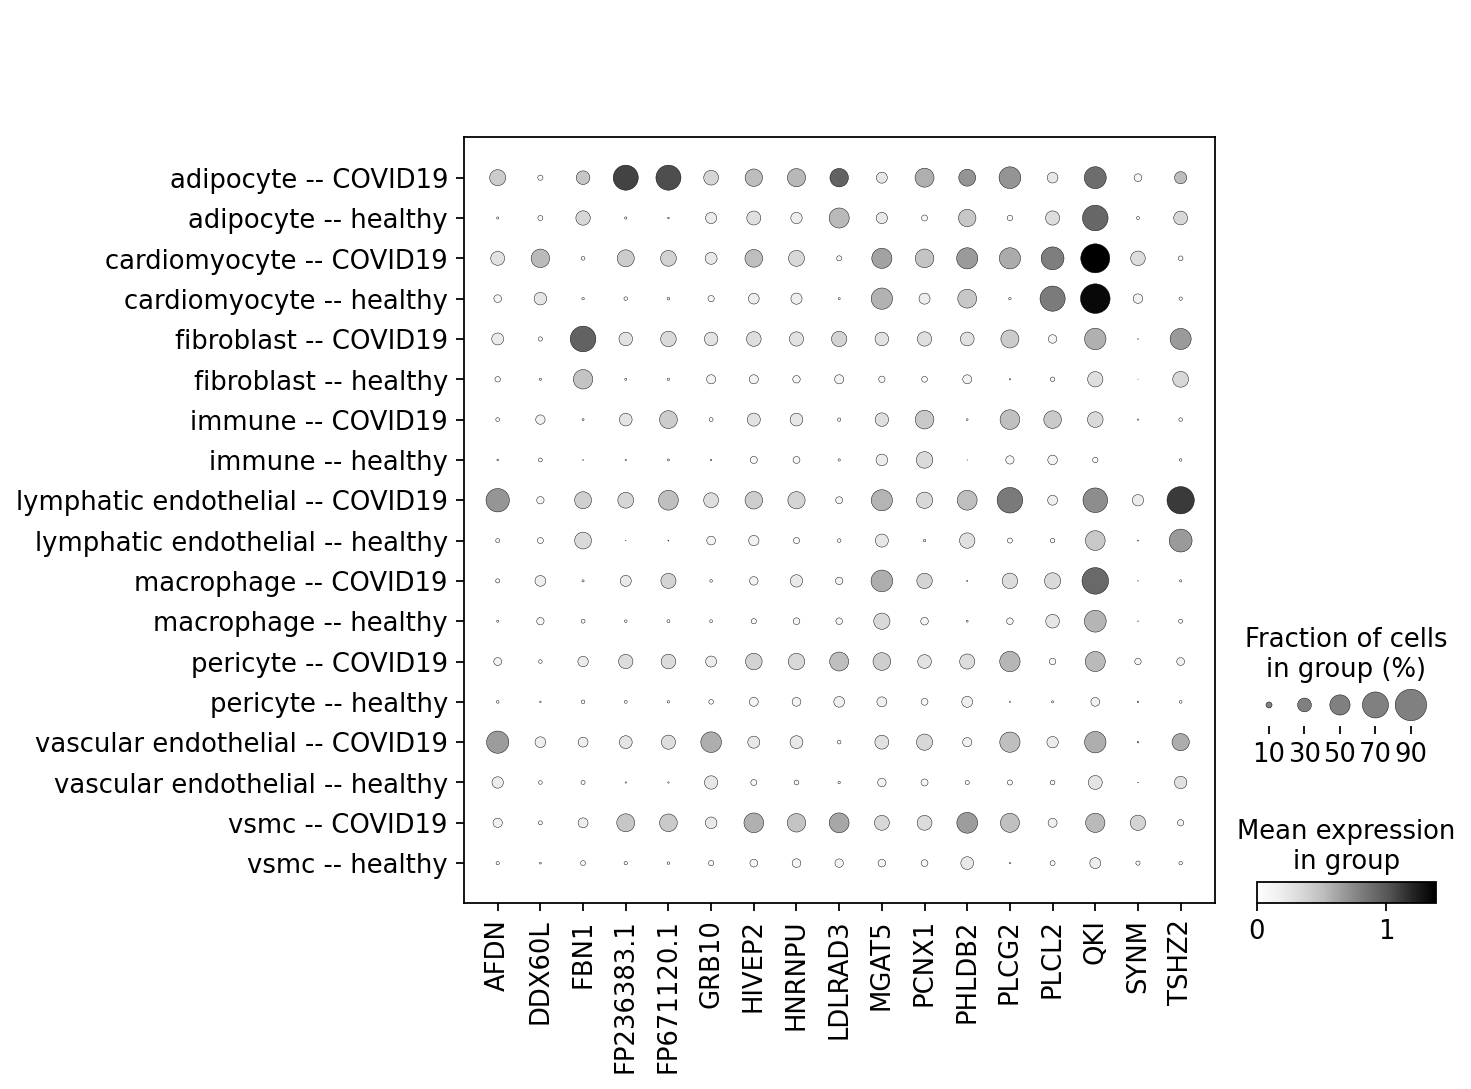

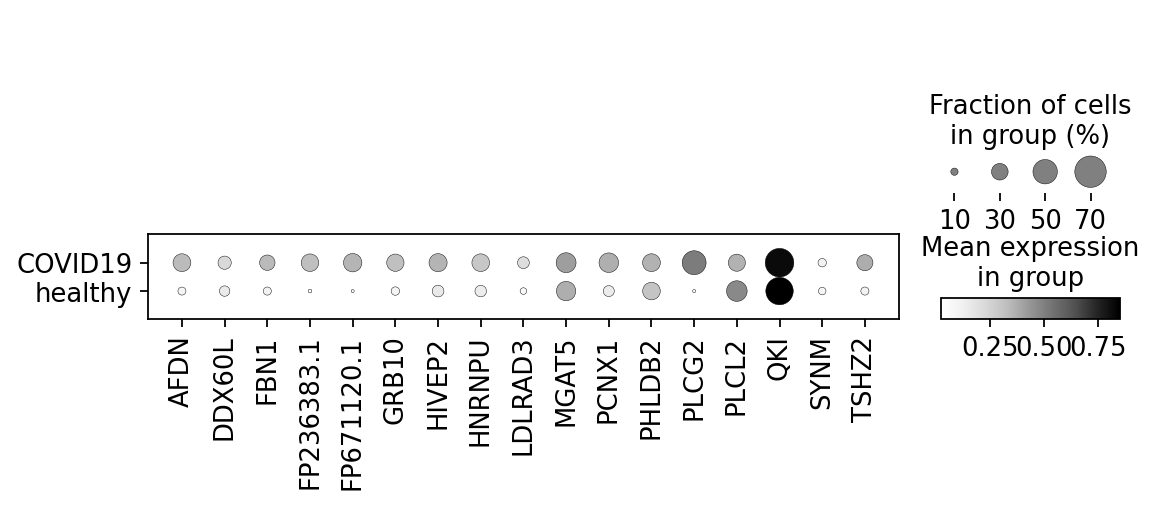

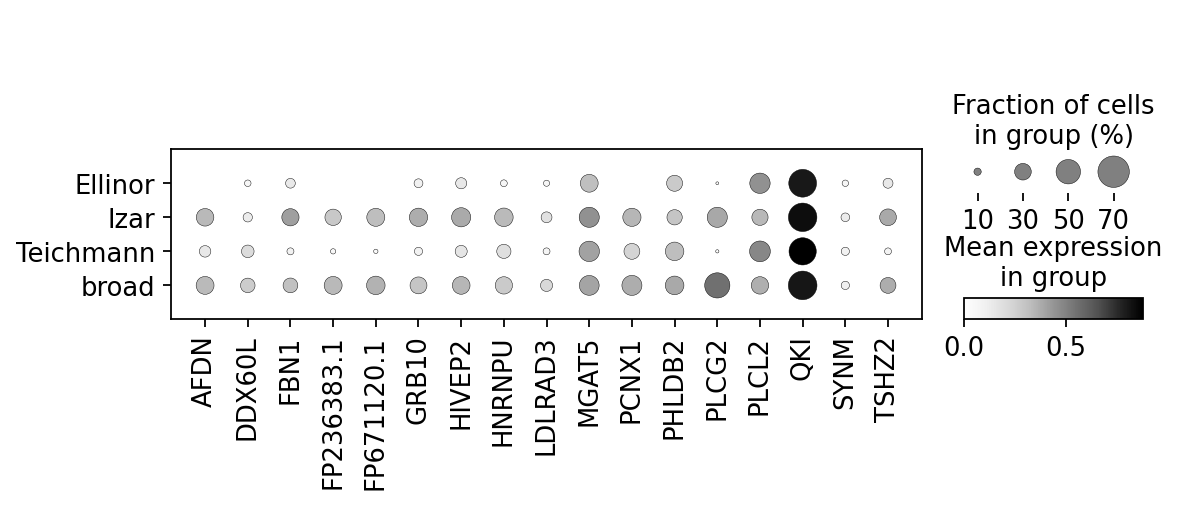

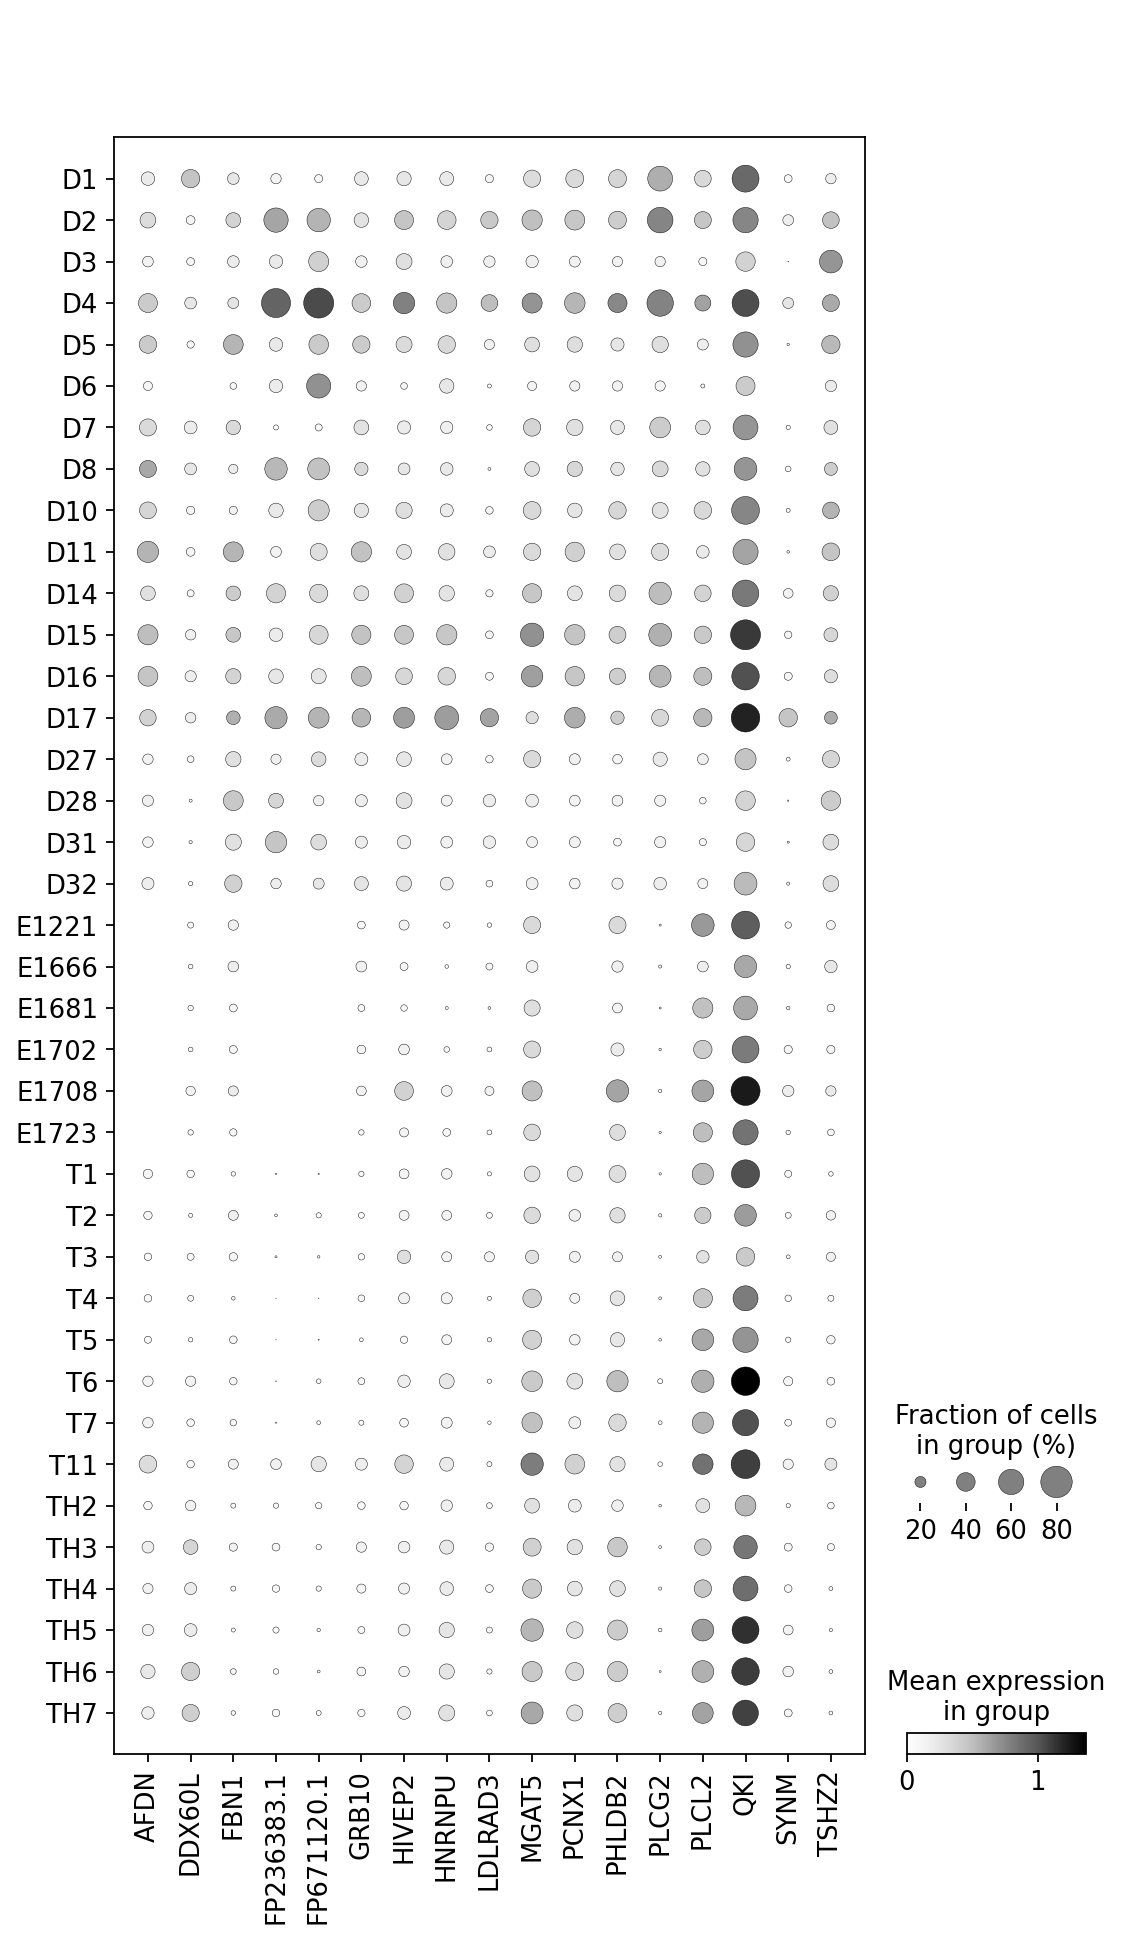

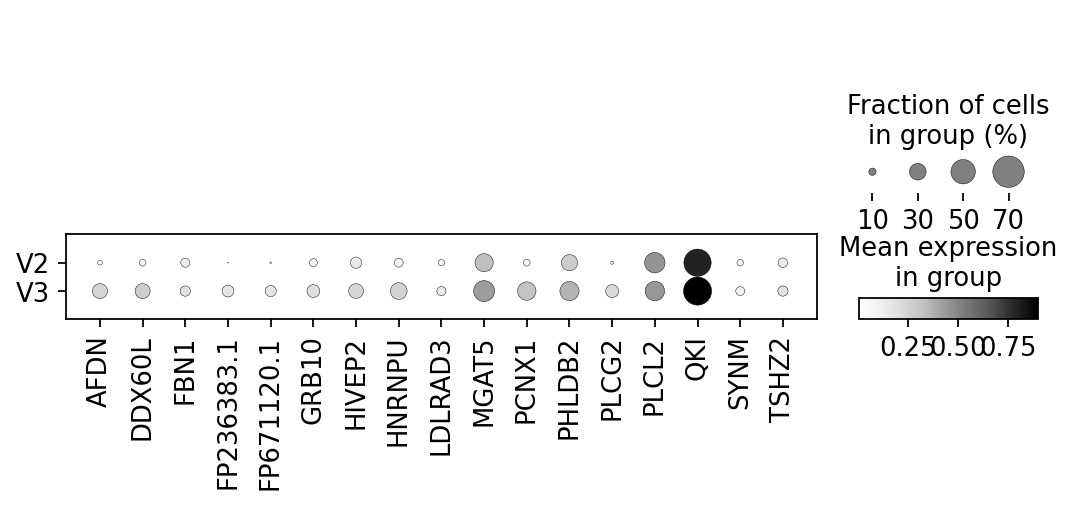

In [239]:
for group in ['cluster_disease', 'disease', 'study', 'individual', 'version10x']:

    sc.pl.dotplot(adata,
                  groupby=group,
                  var_names=remarkable_gene_list,
#                   standard_scale='var',
                  log=True,
                  color_map='Greys',
#                   vmax=1,
                  smallest_dot=25,
                  show=False)
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_{group}_dotplot.pdf',
                      bbox_inches='tight')